In [39]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [40]:
# Import additional libraries for chemometric preprocessing
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter

In [41]:
# Define data folder path
data_folder = Path('raw_csv_data')

# Get all CSV files
csv_files = list(data_folder.glob("*.csv"))

print(f"Total CSV files found: {len(csv_files)}")
print(*csv_files, sep="\n")

Total CSV files found: 62
raw_csv_data\Acrylic 1.csv
raw_csv_data\Acrylic 2.csv
raw_csv_data\Acrylic 3.csv
raw_csv_data\Acrylic 4.csv
raw_csv_data\Acrylic 5.csv
raw_csv_data\Cotton - 1.csv
raw_csv_data\Cotton - 2.csv
raw_csv_data\Cotton - 3.csv
raw_csv_data\Cotton - 4.csv
raw_csv_data\Cotton - 5.csv
raw_csv_data\Cotton - 6.csv
raw_csv_data\Jute - 1.csv
raw_csv_data\Jute - 2.csv
raw_csv_data\Linen - 1.csv
raw_csv_data\Linen - 2.csv
raw_csv_data\Linen - 3.csv
raw_csv_data\Linen - 4.csv
raw_csv_data\Linen - 5.csv
raw_csv_data\Linen - 6.csv
raw_csv_data\Modacrylic - 1.csv
raw_csv_data\Modacrylic - 2.csv
raw_csv_data\Modacrylic - 3.csv
raw_csv_data\Modacrylic - 4.csv
raw_csv_data\Nylon 1.csv
raw_csv_data\Nylon 2.csv
raw_csv_data\Nylon 3.csv
raw_csv_data\Polyester - 1.csv
raw_csv_data\Polyester - 2.csv
raw_csv_data\Polyester - 3.csv
raw_csv_data\Polyester - 4.csv
raw_csv_data\Polyester - 5.csv
raw_csv_data\Polyester - 6.csv
raw_csv_data\Polyester 1.csv
raw_csv_data\Polyester 2.csv
raw_csv_da

In [42]:
# Analyze file structure
fabric_counts = {}
file_info = []

for csv_file in sorted(csv_files):
    # Extract fabric type from filename
    match = re.match(r"([a-zA-Z\s]+)", csv_file.stem)
    fabric_type = match.group(1).strip() if match else "Unknown"
    
    fabric_counts[fabric_type] = fabric_counts.get(fabric_type, 0) + 1
    
    # Read a sample file to get dimensions
    df_sample = pd.read_csv(csv_file, skiprows=1, header=0)
    
    file_info.append({
        'Filename': csv_file.name,
        'Fabric Type': fabric_type,
        'Data Points': len(df_sample)
    })

# Display file information
info_df = pd.DataFrame(file_info)
print("\nFile Details:")
print(f"-" * 60)
print(info_df.to_string(index=False))

# Display fabric type distribution
print(f"\n\nFabric Type Distribution:")
print(f"-" * 60)
for fabric, count in sorted(fabric_counts.items()):
    print(f"  {fabric:<15} : {count} samples")



File Details:
------------------------------------------------------------
          Filename Fabric Type  Data Points
     Acrylic 1.csv     Acrylic         3451
     Acrylic 2.csv     Acrylic         3451
     Acrylic 3.csv     Acrylic         3451
     Acrylic 4.csv     Acrylic         3451
     Acrylic 5.csv     Acrylic         3451
    Cotton - 1.csv      Cotton         3451
    Cotton - 2.csv      Cotton         3451
    Cotton - 3.csv      Cotton         3451
    Cotton - 4.csv      Cotton         3451
    Cotton - 5.csv      Cotton         3451
    Cotton - 6.csv      Cotton         3451
      Jute - 1.csv        Jute         3451
      Jute - 2.csv        Jute         3451
     Linen - 1.csv       Linen         3451
     Linen - 2.csv       Linen         3451
     Linen - 3.csv       Linen         3451
     Linen - 4.csv       Linen         3451
     Linen - 5.csv       Linen         3451
     Linen - 6.csv       Linen         3451
Modacrylic - 1.csv  Modacrylic         3451


Now let's visualise the raw %T (percent transmittance) vs wavenumber data to identify:
- **Baseline shifts**: Vertical offsets between spectra
- **Scattering effects**: Sloping baselines (especially at higher wavenumbers)
- **Peak characteristics**: Functional group absorption bands
- **Spectral variability**: Within-class and between-class differences

Generating Plot 1: Within-Class Variability for Each Fabric Type


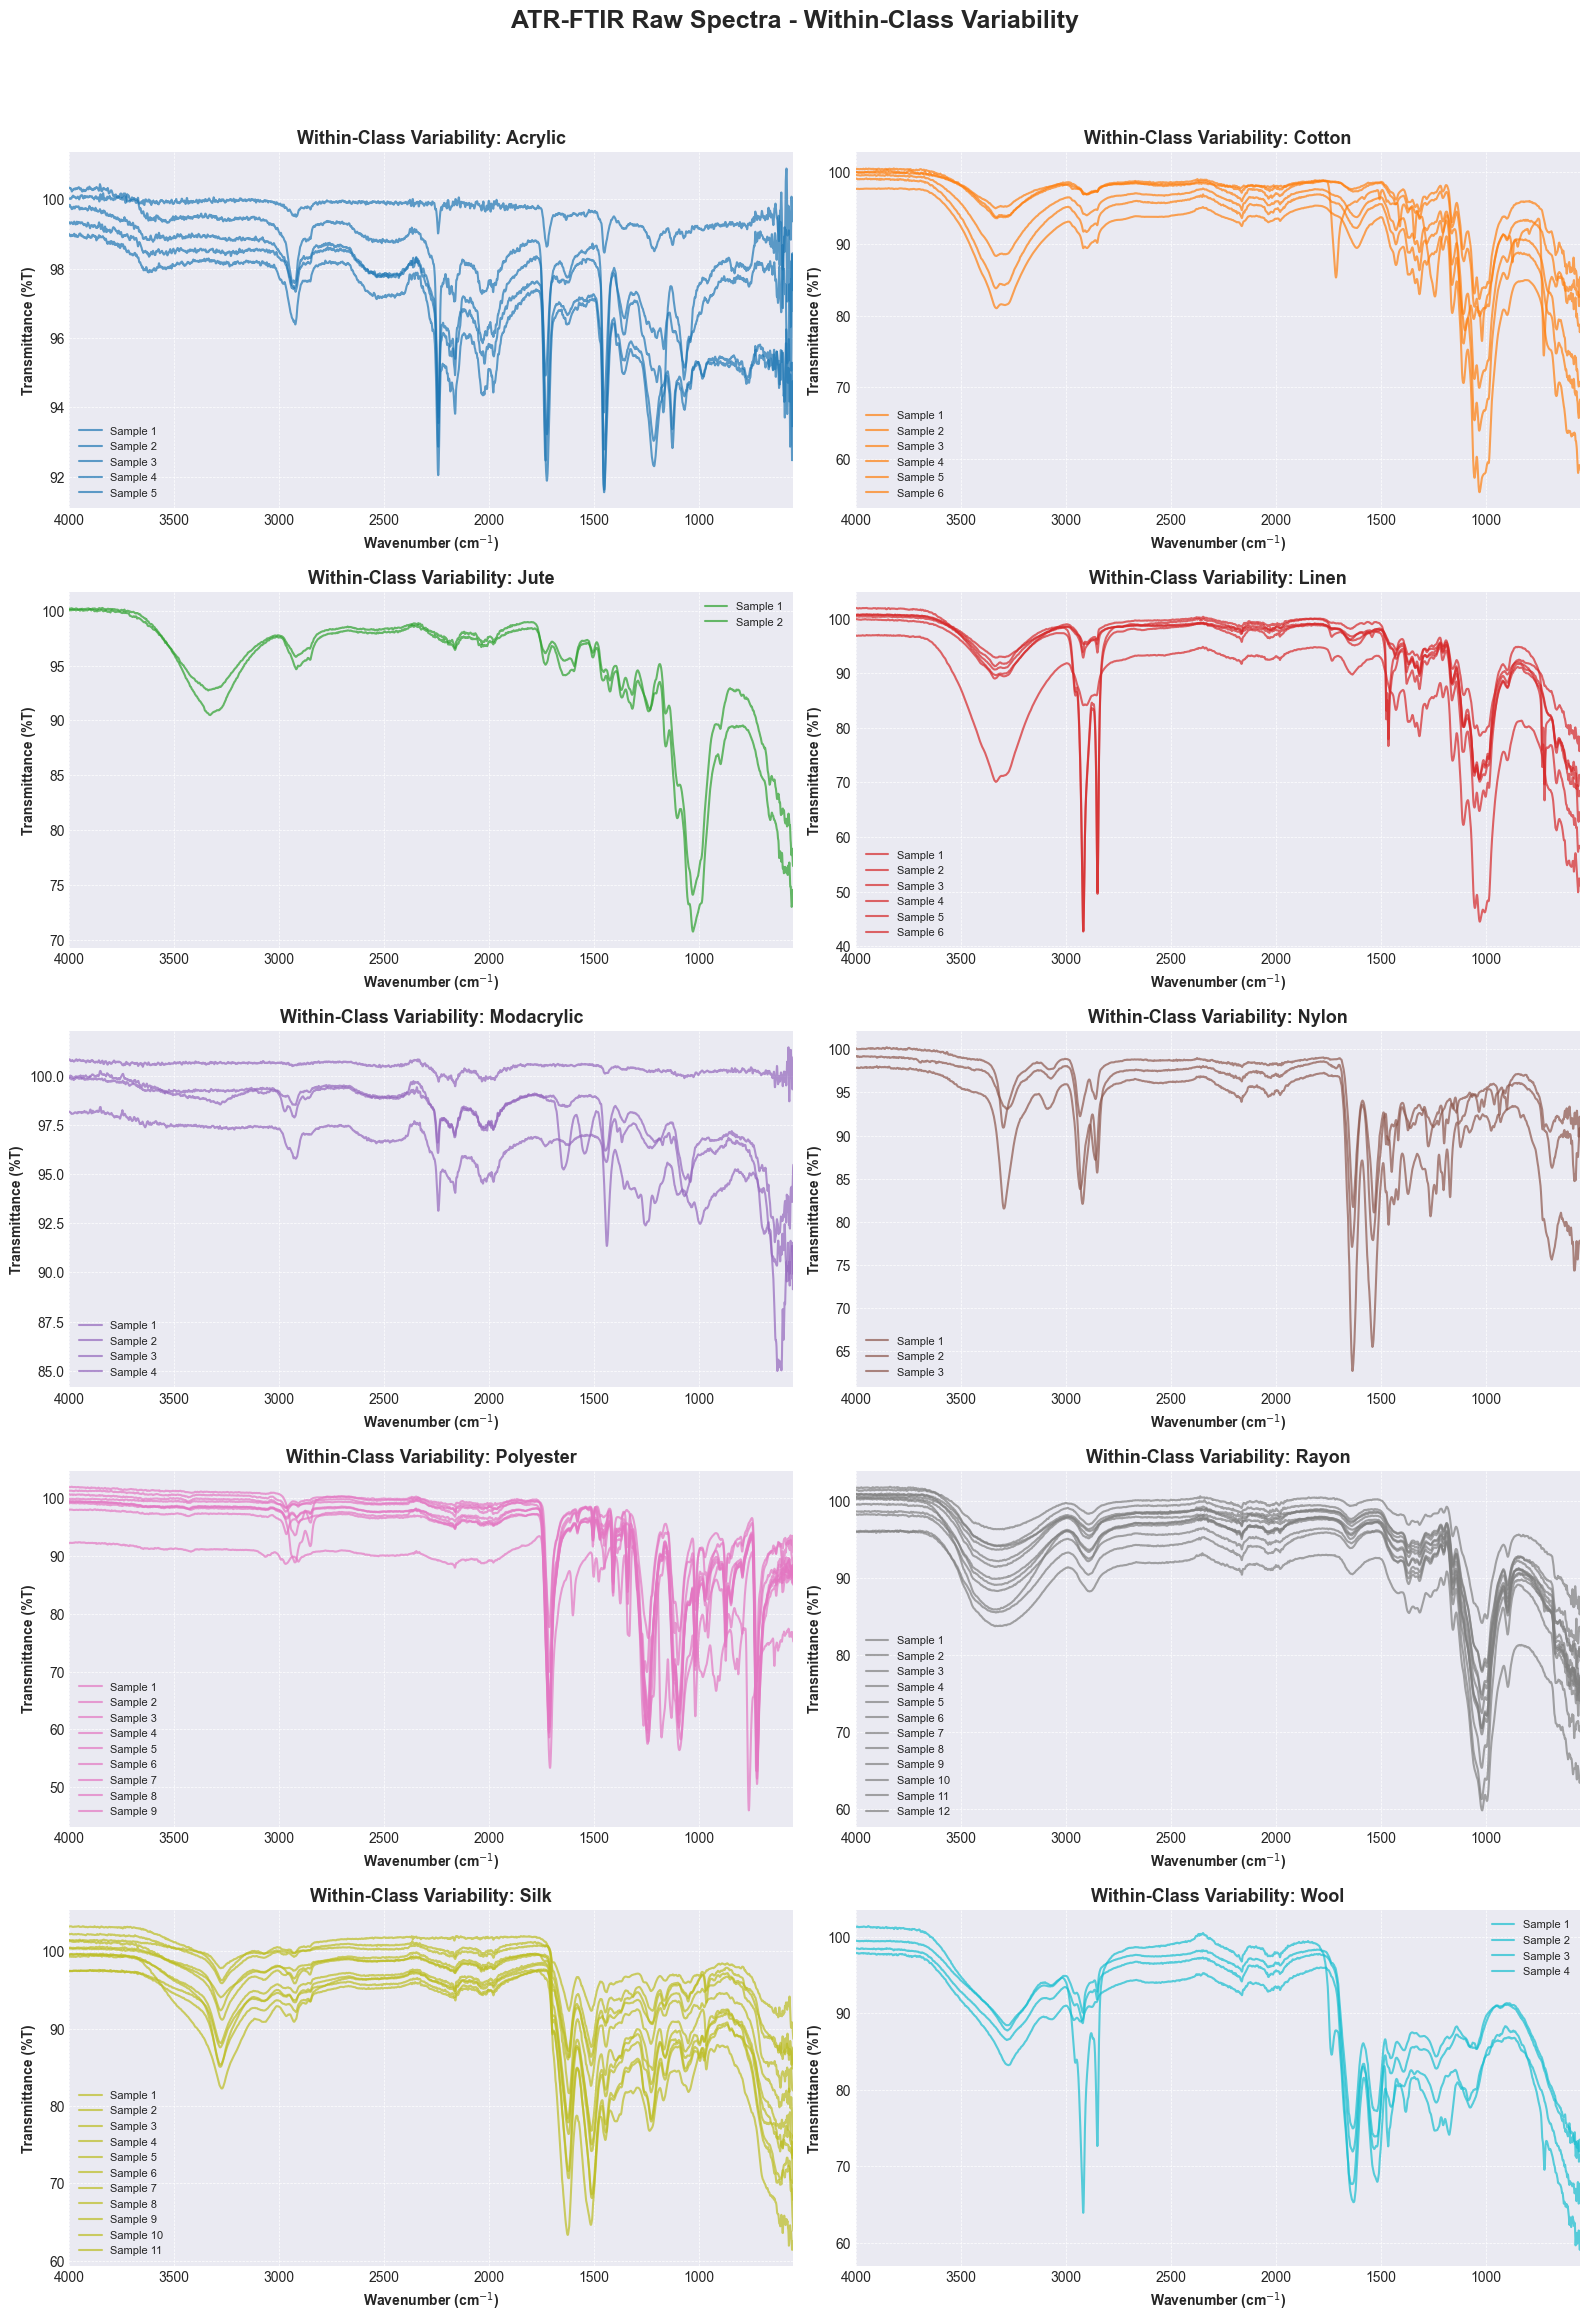

In [43]:
# Load and visualize raw transmittance data
plt.style.use('seaborn-v0_8-darkgrid')

# Within-Class Variability for All Fabric Types
print("Generating Plot 1: Within-Class Variability for Each Fabric Type")

fabric_types = sorted(fabric_counts.keys())
n_fabrics = len(fabric_types)
n_cols = 2
n_rows = (n_fabrics + n_cols - 1) // n_cols  # Calculate rows needed

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4.5), squeeze=False)
axes1 = axes1.flatten()

# Define color palette for fabric types
colors = plt.cm.get_cmap('tab10', n_fabrics)
color_map = dict(zip(fabric_types, [colors(i) for i in range(n_fabrics)]))

for i, fabric in enumerate(fabric_types):
    ax = axes1[i]
    fabric_files = [f for f in csv_files if f.stem.startswith(fabric)]
    
    # Use a consistent color for all samples of the same fabric type
    fabric_color = color_map[fabric]
    
    for j, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        ax.plot(df['cm-1'], df['%T'], linewidth=1.5, alpha=0.7, label=f"Sample {j+1}", color=fabric_color)

    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Transmittance (%T)', fontsize=10, fontweight='bold')
    ax.set_title(f'Within-Class Variability: {fabric}', fontsize=13, fontweight='bold')
    ax.invert_xaxis()
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(4000, 550)

# Hide any unused subplots
for i in range(n_fabrics, len(axes1)):
    fig1.delaxes(axes1[i])

fig1.suptitle('ATR-FTIR Raw Spectra - Within-Class Variability', fontsize=18, fontweight='bold', y=1.03)
fig1.tight_layout()
plt.show()

## Interactive Class-Wise Baseline Shift Visualization

Select a fabric type to visualize baseline shifts and scattering effects within that specific class.

In [44]:
from ipywidgets import interact, Dropdown

def plot_class_baseline_shifts(selected_fabric):
    """
    Plot all samples of a selected fabric type to visualize within-class baseline shifts.
    
    Parameters:
    -----------
    selected_fabric : str
        Fabric type selected from dropdown
    """
    # Get all files for selected fabric type
    fabric_files = [f for f in csv_files if f.stem.startswith(selected_fabric)]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Full spectrum range (4000-550 cm⁻¹)
    for i, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        ax1.plot(wavenumbers, transmittance, linewidth=1.5, alpha=0.7, 
                label=f'Sample {i+1}', color=color_map[selected_fabric])
    
    ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{selected_fabric} - Baseline Shifts (Full Spectrum)', fontsize=14, fontweight='bold')
    ax1.invert_xaxis()
    ax1.set_xlim(4000, 550)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Plot 2: Fingerprint region (1800-550 cm⁻¹) for detailed view
    for i, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        ax2.plot(wavenumbers, transmittance, linewidth=1.5, alpha=0.7,
                label=f'Sample {i+1}', color=color_map[selected_fabric])
    
    ax2.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax2.set_title(f'{selected_fabric} - Baseline Shifts (Fingerprint Region)', fontsize=14, fontweight='bold')
    ax2.invert_xaxis()
    ax2.set_xlim(1800, 550)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print baseline statistics
    print("\n" + "="*70)
    print(f"Baseline Analysis: {selected_fabric}")
    print("="*70)
    print(f"\nNumber of samples: {len(fabric_files)}")
    
    # Calculate baseline variations at specific wavenumbers
    baseline_points = [4000, 2000, 1000, 600]  # Key wavenumber positions
    
    print(f"\n{'Wavenumber (cm⁻¹)':<20} {'Min %T':<15} {'Max %T':<15} {'Range':<15}")
    print("-" * 70)
    
    for wn_target in baseline_points:
        transmittance_values = []
        for csv_file in fabric_files:
            df = pd.read_csv(csv_file, skiprows=1, header=0)
            # Find closest wavenumber
            idx = np.argmin(np.abs(df['cm-1'].values - wn_target))
            transmittance_values.append(df['%T'].values[idx])
        
        min_t = np.min(transmittance_values)
        max_t = np.max(transmittance_values)
        range_t = max_t - min_t
        
        print(f"{wn_target:<20} {min_t:<15.2f} {max_t:<15.2f} {range_t:<15.2f}")
    
    print("="*70)

# Create interactive dropdown widget
interact(plot_class_baseline_shifts,
         selected_fabric=Dropdown(
             options=sorted(fabric_types),
             value=sorted(fabric_types)[0],
             description='Select Fabric:',
             style={'description_width': 'initial'},
             layout={'width': '400px'}
         ))

interactive(children=(Dropdown(description='Select Fabric:', layout=Layout(width='400px'), options=('Acrylic',…

<function __main__.plot_class_baseline_shifts(selected_fabric)>

## Interactive Spectrum Viewer with Peak Identification

Select any sample from the dropdown to visualize its spectrum and identify important peaks.

In [45]:
from scipy.signal import find_peaks
from ipywidgets import interact, Dropdown

# Create dropdown options from available CSV files
csv_options = {f.stem: f for f in sorted(csv_files)}

def plot_spectrum_with_peaks(selected_file):
    """
    Plot the selected spectrum with identified peaks.
    
    Peak identification focuses on major absorption bands:
    - O-H/N-H stretch: 3600-3200 cm⁻¹
    - C-H stretch: 3000-2800 cm⁻¹
    - C=O stretch: 1750-1600 cm⁻¹
    - Fingerprint region: 1500-550 cm⁻¹
    """
    # Load the selected CSV file
    csv_file = csv_options[selected_file]
    df = pd.read_csv(csv_file, skiprows=1, header=0)
    
    wavenumbers = df['cm-1'].values
    transmittance = df['%T'].values
    
    # Convert to absorbance for peak detection
    absorbance = 2 - np.log10(transmittance + 1e-9) # Formula: A = 2 - log10(%T)
    
    # Detect peaks in absorbance (peaks = high absorbance = low transmittance)
    # Parameters tuned for FTIR spectra
    peaks, properties = find_peaks(
        absorbance, 
        prominence=0.005,  # Minimum peak prominence
        distance=10,      # Minimum distance between peaks (in data points)
        height=0.002      # Minimum peak height in absorbance units
    )
    
    # Filt1er to keep only significant peaks (top 15 by prominence)
    if len(peaks) > 5:
        prominences = properties['prominences']
        top_peak_indices = np.argsort(prominences)[-15:]
        peaks = peaks[top_peak_indices]
        peaks = np.sort(peaks)  # Sort by wavenumber
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # --- Plot 1: Transmittance Mode ---
    ax1.plot(wavenumbers, transmittance, 'b-', linewidth=1.5, label='Transmittance')
    
    # Mark peaks (inverted for transmittance - peaks in absorbance = valleys in transmittance)
    if len(peaks) > 0:
        ax1.plot(wavenumbers[peaks], transmittance[peaks], 'ro', 
                markersize=8, label=f'Detected Peaks (n={len(peaks)})', zorder=5)
        
        # Annotate major peaks
        for peak_idx in peaks:
            wn = wavenumbers[peak_idx]
            t = transmittance[peak_idx]
            # Only annotate if in key regions
            if (3600 >= wn >= 3200) or (3000 >= wn >= 2800) or \
               (1750 >= wn >= 1600) or (1500 >= wn >= 550):
                ax1.annotate(f'{int(wn)}', 
                           xy=(wn, t), 
                           xytext=(0, -15), 
                           textcoords='offset points',
                           ha='center', 
                           fontsize=8, 
                           color='red',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Spectrum: {selected_file} (Transmittance Mode)', 
                 fontsize=14, fontweight='bold')
    ax1.invert_xaxis()
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='best', fontsize=10)
    ax1.set_xlim(4000, 550)
    
    # --- Plot 2: Absorbance Mode ---
    ax2.plot(wavenumbers, absorbance, 'g-', linewidth=1.5, label='Absorbance')
    
    # Mark peaks
    if len(peaks) > 0:
        ax2.plot(wavenumbers[peaks], absorbance[peaks], 'ro', 
                markersize=8, label=f'Detected Peaks (n={len(peaks)})', zorder=5)
        
        # Annotate major peaks
        for peak_idx in peaks:
            wn = wavenumbers[peak_idx]
            a = absorbance[peak_idx]
            if (3600 >= wn >= 3200) or (3000 >= wn >= 2800) or \
               (1750 >= wn >= 1600) or (1500 >= wn >= 550):
                ax2.annotate(f'{int(wn)}', 
                           xy=(wn, a), 
                           xytext=(0, 10), 
                           textcoords='offset points',
                           ha='center', 
                           fontsize=8, 
                           color='red',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Add shaded regions for key spectral regions
    ax2.axvspan(3600, 3200, alpha=0.1, color='blue', label='O-H/N-H stretch')
    ax2.axvspan(3000, 2800, alpha=0.1, color='green', label='C-H stretch')
    ax2.axvspan(1750, 1600, alpha=0.1, color='orange', label='C=O stretch')
    ax2.axvspan(1500, 550, alpha=0.1, color='purple', label='Fingerprint')
    
    ax2.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Absorbance', fontsize=12, fontweight='bold')
    ax2.set_title(f'Spectrum: {selected_file} (Absorbance Mode with Peak Detection)', 
                 fontsize=14, fontweight='bold')
    ax2.invert_xaxis()
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='best', fontsize=9)
    ax2.set_xlim(4000, 550)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak information
    print("\n" + "="*80)
    print(f"Peak Analysis for: {selected_file}")
    print("="*80)
    
    if len(peaks) > 0:
        print(f"\n{'Peak #':<8} {'Wavenumber (cm⁻¹)':<20} {'Absorbance':<15} {'Possible Assignment':<30}")
        print("-" * 80)
        
        for idx, peak_idx in enumerate(peaks, 1):
            wn = wavenumbers[peak_idx]
            a = absorbance[peak_idx]
            
            # Assign functional groups based on wavenumber
            assignment = ""
            if 3600 >= wn >= 3200:
                assignment = "O-H/N-H stretching"
            elif 3000 >= wn >= 2800:
                assignment = "C-H stretching (aliphatic)"
            elif 1750 >= wn >= 1700:
                assignment = "C=O stretching (ester/acid)"
            elif 1700 >= wn >= 1600:
                assignment = "C=O stretching, Amide I"
            elif 1600 >= wn >= 1500:
                assignment = "Amide II, aromatic C=C"
            elif 1500 >= wn >= 1200:
                assignment = "C-H bending, C-O stretch"
            elif 1200 >= wn >= 1000:
                assignment = "C-O stretching"
            elif 1000 >= wn >= 550:
                assignment = "Fingerprint region"
            else:
                assignment = "Other"
            
            print(f"{idx:<8} {int(wn):<20} {a:<15.4f} {assignment:<30}")
        
        print("\n" + "="*80)
    else:
        print("No significant peaks detected.")
    
    print(f"\nAnalysis complete for {selected_file}\n")

# Create interactive dropdown widget
interact(plot_spectrum_with_peaks, 
         selected_file=Dropdown(
             options=list(csv_options.keys()),
             value=list(csv_options.keys())[0],
             description='Select Sample:',
             style={'description_width': 'initial'},
             layout={'width': '400px'}
         ))

interactive(children=(Dropdown(description='Select Sample:', layout=Layout(width='400px'), options=('Acrylic 1…

<function __main__.plot_spectrum_with_peaks(selected_file)>

# Chemometric Preprocessing & Baseline Correction

Now, applying essential chemometric preprocessing techniques commonly used in spectroscopy-ML workflows:

## 1. **Baseline Correction Methods**
- **Asymmetric Least Squares (ALS)**: Removes baseline drift and scattering effects
- **Savitzky-Golay Filter**: Smooths spectra while preserving peak shapes
- **Rubber Band Baseline**: Connects spectral minima to create baseline

## 2. **Normalization Techniques**
- **Standard Normal Variate (SNV)**: Corrects multiplicative scatter effects
- **Min-Max Scaling**: Standardizes intensity ranges
- **Unit Vector Scaling**: Normalizes to unit length

## 3. **Spectral Derivatives**
- **1st Derivative**: Enhances peak resolution, removes baselines
- **2nd Derivative**: Further enhances overlapping peaks

These preprocessing steps are critical for:
- **Removing systematic variations** (baseline shifts, scattering)
- **Enhancing signal-to-noise ratio**
- **Standardizing intensity scales** across samples
- **Improving ML model performance** and interpretability

In [46]:
# Select Cotton sample 1 as our test case
sample_file = csv_files[8]  # Cotton - Test 1
df_sample = pd.read_csv(sample_file, skiprows=1, header=0)

wavenumbers = df_sample['cm-1'].values
transmittance = df_sample['%T'].values

# Convert %T to Absorbance: A = 2 - log10(%T)
# This is the standard formula for ATR-FTIR
absorbance = 2 - np.log10(transmittance + 1e-9)  # +1e-9 to avoid log(0)

# Step 1: Baseline Correction

## Type 1: Understanding Baseline Correction with ALS (Asymmetric Least Squares)

### **What is Baseline Drift?**
In FTIR spectroscopy, baseline drift appears as a **sloping or curved background** that varies across the spectrum. It's caused by:
- **Light scattering** from sample surface irregularities
- **Instrumental variations** (detector drift, beam intensity changes)
- **Sample preparation artifacts** (thickness variations, air gaps in ATR contact)

### **Why ALS (Asymmetric Least Squares)?**
ALS is the **gold standard** for baseline correction in spectroscopy (Eilers & Boelens, 2005). It works by:
1. Fitting a smooth curve that stays **below most peaks** (asymmetric)
2. Balancing between **smoothness** (avoiding overfitting) and **fit quality**
3. Being **automatic** - no need to manually select baseline points

### **Key Parameters:**
- **λ (lambda)**: Controls smoothness (10² to 10⁹)
  - **Larger λ** = smoother baseline (good for broad drift)
  - **Smaller λ** = follows data more closely (good for local variations)
  
- **p (asymmetry)**: Controls how baseline handles peaks (0.001 to 0.1)
  - **Smaller p** = baseline stays far below peaks (typical: 0.001-0.01)
  - **Larger p** = baseline can rise closer to peaks

### **Reference:**
Eilers, P.H.C. & Boelens, H.F.M. (2005). "Baseline Correction with Asymmetric Least Squares Smoothing"

In [47]:
def als_baseline_correction(y, lam=1e6, p=0.001, max_iter=10):
    """
    Asymmetric Least Squares (ALS) baseline correction.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    lam : float
        Smoothness parameter (larger = smoother baseline)
        Typical range: 10^2 to 10^9
    p : float
        Asymmetry parameter (0 < p < 1, smaller = more asymmetric)
        Typical range: 0.001 to 0.1
    max_iter : int
        Maximum number of iterations
        
    Returns:
    --------
    baseline : array
        Estimated baseline
    """
    L = len(y)
    # Construct second-order difference matrix D (enforces smoothness)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    w = np.ones(L)
    
    for i in range(max_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.T.dot(D)
        z = spsolve(Z, w * y)
        # Asymmetric weighting: points below baseline get more weight
        w = p * (y > z) + (1 - p) * (y < z)
        
    return z


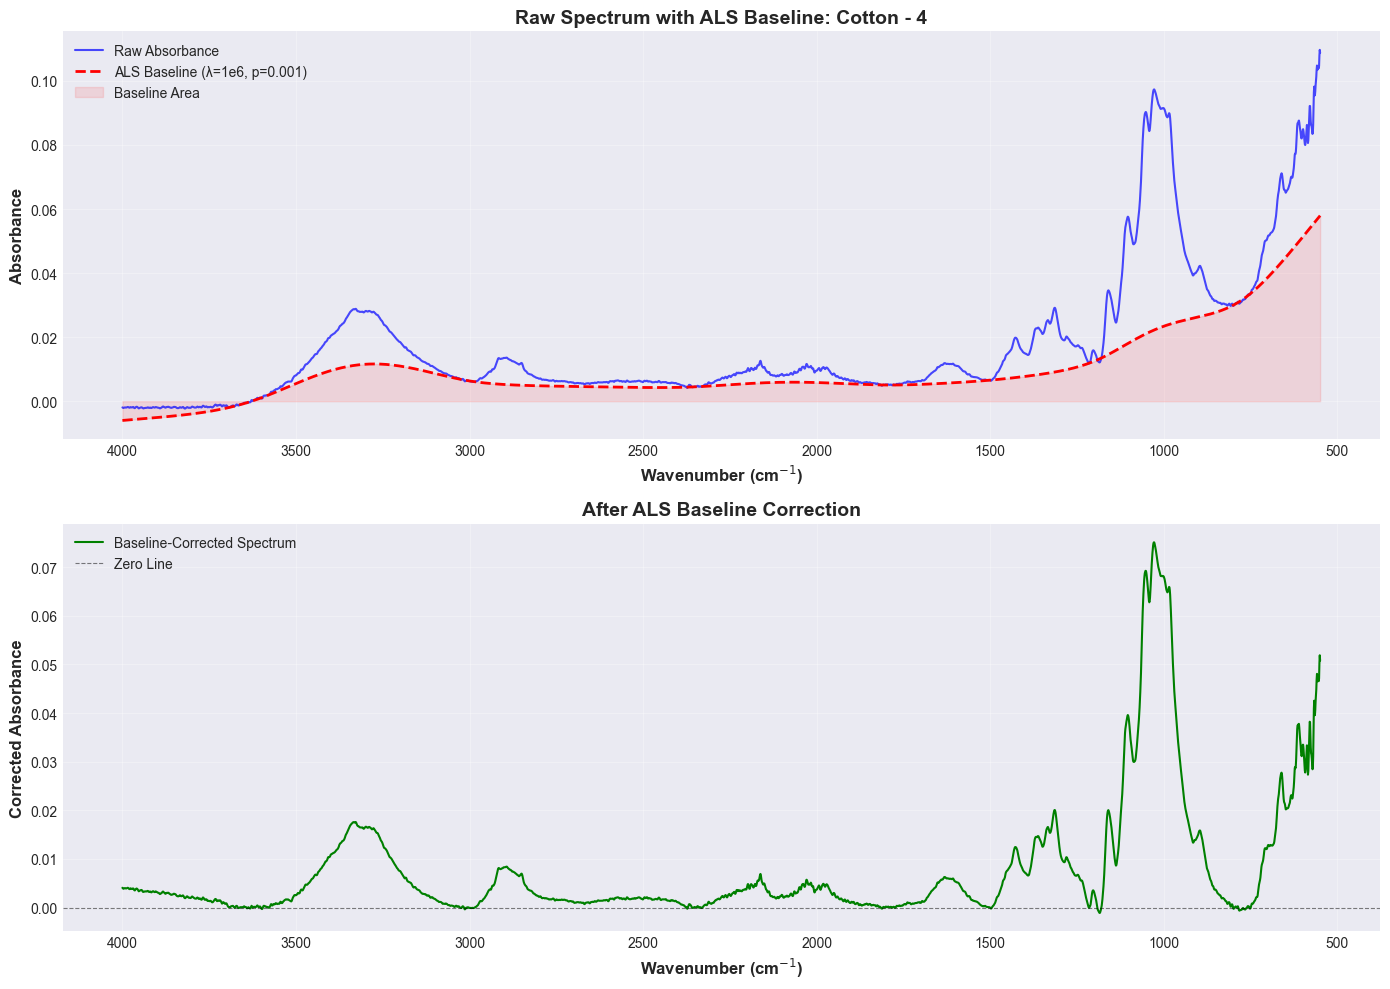


BASELINE CORRECTION RESULTS
Sample: Cotton - 4

Original Spectrum:
  Mean absorbance: 0.0174
  Std deviation:   0.0216
  Range:           -0.0023 to 0.1097

Baseline-Corrected Spectrum:
  Mean absorbance: 0.0077
  Std deviation:   0.0128
  Range:           -0.0011 to 0.0751

Baseline Statistics:
  Mean baseline:   0.0097
  Baseline slope:  -0.000019 per point


In [48]:
# Experiment 1: Apply ALS baseline correction to a sample spectrum
# Apply ALS baseline correction
baseline_als = als_baseline_correction(absorbance, lam=1e6, p=0.001)
corrected_als = absorbance - baseline_als

# Visualize the results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Show raw spectrum with fitted baseline
axes[0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0].plot(wavenumbers, baseline_als, 'r--', linewidth=2, label='ALS Baseline (λ=1e6, p=0.001)')
axes[0].fill_between(wavenumbers, 0, baseline_als, color='red', alpha=0.1, label='Baseline Area')
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absorbance', fontsize=12, fontweight='bold')
axes[0].set_title(f'Raw Spectrum with ALS Baseline: {sample_file.stem}', fontsize=14, fontweight='bold')
axes[0].invert_xaxis()
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Bottom plot: Show baseline-corrected spectrum
axes[1].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='Baseline-Corrected Spectrum')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Zero Line')
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Corrected Absorbance', fontsize=12, fontweight='bold')
axes[1].set_title('After ALS Baseline Correction', fontsize=14, fontweight='bold')
axes[1].invert_xaxis()
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\n{'='*70}")
print(f"BASELINE CORRECTION RESULTS")
print(f"{'='*70}")
print(f"Sample: {sample_file.stem}")
print(f"\nOriginal Spectrum:")
print(f"  Mean absorbance: {np.mean(absorbance):.4f}")
print(f"  Std deviation:   {np.std(absorbance):.4f}")
print(f"  Range:           {absorbance.min():.4f} to {absorbance.max():.4f}")

print(f"\nBaseline-Corrected Spectrum:")
print(f"  Mean absorbance: {np.mean(corrected_als):.4f}")
print(f"  Std deviation:   {np.std(corrected_als):.4f}")
print(f"  Range:           {corrected_als.min():.4f} to {corrected_als.max():.4f}")

print(f"\nBaseline Statistics:")
print(f"  Mean baseline:   {np.mean(baseline_als):.4f}")
print(f"  Baseline slope:  {(baseline_als[0] - baseline_als[-1]) / len(baseline_als):.6f} per point")
print(f"{'='*70}")

## Type 2: Polynomial Baseline Correction

### **What is Polynomial Baseline Correction?**
Polynomial baseline correction fits a polynomial function (degree 1-5) to the spectrum and subtracts it to remove baseline drift. It's simpler than ALS but less adaptive to complex baseline shapes.

### **How it works:**
1. Fit a polynomial (e.g., degree 2 or 3) to the entire spectrum
2. Subtract the fitted polynomial from the original spectrum
3. Result: Flattened baseline centered around zero

### **Key Parameter:**
- **degree**: Polynomial order (1=linear, 2=quadratic, 3=cubic, etc.)
  - **Lower degree (1-2)**: Good for gentle slopes
  - **Higher degree (3-5)**: Can model curved baselines
  - **Too high**: Risk of overfitting and removing peaks

### **Comparison with ALS:**
- **Polynomial**: Faster, simpler, global fit to entire spectrum
- **ALS**: More flexible, adapts locally, stays below peaks (better for most cases)

### **Reference:**
Lieber, C.A. & Mahadevan-Jansen, A. (2003). "Automated Method for Subtraction of Fluorescence from Biological Raman Spectra" - Applied Spectroscopy

In [49]:
def polynomial_baseline_correction(y, x=None, degree=2):
    """
    Polynomial baseline correction.
    
    Fits a polynomial to the spectrum and subtracts it to remove baseline drift.
    Simpler than ALS but less adaptive to complex baseline shapes.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    x : array-like, optional
        X-axis values (e.g., wavenumbers). If None, uses indices.
    degree : int
        Polynomial degree (1=linear, 2=quadratic, 3=cubic, etc.)
        Typical range: 1-5
        
    Returns:
    --------
    corrected : ndarray
        Baseline-corrected spectrum
    baseline : ndarray
        Fitted polynomial baseline
    """
    if x is None:
        x = np.arange(len(y))
    
    # Fit polynomial
    coefficients = np.polyfit(x, y, degree)
    baseline = np.polyval(coefficients, x)
    
    # Subtract baseline
    corrected = y - baseline
    
    return corrected, baseline

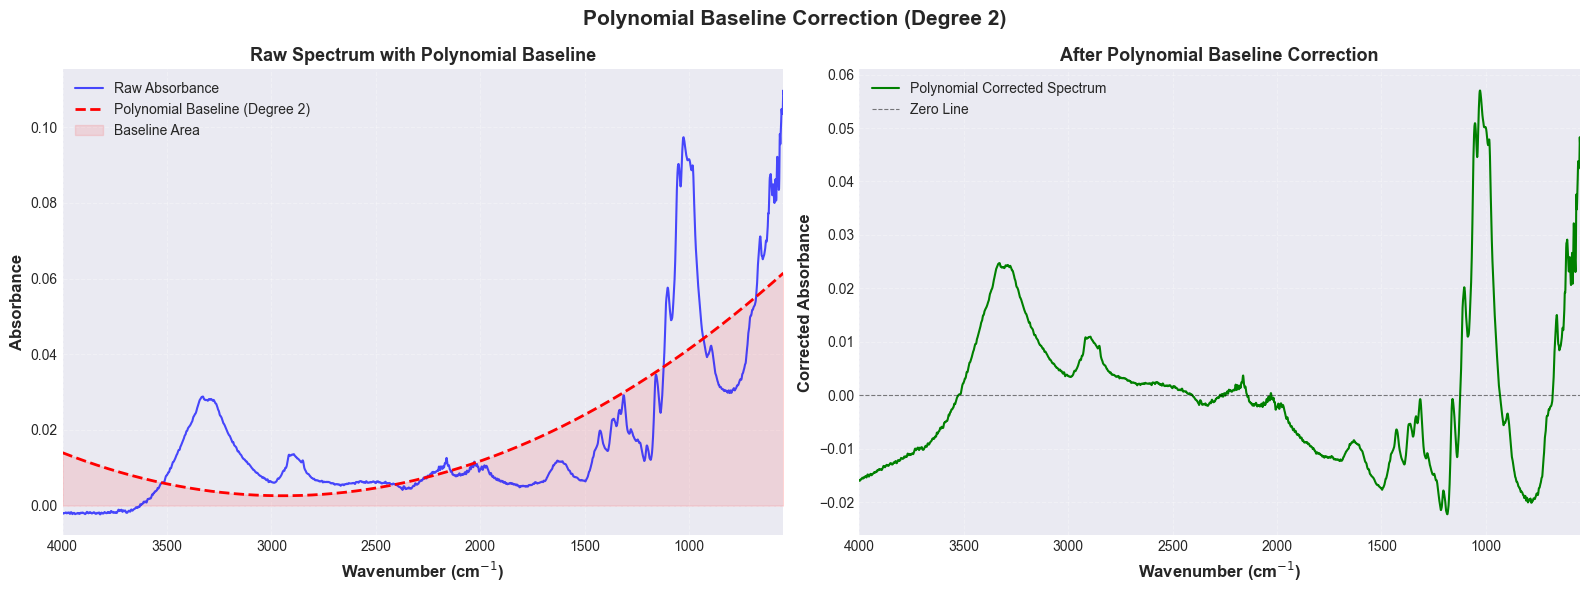


POLYNOMIAL BASELINE CORRECTION RESULTS
Sample: Cotton - 4

Original Spectrum:
  Mean absorbance: 0.0174
  Std deviation:   0.0216
  Range:           -0.0023 to 0.1097

Polynomial Baseline:
  Mean baseline:   0.0174
  Baseline range:  0.0026 to 0.0615

Corrected Spectrum:
  Mean absorbance: 0.0000
  Std deviation:   0.0140
  Range:           -0.0223 to 0.0570


In [50]:
# Apply polynomial baseline correction (degree 2)
corrected_poly, baseline_poly = polynomial_baseline_correction(absorbance, wavenumbers, degree=2)

# Create a 2-panel visualization for polynomial baseline correction
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Raw spectrum with fitted polynomial baseline
axes[0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0].plot(wavenumbers, baseline_poly, 'r--', linewidth=2, label='Polynomial Baseline (Degree 2)')
axes[0].fill_between(wavenumbers, 0, baseline_poly, color='red', alpha=0.1, label='Baseline Area')
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absorbance', fontsize=12, fontweight='bold')
axes[0].set_title('Raw Spectrum with Polynomial Baseline', fontsize=13, fontweight='bold')
axes[0].invert_xaxis()
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(4000, 550)

# Panel 2: Baseline-corrected spectrum
axes[1].plot(wavenumbers, corrected_poly, 'g-', linewidth=1.5, label='Polynomial Corrected Spectrum')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Zero Line')
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Corrected Absorbance', fontsize=12, fontweight='bold')
axes[1].set_title('After Polynomial Baseline Correction', fontsize=13, fontweight='bold')
axes[1].invert_xaxis()
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(4000, 550)

plt.suptitle('Polynomial Baseline Correction (Degree 2)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"POLYNOMIAL BASELINE CORRECTION RESULTS")
print(f"{'='*70}")
print(f"Sample: {sample_file.stem}")
print(f"\nOriginal Spectrum:")
print(f"  Mean absorbance: {np.mean(absorbance):.4f}")
print(f"  Std deviation:   {np.std(absorbance):.4f}")
print(f"  Range:           {absorbance.min():.4f} to {absorbance.max():.4f}")

print(f"\nPolynomial Baseline:")
print(f"  Mean baseline:   {np.mean(baseline_poly):.4f}")
print(f"  Baseline range:  {baseline_poly.min():.4f} to {baseline_poly.max():.4f}")

print(f"\nCorrected Spectrum:")
print(f"  Mean absorbance: {np.mean(corrected_poly):.4f}")
print(f"  Std deviation:   {np.std(corrected_poly):.4f}")
print(f"  Range:           {corrected_poly.min():.4f} to {corrected_poly.max():.4f}")
print(f"{'='*70}")



# Step 2: Scatter Correction Techniques

## Standard Normal Variate (SNV)

### **What is Multiplicative Scatter?**
When light passes through a sample, **physical properties** (not just chemical composition) affect the spectrum:
- **Particle size variations** → Different scattering intensities
- **Sample density differences** → Overall intensity shifts
- **Surface roughness** → Multiplicative scaling effects

These create **multiplicative scatter** - the entire spectrum is scaled up or down, making samples look different even if chemically identical.

### **How Does SNV Work?**
SNV standardizes each spectrum individually:
1. **Centers the spectrum**: Subtracts the mean → shifts to zero
2. **Scales to unit variance**: Divides by std deviation → standardizes intensity
3. **Result**: All spectra have mean=0, std=1

### **Formula:**
$$\text{SNV}(x) = \frac{x - \bar{x}}{\sigma_x}$$

Where:
- $x$ = original spectrum
- $\bar{x}$ = mean of spectrum
- $\sigma_x$ = standard deviation of spectrum

### **When to Use SNV:**
- ✅ **After baseline correction** (removes additive effects first)
- ✅ When samples have **different particle sizes** or **packing densities**
- ✅ For **classification tasks** (makes spectra comparable)
- ❌ For **quantitative analysis** (removes concentration information)

### **Reference:**
Barnes, R.J., Dhanoa, M.S., Lister, S.J. (1989). "Standard Normal Variate Transformation and De-trending of Near-Infrared Diffuse Reflectance Spectra"

In [51]:
def standard_normal_variate(spectrum):
    """
    Standard Normal Variate (SNV) transformation.
    
    Centers each spectrum to mean=0 and scales to std=1.
    Removes multiplicative scatter effects while preserving peak patterns.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    snv_spectrum : ndarray
        SNV-transformed spectrum
    """
    mean_val = np.mean(spectrum)
    std_val = np.std(spectrum)
    
    # Avoid division by zero
    if std_val == 0:
        return spectrum - mean_val
    
    snv_spectrum = (spectrum - mean_val) / std_val
    return snv_spectrum

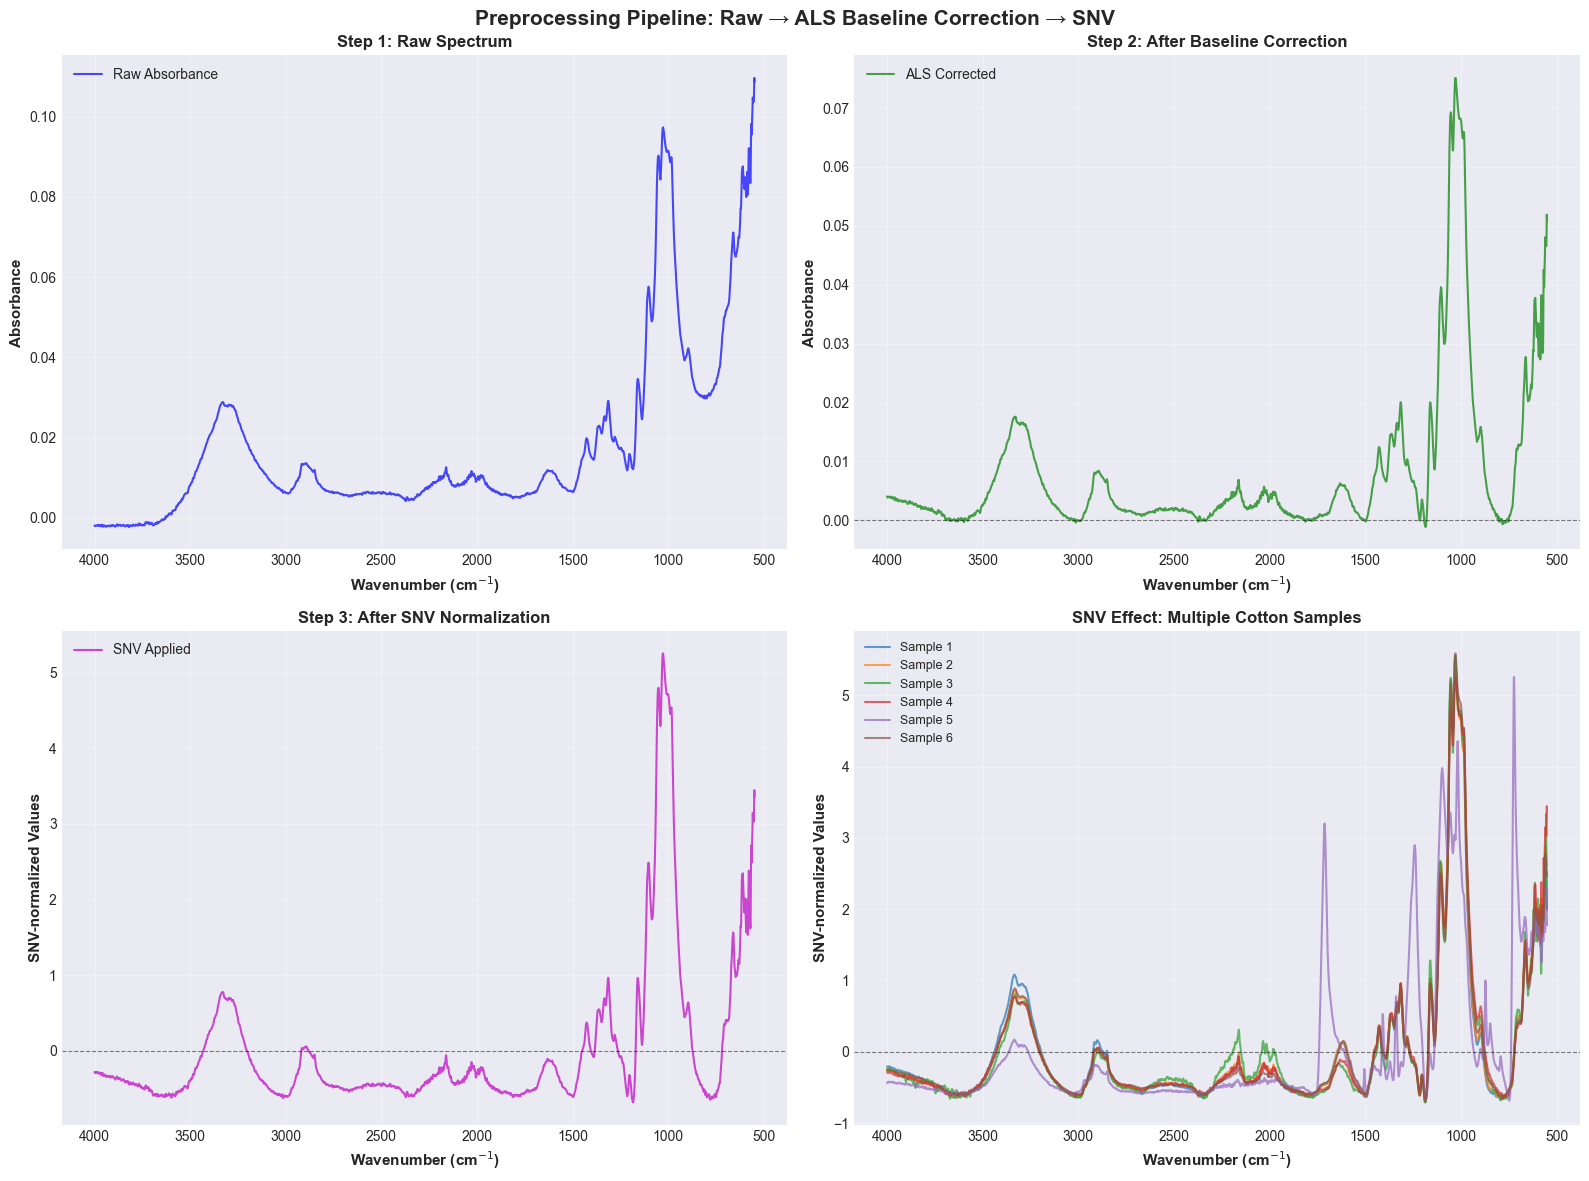


SNV TRANSFORMATION RESULTS

Before SNV (ALS-corrected):
  Mean: 0.0077
  Std:  0.0128
  Min:  -0.0011
  Max:  0.0751

After SNV:
  Mean: 0.000000  ← Should be ~0
  Std:  1.000000  ← Should be ~1
  Min:  -0.6846
  Max:  5.2527


In [52]:
# Experiment 2: Apply SNV to baseline-corrected spectrum
# Apply SNV to the ALS-corrected spectrum from previous step
snv_spectrum = standard_normal_variate(corrected_als)

# Let's also load and process multiple Cotton samples to see SNV effect
cotton_files = [f for f in csv_files if 'Cotton' in f.stem]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Compare original vs baseline-corrected vs SNV for single sample
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Step 1: Raw Spectrum', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='ALS Corrected', alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Step 2: After Baseline Correction', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(wavenumbers, snv_spectrum, 'm-', linewidth=1.5, label='SNV Applied', alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Step 3: After SNV Normalization', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Show effect of SNV on multiple samples (within-class variability reduction)
axes[1, 1].set_title('SNV Effect: Multiple Cotton Samples', fontsize=12, fontweight='bold')

# Process all Cotton samples and show before/after SNV
for idx, cotton_file in enumerate(cotton_files):
    df = pd.read_csv(cotton_file, skiprows=1, header=0)
    wn = df['cm-1'].values
    trans = df['%T'].values
    abs_raw = 2 - np.log10(trans + 1e-9)
    
    # Apply ALS then SNV
    baseline = als_baseline_correction(abs_raw, lam=1e6, p=0.001)
    corrected = abs_raw - baseline
    snv = standard_normal_variate(corrected)
    
    # Plot SNV-normalized
    axes[1, 1].plot(wn, snv, linewidth=1.5, label=f'Sample {idx+1}', alpha=0.7)

axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Preprocessing Pipeline: Raw → ALS Baseline Correction → SNV', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print(f"\n{'='*70}")
print(f"SNV TRANSFORMATION RESULTS")
print(f"{'='*70}")
print(f"\nBefore SNV (ALS-corrected):")
print(f"  Mean: {np.mean(corrected_als):.4f}")
print(f"  Std:  {np.std(corrected_als):.4f}")
print(f"  Min:  {corrected_als.min():.4f}")
print(f"  Max:  {corrected_als.max():.4f}")

print(f"\nAfter SNV:")
print(f"  Mean: {np.mean(snv_spectrum):.6f}  ← Should be ~0")
print(f"  Std:  {np.std(snv_spectrum):.6f}  ← Should be ~1")
print(f"  Min:  {snv_spectrum.min():.4f}")
print(f"  Max:  {snv_spectrum.max():.4f}")

### SNV Applied Directly to Raw Absorbance (Without Baseline Correction) & Comparison with ALS-corrected

Sometimes it's useful to apply SNV directly to raw absorbance without baseline correction first. This approach:
- Standardizes intensity variations immediately
- Preserves the original baseline structure
- Can be faster for quick exploratory analysis
- Useful when baseline shifts are minimal

However, for best results, ALS baseline correction followed by SNV is generally recommended.

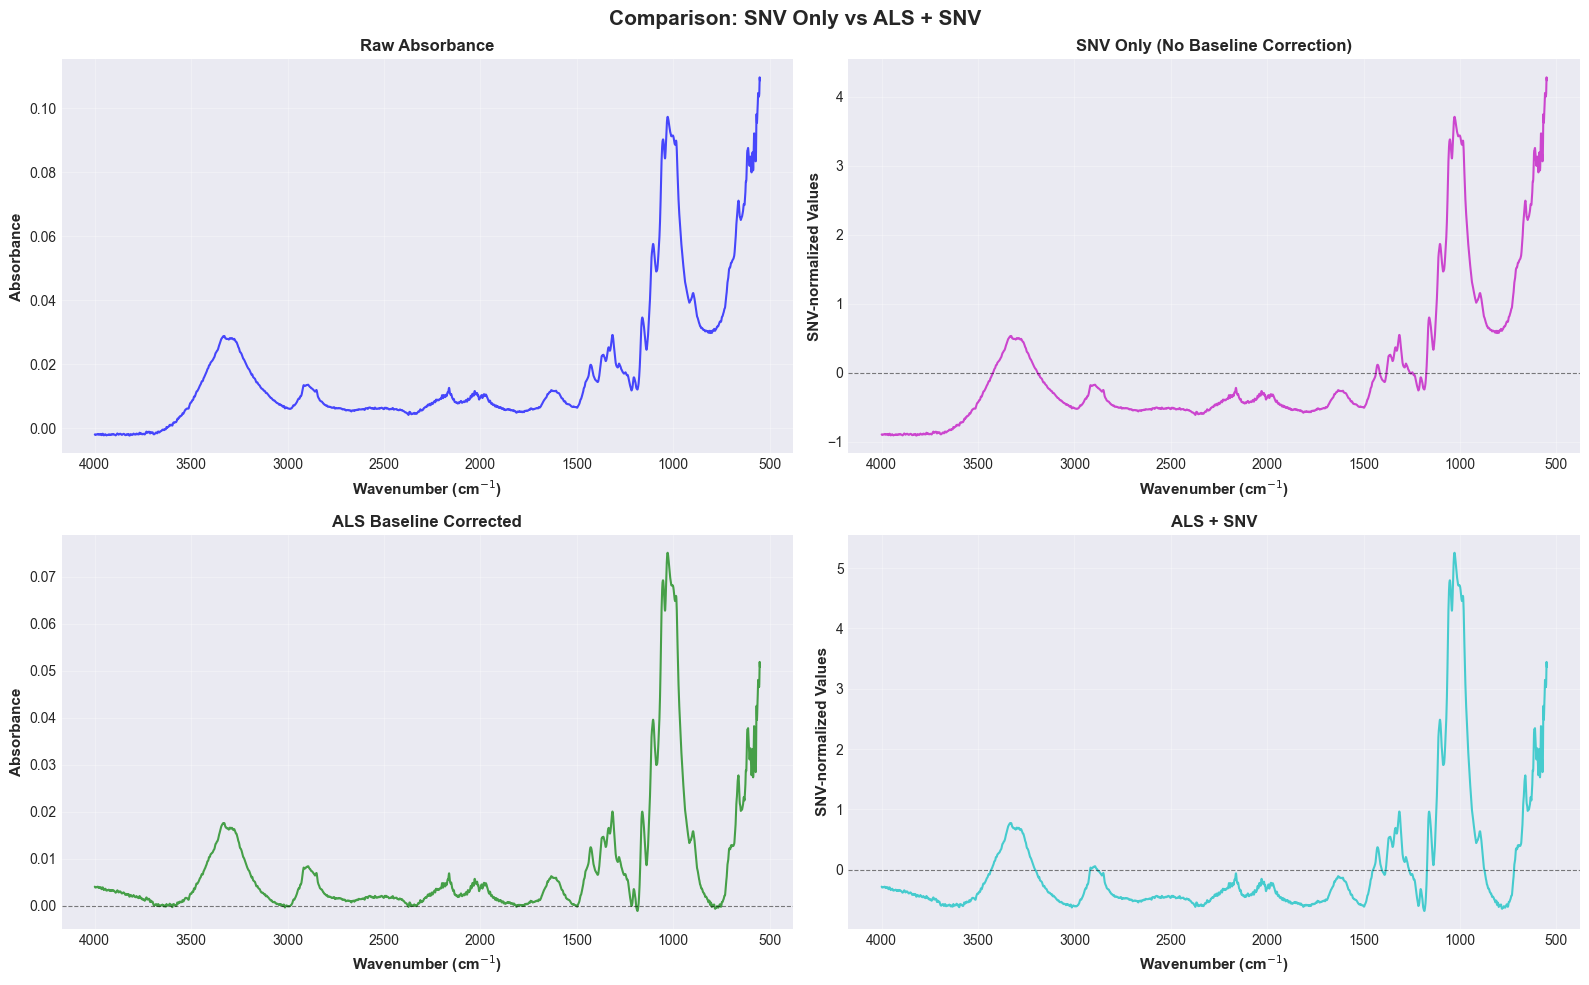


SNV COMPARISON: Raw vs Baseline-Corrected

SNV on Raw Absorbance:
  Mean: -0.000000
  Std:  1.000000
  Min:  -0.9128
  Max:  4.2775

SNV on Baseline-Corrected:
  Mean: 0.000000
  Std:  1.000000
  Min:  -0.6846
  Max:  5.2527

Note: Both methods standardize to mean~0, std~1, but ALS+SNV
      removes baseline drift first for better peak isolation.


In [53]:
# Apply SNV directly to raw absorbance (without baseline correction)
snv_raw = standard_normal_variate(absorbance)

# Visualize the difference between SNV with and without baseline correction
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Raw absorbance
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Raw Absorbance', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: SNV applied to raw absorbance
axes[0, 1].plot(wavenumbers, snv_raw, 'm-', linewidth=1.5, alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[0, 1].set_title('SNV Only (No Baseline Correction)', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Baseline-corrected spectrum
axes[1, 0].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ALS Baseline Corrected', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: SNV applied to baseline-corrected spectrum
axes[1, 1].plot(wavenumbers, snv_spectrum, 'c-', linewidth=1.5, alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].set_title('ALS + SNV', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Comparison: SNV Only vs ALS + SNV', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n{'='*70}")
print(f"SNV COMPARISON: Raw vs Baseline-Corrected")
print(f"{'='*70}")

print(f"\nSNV on Raw Absorbance:")
print(f"  Mean: {np.mean(snv_raw):.6f}")
print(f"  Std:  {np.std(snv_raw):.6f}")
print(f"  Min:  {snv_raw.min():.4f}")
print(f"  Max:  {snv_raw.max():.4f}")

print(f"\nSNV on Baseline-Corrected:")
print(f"  Mean: {np.mean(snv_spectrum):.6f}")
print(f"  Std:  {np.std(snv_spectrum):.6f}")
print(f"  Min:  {snv_spectrum.min():.4f}")
print(f"  Max:  {snv_spectrum.max():.4f}")

print(f"\nNote: Both methods standardize to mean~0, std~1, but ALS+SNV")
print(f"      removes baseline drift first for better peak isolation.")
print(f"{'='*70}")

### SNV applied to Polynomial corrected spectrum

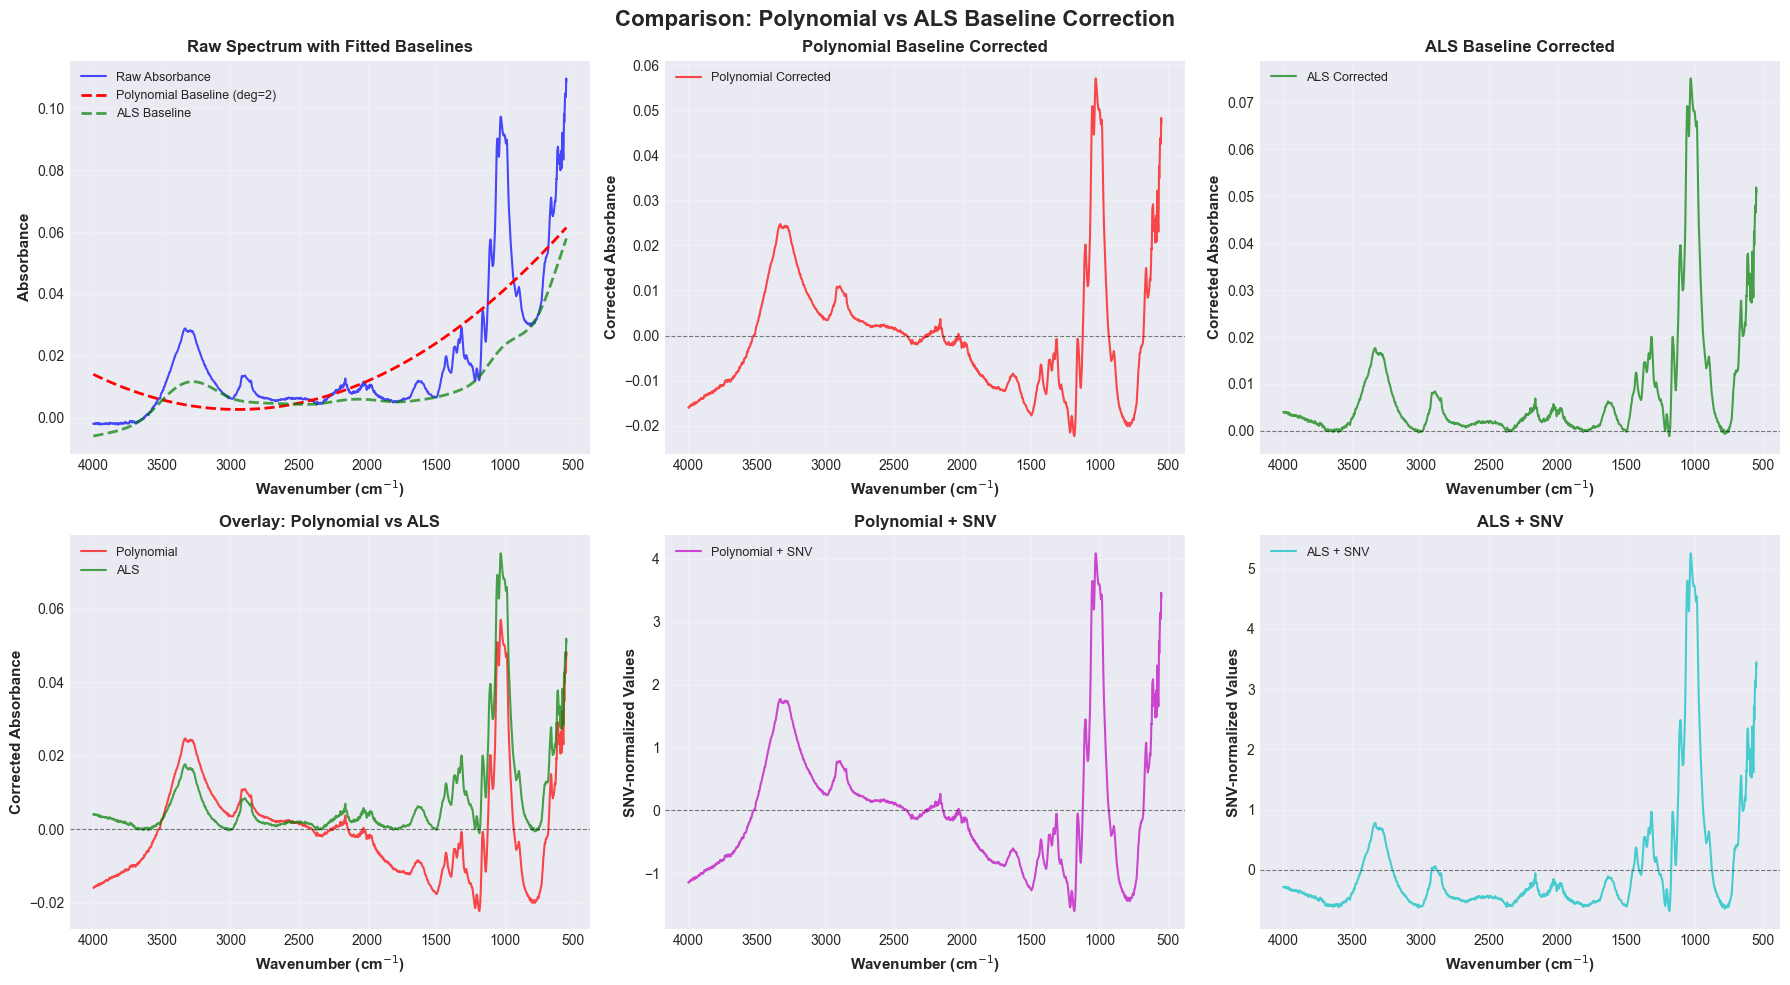


POLYNOMIAL vs ALS BASELINE CORRECTION COMPARISON

Polynomial Baseline Correction (degree=2):
  Corrected Mean: 0.0000
  Corrected Std:  0.0140
  Baseline Mean:  0.0174

ALS Baseline Correction:
  Corrected Mean: 0.0077
  Corrected Std:  0.0128
  Baseline Mean:  0.0097

After SNV Normalization:
  Polynomial + SNV: Mean=0.000000, Std=1.000000
  ALS + SNV:        Mean=0.000000, Std=1.000000


In [54]:
# Apply SNV to polynomial-corrected spectrum
snv_poly = standard_normal_variate(corrected_poly)

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Baseline correction comparison
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0, 0].plot(wavenumbers, baseline_poly, 'r--', linewidth=2, label='Polynomial Baseline (deg=2)')
axes[0, 0].plot(wavenumbers, baseline_als, 'g--', linewidth=2, label='ALS Baseline', alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Raw Spectrum with Fitted Baselines', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(wavenumbers, corrected_poly, 'r-', linewidth=1.5, label='Polynomial Corrected', alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Polynomial Baseline Corrected', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='ALS Corrected', alpha=0.7)
axes[0, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[0, 2].set_title('ALS Baseline Corrected', fontsize=12, fontweight='bold')
axes[0, 2].invert_xaxis()
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: With SNV normalization
axes[1, 0].plot(wavenumbers, corrected_poly, 'r-', linewidth=1.5, alpha=0.7)
axes[1, 0].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Overlay: Polynomial vs ALS', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend(['Polynomial', 'ALS'], fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(wavenumbers, snv_poly, 'm-', linewidth=1.5, label='Polynomial + SNV', alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Polynomial + SNV', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(wavenumbers, snv_spectrum, 'c-', linewidth=1.5, label='ALS + SNV', alpha=0.7)
axes[1, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 2].set_title('ALS + SNV', fontsize=12, fontweight='bold')
axes[1, 2].invert_xaxis()
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Comparison: Polynomial vs ALS Baseline Correction', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n{'='*80}")
print(f"POLYNOMIAL vs ALS BASELINE CORRECTION COMPARISON")
print(f"{'='*80}")

print(f"\nPolynomial Baseline Correction (degree=2):")
print(f"  Corrected Mean: {np.mean(corrected_poly):.4f}")
print(f"  Corrected Std:  {np.std(corrected_poly):.4f}")
print(f"  Baseline Mean:  {np.mean(baseline_poly):.4f}")

print(f"\nALS Baseline Correction:")
print(f"  Corrected Mean: {np.mean(corrected_als):.4f}")
print(f"  Corrected Std:  {np.std(corrected_als):.4f}")
print(f"  Baseline Mean:  {np.mean(baseline_als):.4f}")

print(f"\nAfter SNV Normalization:")
print(f"  Polynomial + SNV: Mean={np.mean(snv_poly):.6f}, Std={np.std(snv_poly):.6f}")
print(f"  ALS + SNV:        Mean={np.mean(snv_spectrum):.6f}, Std={np.std(snv_spectrum):.6f}")

##  - Scatter Correction Type 2: Multiplicative Scatter Correction (MSC)

### **What is MSC?**
Multiplicative Scatter Correction (MSC) is another powerful technique for removing scatter effects from spectral data. Unlike SNV (which standardizes each spectrum individually), MSC uses a **reference spectrum** to correct all samples.

### **The Physical Problem:**
When analyzing textile samples with ATR-FTIR:
- **Surface texture variations** cause different light scattering
- **Sample-to-sample contact pressure** affects intensity
- **Particle size differences** create multiplicative effects

These create **multiplicative scatter** - spectra are scaled and shifted versions of the true chemical spectrum.

### **How Does MSC Work?**
MSC performs a linear regression for each spectrum against a reference spectrum:

$$y_i = a_i + b_i \cdot y_{ref} + e_i$$

Where:
- $y_i$ = spectrum to be corrected
- $y_{ref}$ = reference spectrum (typically the mean of all spectra)
- $a_i$ = additive offset (scatter baseline shift)
- $b_i$ = multiplicative slope (scatter scaling)
- $e_i$ = residual (true chemical variation)

The corrected spectrum is:
$$y_{corrected} = \frac{y_i - a_i}{b_i}$$

### **MSC vs SNV:**

| Aspect | MSC | SNV |
|--------|-----|-----|
| **Approach** | Uses reference spectrum (population-based) | Individual spectrum standardization |
| **Requires** | Multiple samples to compute mean | Works on single spectrum |
| **Best for** | Calibration transfer, population studies | Quick normalization, single samples |
| **Preserves** | Relative chemical differences to reference | Statistical distribution |

### **When to Use MSC:**
- ✅ **After baseline correction** (like SNV)
- ✅ When you have a **representative reference spectrum** (mean of dataset)
- ✅ For **between-sample comparisons** within a dataset
- ✅ When building **calibration models** that need population consistency
- ❌ For **single spectrum analysis** without a reference

### **Reference:**
Geladi, P., MacDougall, D., Martens, H. (1985). "Linearization and Scatter-Correction for Near-Infrared Reflectance Spectra of Meat" - Applied Spectroscopy

Martens, H. & Naes, T. (1989). "Multivariate Calibration" - Wiley

In [55]:
def multiplicative_scatter_correction(spectra, reference=None):
    """
    Multiplicative Scatter Correction (MSC).
    
    Corrects scatter effects by linear regression against a reference spectrum.
    Each spectrum is modeled as: y = a + b*reference + residual
    Corrected spectrum: (y - a) / b
    
    Parameters:
    -----------
    spectra : ndarray
        Input spectra (can be 1D or 2D array)
        - If 1D: single spectrum (shape: n_wavelengths)
        - If 2D: multiple spectra (shape: n_samples x n_wavelengths)
    reference : ndarray, optional
        Reference spectrum. If None, uses mean of all spectra.
        
    Returns:
    --------
    corrected : ndarray
        MSC-corrected spectra (same shape as input)
    """
    # Handle 1D input
    if spectra.ndim == 1:
        spectra = spectra.reshape(1, -1)
        single_spectrum = True
    else:
        single_spectrum = False
    
    # Compute reference spectrum (mean of all spectra)
    if reference is None:
        reference = np.mean(spectra, axis=0)
    
    # Initialize corrected spectra
    corrected = np.zeros_like(spectra)
    
    # Apply MSC to each spectrum
    for i in range(spectra.shape[0]):
        # Linear regression: spectrum = a + b * reference
        fit = np.polyfit(reference, spectra[i, :], 1)
        # fit[0] = slope (b), fit[1] = intercept (a)
        # Corrected spectrum: (spectrum - a) / b
        corrected[i, :] = (spectra[i, :] - fit[1]) / fit[0]
    
    # Return in original shape
    if single_spectrum:
        return corrected.flatten()
    else:
        return corrected

### For all Cotton samples -> SNV v/s MSC

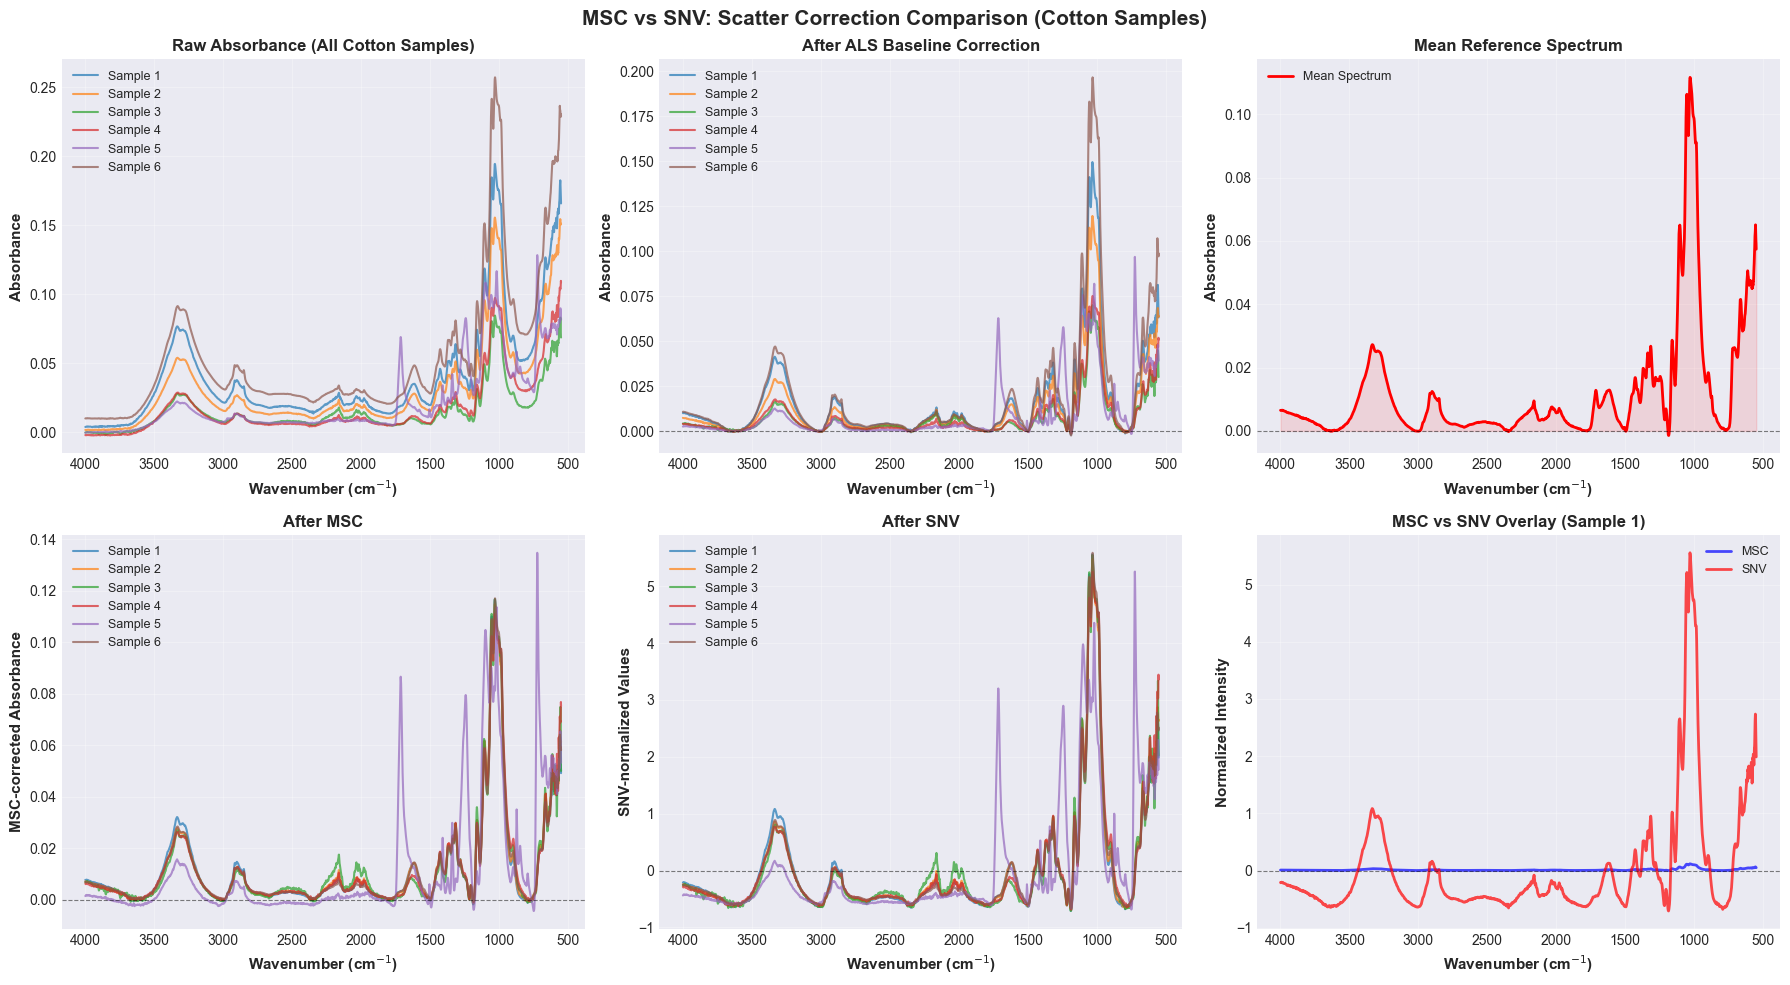


MSC vs SNV COMPARISON

Baseline-Corrected Spectra:
  Mean across samples: 0.0117
  Std across samples:  0.0054
  Between-sample variance: 0.0001

After MSC:
  Mean across samples: 0.0117
  Std across samples:  0.0035
  Between-sample variance: 0.0000

After SNV:
  Mean across samples: 0.000000
  Std across samples:  0.1546
  Between-sample variance: 0.0766


In [56]:
# Apply MSC to Cotton samples to demonstrate the technique
cotton_files = [f for f in csv_files if 'Cotton' in f.stem]

# Load all Cotton samples and apply ALS baseline correction
cotton_spectra = []
for cotton_file in cotton_files:
    df = pd.read_csv(cotton_file, skiprows=1, header=0)
    trans = df['%T'].values
    abs_spec = 2 - np.log10(trans + 1e-9)
    baseline = als_baseline_correction(abs_spec, lam=1e6, p=0.001)
    corrected = abs_spec - baseline
    cotton_spectra.append(corrected)

cotton_spectra = np.array(cotton_spectra)

# Apply MSC
cotton_msc = multiplicative_scatter_correction(cotton_spectra)

# Apply SNV for comparison
cotton_snv = np.array([standard_normal_variate(spec) for spec in cotton_spectra])

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Before corrections
axes[0, 0].set_title('Raw Absorbance (All Cotton Samples)', fontsize=12, fontweight='bold')
for i, cotton_file in enumerate(cotton_files):
    df = pd.read_csv(cotton_file, skiprows=1, header=0)
    wn = df['cm-1'].values
    trans = df['%T'].values
    abs_raw = 2 - np.log10(trans + 1e-9)
    axes[0, 0].plot(wn, abs_raw, linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# After baseline correction
axes[0, 1].set_title('After ALS Baseline Correction', fontsize=12, fontweight='bold')
for i in range(len(cotton_spectra)):
    axes[0, 1].plot(wn, cotton_spectra[i], linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Compute mean spectrum for reference
mean_spectrum = np.mean(cotton_spectra, axis=0)
axes[0, 2].set_title('Mean Reference Spectrum', fontsize=12, fontweight='bold')
axes[0, 2].plot(wn, mean_spectrum, 'r-', linewidth=2, label='Mean Spectrum')
axes[0, 2].fill_between(wn, 0, mean_spectrum, color='red', alpha=0.1)
axes[0, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 2].invert_xaxis()
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: After scatter corrections
axes[1, 0].set_title('After MSC', fontsize=12, fontweight='bold')
for i in range(len(cotton_msc)):
    axes[1, 0].plot(wn, cotton_msc[i], linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('MSC-corrected Absorbance', fontsize=11, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('After SNV', fontsize=12, fontweight='bold')
for i in range(len(cotton_snv)):
    axes[1, 1].plot(wn, cotton_snv[i], linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

# Overlay comparison
axes[1, 2].set_title('MSC vs SNV Overlay (Sample 1)', fontsize=12, fontweight='bold')
axes[1, 2].plot(wn, cotton_msc[0], 'b-', linewidth=2, alpha=0.7, label='MSC')
axes[1, 2].plot(wn, cotton_snv[0], 'r-', linewidth=2, alpha=0.7, label='SNV')
axes[1, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Normalized Intensity', fontsize=11, fontweight='bold')
axes[1, 2].invert_xaxis()
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('MSC vs SNV: Scatter Correction Comparison (Cotton Samples)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print(f"\n{'='*70}")
print(f"MSC vs SNV COMPARISON")
print(f"{'='*70}")

print(f"\nBaseline-Corrected Spectra:")
print(f"  Mean across samples: {np.mean(cotton_spectra, axis=0).mean():.4f}")
print(f"  Std across samples:  {np.std(cotton_spectra, axis=0).mean():.4f}")
print(f"  Between-sample variance: {np.var(cotton_spectra, axis=0).mean():.4f}")

print(f"\nAfter MSC:")
print(f"  Mean across samples: {np.mean(cotton_msc, axis=0).mean():.4f}")
print(f"  Std across samples:  {np.std(cotton_msc, axis=0).mean():.4f}")
print(f"  Between-sample variance: {np.var(cotton_msc, axis=0).mean():.4f}")

print(f"\nAfter SNV:")
print(f"  Mean across samples: {np.mean(cotton_snv, axis=0).mean():.6f}")
print(f"  Std across samples:  {np.std(cotton_snv, axis=0).mean():.4f}")
print(f"  Between-sample variance: {np.var(cotton_snv, axis=0).mean():.4f}")

- MSC centers spectra around the mean reference
- SNV standardizes each spectrum individually
- Lower between-sample variance = better within-class consistency

# Step 3: Peak Enhancement

## Savitzky-Golay Derivatives 

### **Why Use Derivatives?**
Spectral derivatives are powerful tools that:
1. **Remove baseline effects** - Any polynomial baseline becomes zero after differentiation
2. **Resolve overlapping peaks** - Separate closely spaced absorption bands
3. **Enhance subtle features** - Amplify small spectral differences
4. **Reduce systematic variations** - Focus on local changes rather than absolute intensities

### **What is Savitzky-Golay Filtering?**
Instead of simple numerical differentiation (which amplifies noise), Savitzky-Golay:
- Fits a **polynomial** to a moving window of data points
- Computes the derivative of the **fitted polynomial** (not raw data)
- Result: **Smooth derivatives** that preserve peak shapes

### **1st Derivative:**
- **Physical meaning**: Rate of change of absorbance
- **Visual effect**: Peaks become **S-shaped curves** (rising then falling)
- **Zero crossings**: Occur at original peak maxima
- **Applications**: Baseline removal, peak detection, overlapping peak separation

### **2nd Derivative:**
- **Physical meaning**: Curvature of the spectrum
- **Visual effect**: Peaks become **inverted V-shapes** (negative peaks)
- **Minima**: Occur at original peak maxima
- **Applications**: Even better peak resolution, subtle feature detection

### **Key Parameters:**
- **window_length**: Number of points in the smoothing window (must be odd)
  - **Larger** = more smoothing, less noise, but can blur narrow peaks
  - **Smaller** = less smoothing, more noise, better peak resolution
  - Typical: 5-21 points
  
- **polyorder**: Polynomial degree for fitting
  - Typical: 2-4 (cubic or quadratic)
  - Higher order can overfit

### **Important Note:**
⚠️ Derivatives amplify **high-frequency noise**. Always apply smoothing (via proper window_length selection) or pre-smooth your data.

### **Reference:**
Savitzky, A. & Golay, M.J.E. (1964). "Smoothing and Differentiation of Data by Simplified Least Squares Procedures"

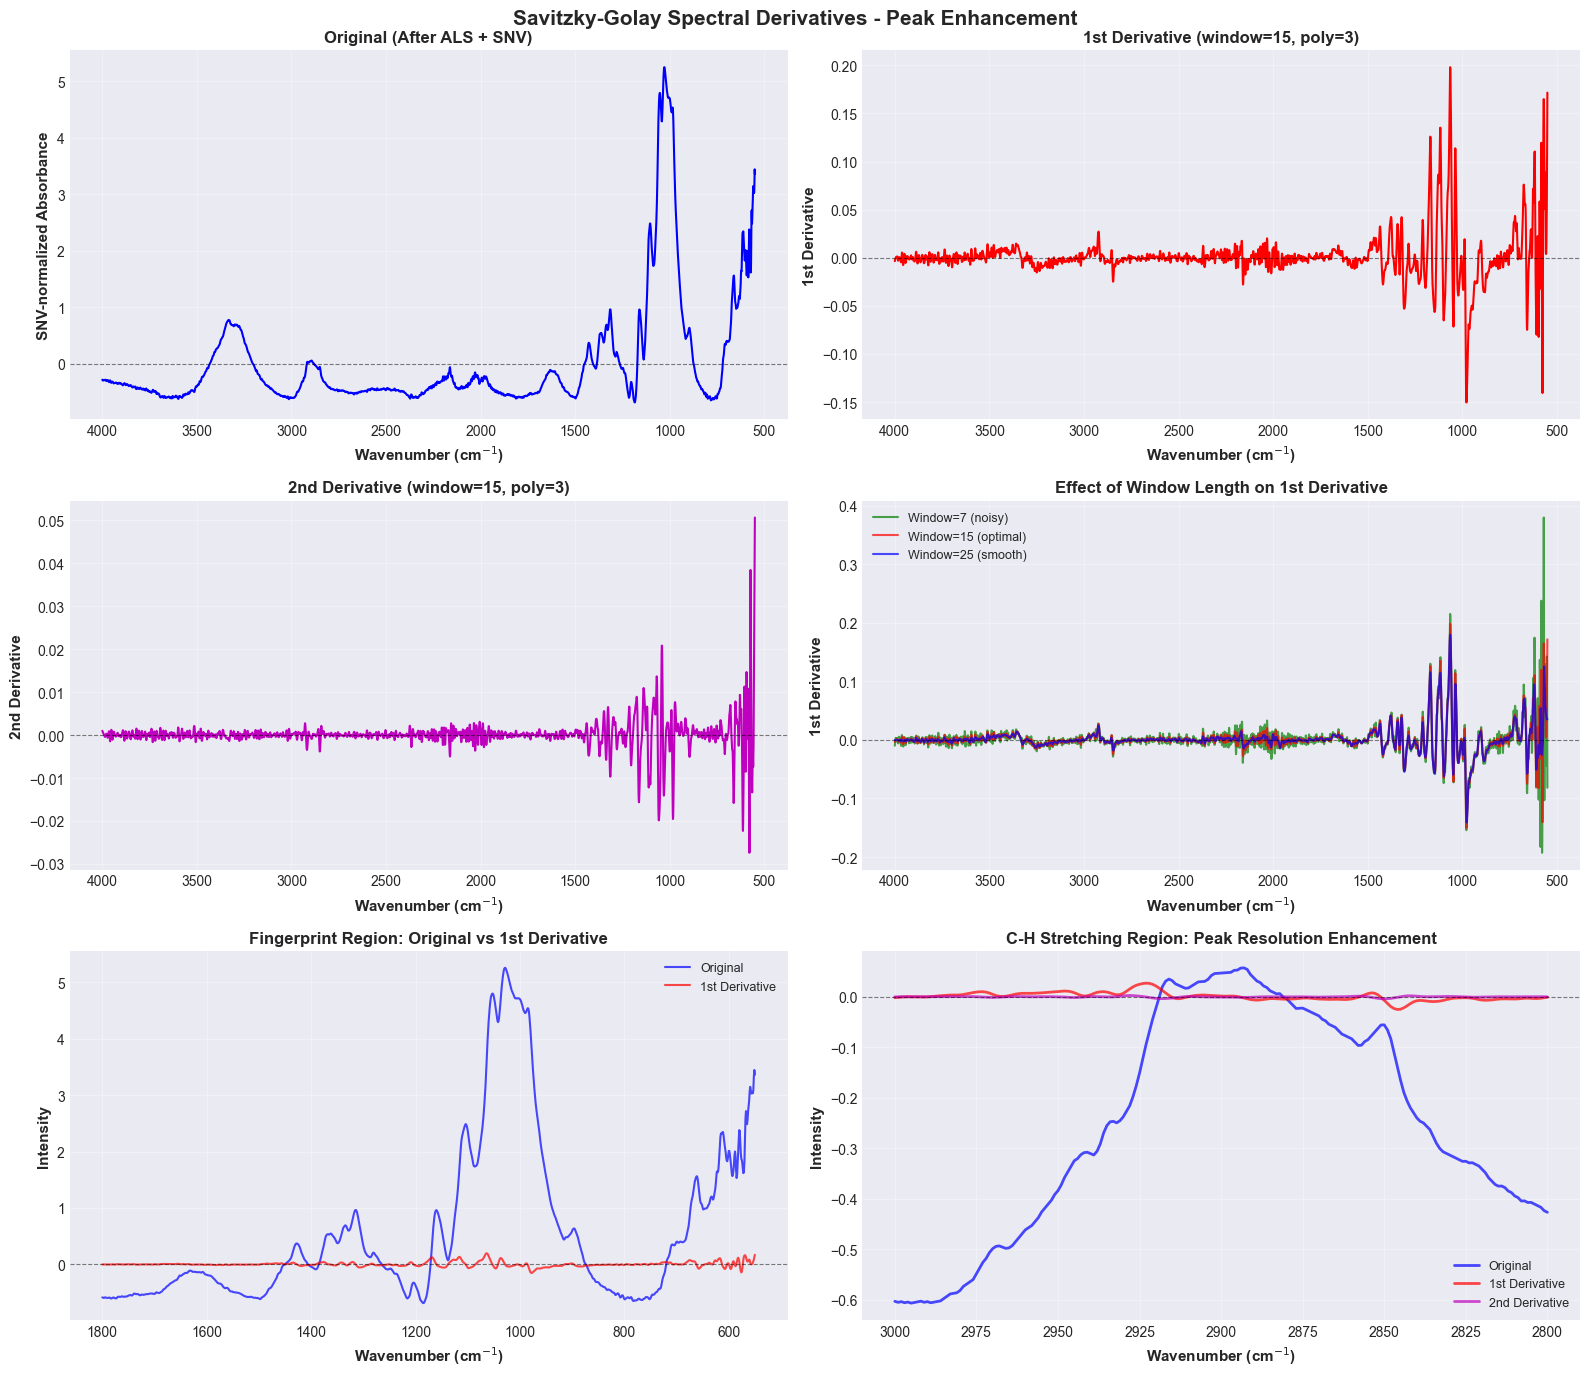


SPECTRAL DERIVATIVES ANALYSIS

Original Spectrum (SNV-normalized):
  Range: -0.6846 to 5.2527
  Std:   1.0000

1st Derivative:
  Range: -0.1504 to 0.1980
  Std:   0.0249
  Zero crossings: 303 (indicates peak positions)

2nd Derivative:
  Range: -0.0274 to 0.0506
  Std:   0.0036
  Minima count: 277 (indicates sharp peaks)


In [57]:
# Experiment 3: Apply Savitzky-Golay derivatives
# We'll use the SNV-normalized spectrum from the previous step

# Apply 1st derivative
deriv1 = savgol_filter(snv_spectrum, window_length=15, polyorder=3, deriv=1)

# Apply 2nd derivative
deriv2 = savgol_filter(snv_spectrum, window_length=15, polyorder=3, deriv=2)

# Also compute derivatives at different window sizes to show the effect
deriv1_small = savgol_filter(snv_spectrum, window_length=7, polyorder=3, deriv=1)
deriv1_large = savgol_filter(snv_spectrum, window_length=25, polyorder=3, deriv=1)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1: Original SNV spectrum
axes[0, 0].plot(wavenumbers, snv_spectrum, 'b-', linewidth=1.5)
axes[0, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('SNV-normalized Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Original (After ALS + SNV)', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: 1st Derivative
axes[0, 1].plot(wavenumbers, deriv1, 'r-', linewidth=1.5)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[0, 1].set_title('1st Derivative (window=15, poly=3)', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: 2nd Derivative
axes[1, 0].plot(wavenumbers, deriv2, 'm-', linewidth=1.5)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('2nd Derivative', fontsize=11, fontweight='bold')
axes[1, 0].set_title('2nd Derivative (window=15, poly=3)', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Comparing different window lengths for 1st derivative
axes[1, 1].plot(wavenumbers, deriv1_small, 'g-', linewidth=1.5, label='Window=7 (noisy)', alpha=0.7)
axes[1, 1].plot(wavenumbers, deriv1, 'r-', linewidth=1.5, label='Window=15 (optimal)', alpha=0.7)
axes[1, 1].plot(wavenumbers, deriv1_large, 'b-', linewidth=1.5, label='Window=25 (smooth)', alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Effect of Window Length on 1st Derivative', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Fingerprint region comparison (1800-550 cm⁻¹)
fingerprint_mask = (wavenumbers >= 550) & (wavenumbers <= 1800)
axes[2, 0].plot(wavenumbers[fingerprint_mask], snv_spectrum[fingerprint_mask], 
                'b-', linewidth=1.5, label='Original', alpha=0.7)
axes[2, 0].plot(wavenumbers[fingerprint_mask], deriv1[fingerprint_mask], 
                'r-', linewidth=1.5, label='1st Derivative', alpha=0.7)
axes[2, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Intensity', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Fingerprint Region: Original vs 1st Derivative', fontsize=12, fontweight='bold')
axes[2, 0].invert_xaxis()
axes[2, 0].legend(fontsize=9)
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Show how derivatives resolve overlapping peaks
# Focus on C-H stretching region (3000-2800 cm⁻¹)
ch_mask = (wavenumbers >= 2800) & (wavenumbers <= 3000)
axes[2, 1].plot(wavenumbers[ch_mask], snv_spectrum[ch_mask], 
                'b-', linewidth=2, label='Original', alpha=0.7)
axes[2, 1].plot(wavenumbers[ch_mask], deriv1[ch_mask], 
                'r-', linewidth=2, label='1st Derivative', alpha=0.7)
axes[2, 1].plot(wavenumbers[ch_mask], deriv2[ch_mask], 
                'm-', linewidth=2, label='2nd Derivative', alpha=0.7)
axes[2, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[2, 1].set_ylabel('Intensity', fontsize=11, fontweight='bold')
axes[2, 1].set_title('C-H Stretching Region: Peak Resolution Enhancement', fontsize=12, fontweight='bold')
axes[2, 1].invert_xaxis()
axes[2, 1].legend(fontsize=9)
axes[2, 1].grid(True, alpha=0.3)

plt.suptitle('Savitzky-Golay Spectral Derivatives - Peak Enhancement', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"SPECTRAL DERIVATIVES ANALYSIS")
print(f"{'='*70}")

print(f"\nOriginal Spectrum (SNV-normalized):")
print(f"  Range: {snv_spectrum.min():.4f} to {snv_spectrum.max():.4f}")
print(f"  Std:   {np.std(snv_spectrum):.4f}")

print(f"\n1st Derivative:")
print(f"  Range: {deriv1.min():.4f} to {deriv1.max():.4f}")
print(f"  Std:   {np.std(deriv1):.4f}")
print(f"  Zero crossings: {np.sum(np.diff(np.sign(deriv1)) != 0)} (indicates peak positions)")

print(f"\n2nd Derivative:")
print(f"  Range: {deriv2.min():.4f} to {deriv2.max():.4f}")
print(f"  Std:   {np.std(deriv2):.4f}")
print(f"  Minima count: {np.sum(np.diff(np.sign(np.diff(deriv2))) > 0)} (indicates sharp peaks)")

# Step 4: Normalization Techniques

Normalization techniques scale spectra to a common range or magnitude, ensuring that all samples are on a comparable scale. This is particularly important for machine learning algorithms that are sensitive to feature magnitudes.

### **Why Normalize Spectra?**
After baseline correction and scatter correction, spectra may still have:
- **Different overall intensity scales** due to concentration variations
- **Variable total absorbance** from sample-to-sample differences
- **Different dynamic ranges** that can bias ML models

Normalization addresses these issues by:
- Standardizing intensity ranges across all samples
- Making spectra directly comparable
- Improving ML model convergence and performance
- Reducing sensitivity to concentration differences

### **Three Common Normalization Methods:**

#### **1. Min-Max Normalization (Range Scaling)**
Scales each spectrum to a fixed range [0, 1]:

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

- **Pros**: Simple, preserves zero values, bounded range
- **Cons**: Sensitive to outliers (extreme max/min)
- **Use case**: When you need all values in [0, 1] range

#### **2. Vector Normalization (L2 Normalization)**
Scales each spectrum to unit length:

$$x_{norm} = \frac{x}{||x||_2} = \frac{x}{\sqrt{\sum x_i^2}}$$

- **Pros**: Focuses on spectral shape, not magnitude
- **Cons**: Loses absolute intensity information
- **Use case**: Classification tasks where shape matters more than intensity

#### **3. L1 Normalization**
Scales so sum of absolute values equals 1:

$$x_{norm} = \frac{x}{\sum |x_i|}$$

- **Pros**: Interpretable as proportions, robust to outliers
- **Cons**: Not as common in spectroscopy
- **Use case**: Compositional data analysis

### **When to Apply Normalization:**
- ✅ **After** baseline correction, scatter correction, and smoothing
- ✅ **Before** feeding data to ML models (especially neural networks, SVM, k-NN)
- ✅ For **classification tasks** where relative patterns matter
- ❌ For **quantitative analysis** where absolute intensity is important

### **Comparison with SNV and MSC:**
- **SNV/MSC**: Remove scatter effects (physical artifacts)
- **Normalization**: Standardize intensity scales (analytical preprocessing)
- **Order**: Typically do SNV/MSC first, then normalization

### **References:**
Han, J., Kamber, M., Pei, J. (2011). "Data Mining: Concepts and Techniques" - Chapter 3: Data Preprocessing

Pedregosa, F. et al. (2011). "Scikit-learn: Machine Learning in Python" - Preprocessing module documentation

In [58]:
def minmax_normalization(spectrum):
    """
    Min-Max normalization (range scaling).
    
    Scales spectrum to [0, 1] range by subtracting minimum and dividing by range.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    normalized : ndarray
        Min-max normalized spectrum in [0, 1] range
    """
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)
    
    # Avoid division by zero
    if max_val == min_val:
        return np.zeros_like(spectrum)
    
    normalized = (spectrum - min_val) / (max_val - min_val)
    return normalized


def vector_normalization(spectrum):
    """
    Vector normalization (L2 normalization).
    
    Scales spectrum to unit length (L2 norm = 1).
    Focuses on spectral shape rather than absolute magnitude.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    normalized : ndarray
        L2-normalized spectrum
    """
    norm = np.linalg.norm(spectrum)
    
    # Avoid division by zero
    if norm == 0:
        return spectrum
    
    normalized = spectrum / norm
    return normalized


def l1_normalization(spectrum):
    """
    L1 normalization.
    
    Scales spectrum so sum of absolute values equals 1.
    Results can be interpreted as proportions.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    normalized : ndarray
        L1-normalized spectrum
    """
    l1_norm = np.sum(np.abs(spectrum))
    
    # Avoid division by zero
    if l1_norm == 0:
        return spectrum
    
    normalized = spectrum / l1_norm
    return normalized

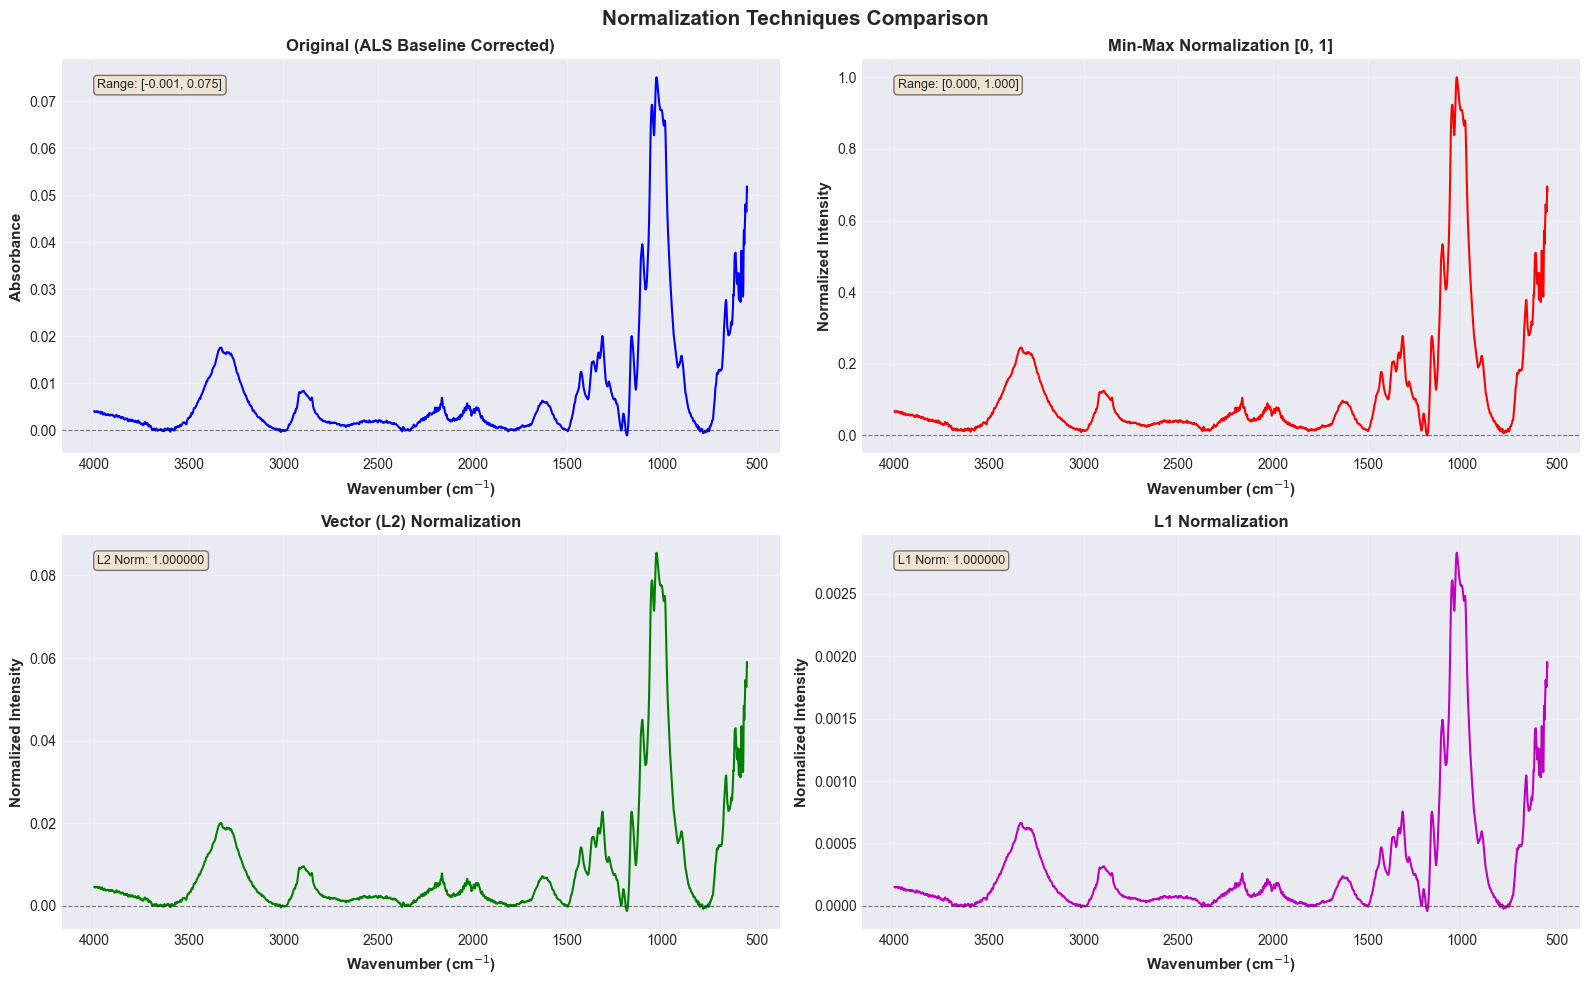


NORMALIZATION TECHNIQUES COMPARISON
Sample: Cotton - 4

Original (ALS Baseline Corrected):
  Mean:     0.007679
  Std:      0.012838
  Min:      -0.001110
  Max:      0.075114
  Range:    0.076224

Min-Max Normalization:
  Mean:     0.115309
  Std:      0.168427
  Min:      0.000000  <- Should be 0
  Max:      1.000000  <- Should be 1
  Range:    1.000000

Vector (L2) Normalization:
  Mean:     0.008738
  Std:      0.014609
  L2 Norm:  1.000000  <- Should be 1
  Min:      -0.001264
  Max:      0.085474

L1 Normalization:
  Mean:     0.000289
  Std:      0.000483
  L1 Norm:  1.000000  <- Should be 1
  Min:      -0.000042
  Max:      0.002829



In [59]:
# Demonstrate all three normalization techniques on the sample spectrum
# Using the ALS baseline-corrected spectrum

# Apply all three normalization methods
minmax_norm = minmax_normalization(corrected_als)
vector_norm = vector_normalization(corrected_als)
l1_norm = l1_normalization(corrected_als)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Original baseline-corrected spectrum
axes[0, 0].plot(wavenumbers, corrected_als, 'b-', linewidth=1.5)
axes[0, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Original (ALS Baseline Corrected)', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'Range: [{corrected_als.min():.3f}, {corrected_als.max():.3f}]',
                transform=axes[0, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Min-Max Normalized
axes[0, 1].plot(wavenumbers, minmax_norm, 'r-', linewidth=1.5)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Normalized Intensity', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Min-Max Normalization [0, 1]', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.05, 0.95, f'Range: [{minmax_norm.min():.3f}, {minmax_norm.max():.3f}]',
                transform=axes[0, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: L2 Vector Normalized
axes[1, 0].plot(wavenumbers, vector_norm, 'g-', linewidth=1.5)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Normalized Intensity', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Vector (L2) Normalization', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.05, 0.95, f'L2 Norm: {np.linalg.norm(vector_norm):.6f}',
                transform=axes[1, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: L1 Normalized
axes[1, 1].plot(wavenumbers, l1_norm, 'm-', linewidth=1.5)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Intensity', fontsize=11, fontweight='bold')
axes[1, 1].set_title('L1 Normalization', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].text(0.05, 0.95, f'L1 Norm: {np.sum(np.abs(l1_norm)):.6f}',
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Normalization Techniques Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*70}")
print(f"NORMALIZATION TECHNIQUES COMPARISON")
print(f"{'='*70}")
print(f"Sample: {sample_file.stem}")

print(f"\nOriginal (ALS Baseline Corrected):")
print(f"  Mean:     {np.mean(corrected_als):.6f}")
print(f"  Std:      {np.std(corrected_als):.6f}")
print(f"  Min:      {corrected_als.min():.6f}")
print(f"  Max:      {corrected_als.max():.6f}")
print(f"  Range:    {corrected_als.max() - corrected_als.min():.6f}")

print(f"\nMin-Max Normalization:")
print(f"  Mean:     {np.mean(minmax_norm):.6f}")
print(f"  Std:      {np.std(minmax_norm):.6f}")
print(f"  Min:      {minmax_norm.min():.6f}  <- Should be 0")
print(f"  Max:      {minmax_norm.max():.6f}  <- Should be 1")
print(f"  Range:    {minmax_norm.max() - minmax_norm.min():.6f}")

print(f"\nVector (L2) Normalization:")
print(f"  Mean:     {np.mean(vector_norm):.6f}")
print(f"  Std:      {np.std(vector_norm):.6f}")
print(f"  L2 Norm:  {np.linalg.norm(vector_norm):.6f}  <- Should be 1")
print(f"  Min:      {vector_norm.min():.6f}")
print(f"  Max:      {vector_norm.max():.6f}")

print(f"\nL1 Normalization:")
print(f"  Mean:     {np.mean(l1_norm):.6f}")
print(f"  Std:      {np.std(l1_norm):.6f}")
print(f"  L1 Norm:  {np.sum(np.abs(l1_norm)):.6f}  <- Should be 1")
print(f"  Min:      {l1_norm.min():.6f}")
print(f"  Max:      {l1_norm.max():.6f}")

print(f"\n{'='*70}")

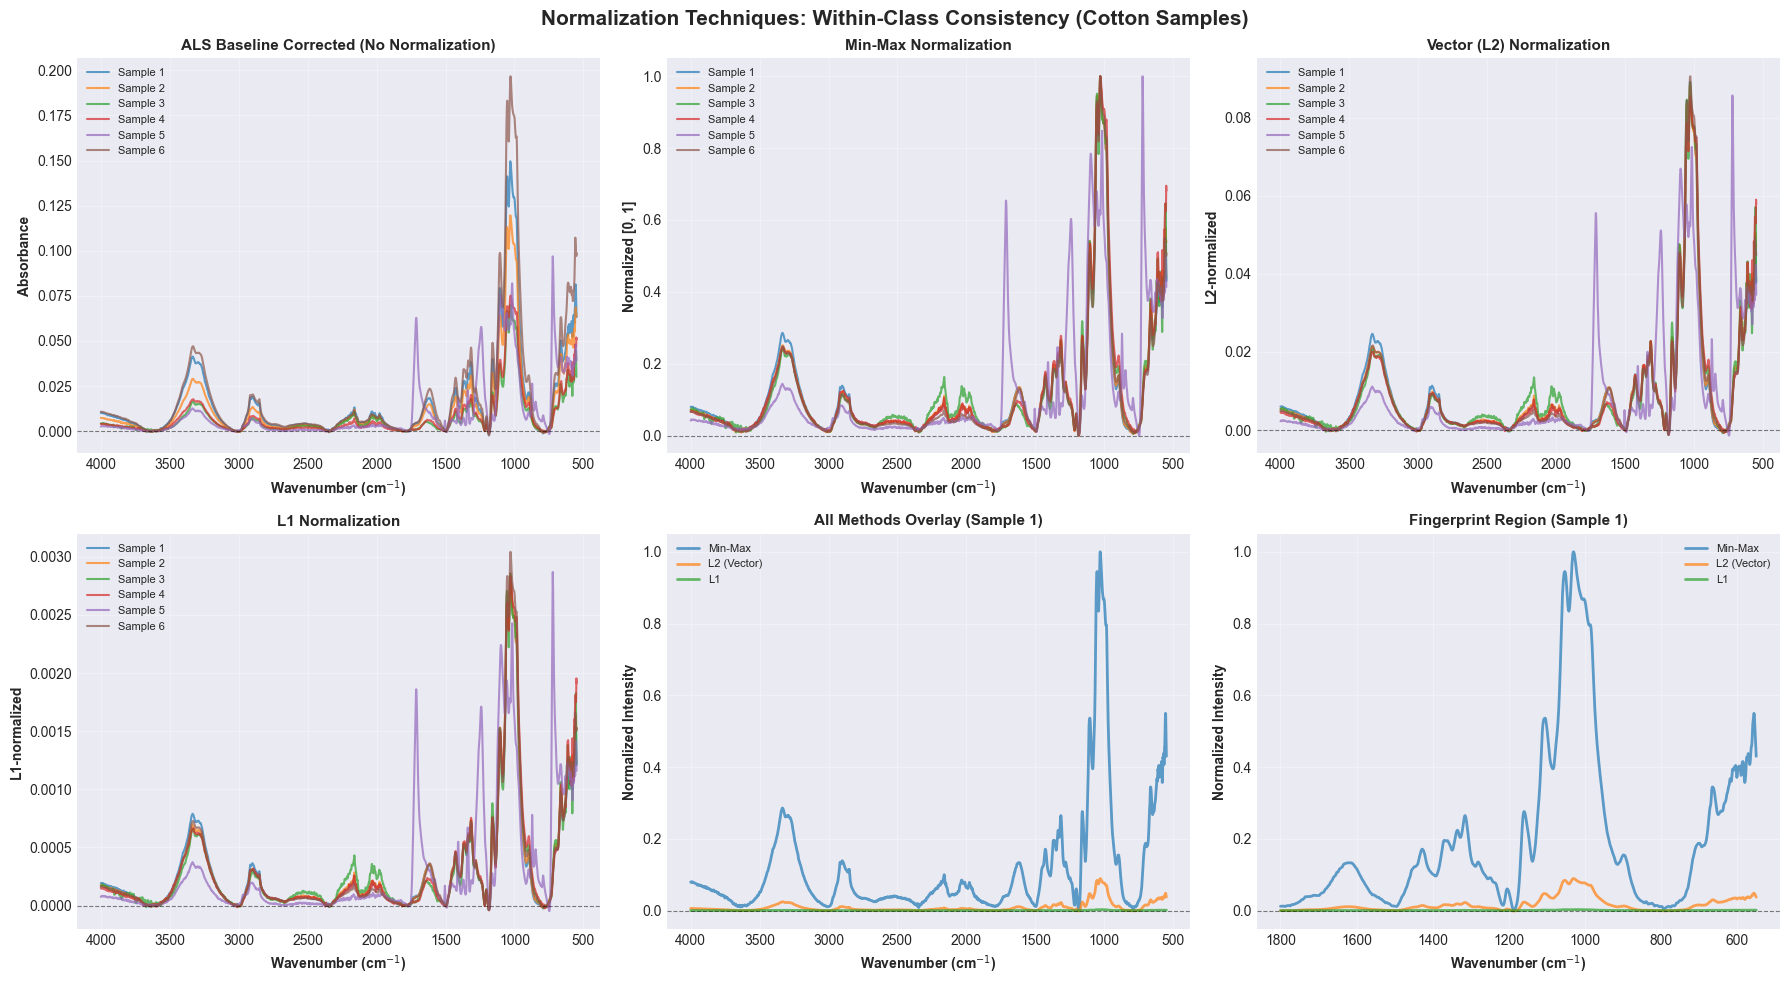


WITHIN-CLASS VARIANCE ANALYSIS (Cotton Samples)

Mean variance across wavenumbers (lower = more consistent):
  Baseline corrected only: 0.000091
  Min-Max normalized:      0.002110
  L2 (Vector) normalized:  0.000016
  L1 normalized:           0.000000

Mean standard deviation across wavenumbers:
  Baseline corrected only: 0.005367
  Min-Max normalized:      0.025496
  L2 (Vector) normalized:  0.002289
  L1 normalized:           0.000075



In [60]:
# Apply all normalization techniques to Cotton samples to show within-class consistency
cotton_files = [f for f in csv_files if 'Cotton' in f.stem]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Load and preprocess Cotton samples (ALS baseline correction)
cotton_baseline_corrected = []
for cotton_file in cotton_files:
    df = pd.read_csv(cotton_file, skiprows=1, header=0)
    wn = df['cm-1'].values
    trans = df['%T'].values
    abs_spec = 2 - np.log10(trans + 1e-9)
    baseline = als_baseline_correction(abs_spec, lam=1e6, p=0.001)
    corrected = abs_spec - baseline
    cotton_baseline_corrected.append(corrected)

# Plot 1: Baseline corrected (no normalization)
axes[0, 0].set_title('ALS Baseline Corrected (No Normalization)', fontsize=11, fontweight='bold')
for i, spec in enumerate(cotton_baseline_corrected):
    axes[0, 0].plot(wn, spec, linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[0, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=10, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Min-Max Normalized
axes[0, 1].set_title('Min-Max Normalization', fontsize=11, fontweight='bold')
for i, spec in enumerate(cotton_baseline_corrected):
    normalized = minmax_normalization(spec)
    axes[0, 1].plot(wn, normalized, linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('Normalized [0, 1]', fontsize=10, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Vector (L2) Normalized
axes[0, 2].set_title('Vector (L2) Normalization', fontsize=11, fontweight='bold')
for i, spec in enumerate(cotton_baseline_corrected):
    normalized = vector_normalization(spec)
    axes[0, 2].plot(wn, normalized, linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[0, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[0, 2].set_ylabel('L2-normalized', fontsize=10, fontweight='bold')
axes[0, 2].invert_xaxis()
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: L1 Normalized
axes[1, 0].set_title('L1 Normalization', fontsize=11, fontweight='bold')
for i, spec in enumerate(cotton_baseline_corrected):
    normalized = l1_normalization(spec)
    axes[1, 0].plot(wn, normalized, linewidth=1.5, alpha=0.7, label=f'Sample {i+1}')
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('L1-normalized', fontsize=10, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Comparison of all methods (Sample 1 only)
axes[1, 1].set_title('All Methods Overlay (Sample 1)', fontsize=11, fontweight='bold')
axes[1, 1].plot(wn, minmax_normalization(cotton_baseline_corrected[0]), 
                linewidth=2, alpha=0.7, label='Min-Max')
axes[1, 1].plot(wn, vector_normalization(cotton_baseline_corrected[0]), 
                linewidth=2, alpha=0.7, label='L2 (Vector)')
axes[1, 1].plot(wn, l1_normalization(cotton_baseline_corrected[0]), 
                linewidth=2, alpha=0.7, label='L1')
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Normalized Intensity', fontsize=10, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Fingerprint region comparison (1800-550 cm⁻¹)
fingerprint_mask = (wn >= 550) & (wn <= 1800)
axes[1, 2].set_title('Fingerprint Region (Sample 1)', fontsize=11, fontweight='bold')
axes[1, 2].plot(wn[fingerprint_mask], 
                minmax_normalization(cotton_baseline_corrected[0])[fingerprint_mask],
                linewidth=2, alpha=0.7, label='Min-Max')
axes[1, 2].plot(wn[fingerprint_mask], 
                vector_normalization(cotton_baseline_corrected[0])[fingerprint_mask],
                linewidth=2, alpha=0.7, label='L2 (Vector)')
axes[1, 2].plot(wn[fingerprint_mask], 
                l1_normalization(cotton_baseline_corrected[0])[fingerprint_mask],
                linewidth=2, alpha=0.7, label='L1')
axes[1, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
axes[1, 2].set_ylabel('Normalized Intensity', fontsize=10, fontweight='bold')
axes[1, 2].invert_xaxis()
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Normalization Techniques: Within-Class Consistency (Cotton Samples)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate and display variance statistics
print(f"\n{'='*70}")
print(f"WITHIN-CLASS VARIANCE ANALYSIS (Cotton Samples)")
print(f"{'='*70}")

# Convert to arrays for analysis
baseline_array = np.array(cotton_baseline_corrected)
minmax_array = np.array([minmax_normalization(s) for s in cotton_baseline_corrected])
vector_array = np.array([vector_normalization(s) for s in cotton_baseline_corrected])
l1_array = np.array([l1_normalization(s) for s in cotton_baseline_corrected])

print(f"\nMean variance across wavenumbers (lower = more consistent):")
print(f"  Baseline corrected only: {np.mean(np.var(baseline_array, axis=0)):.6f}")
print(f"  Min-Max normalized:      {np.mean(np.var(minmax_array, axis=0)):.6f}")
print(f"  L2 (Vector) normalized:  {np.mean(np.var(vector_array, axis=0)):.6f}")
print(f"  L1 normalized:           {np.mean(np.var(l1_array, axis=0)):.6f}")

print(f"\nMean standard deviation across wavenumbers:")
print(f"  Baseline corrected only: {np.mean(np.std(baseline_array, axis=0)):.6f}")
print(f"  Min-Max normalized:      {np.mean(np.std(minmax_array, axis=0)):.6f}")
print(f"  L2 (Vector) normalized:  {np.mean(np.std(vector_array, axis=0)):.6f}")
print(f"  L1 normalized:           {np.mean(np.std(l1_array, axis=0)):.6f}")

print(f"\n{'='*70}")

## Step 5: Comprehensive Comparison of All Preprocessing Techniques

Now let's apply all preprocessing techniques to **multiple fabric types** to see how they affect **between-class discrimination** and **within-class consistency**.

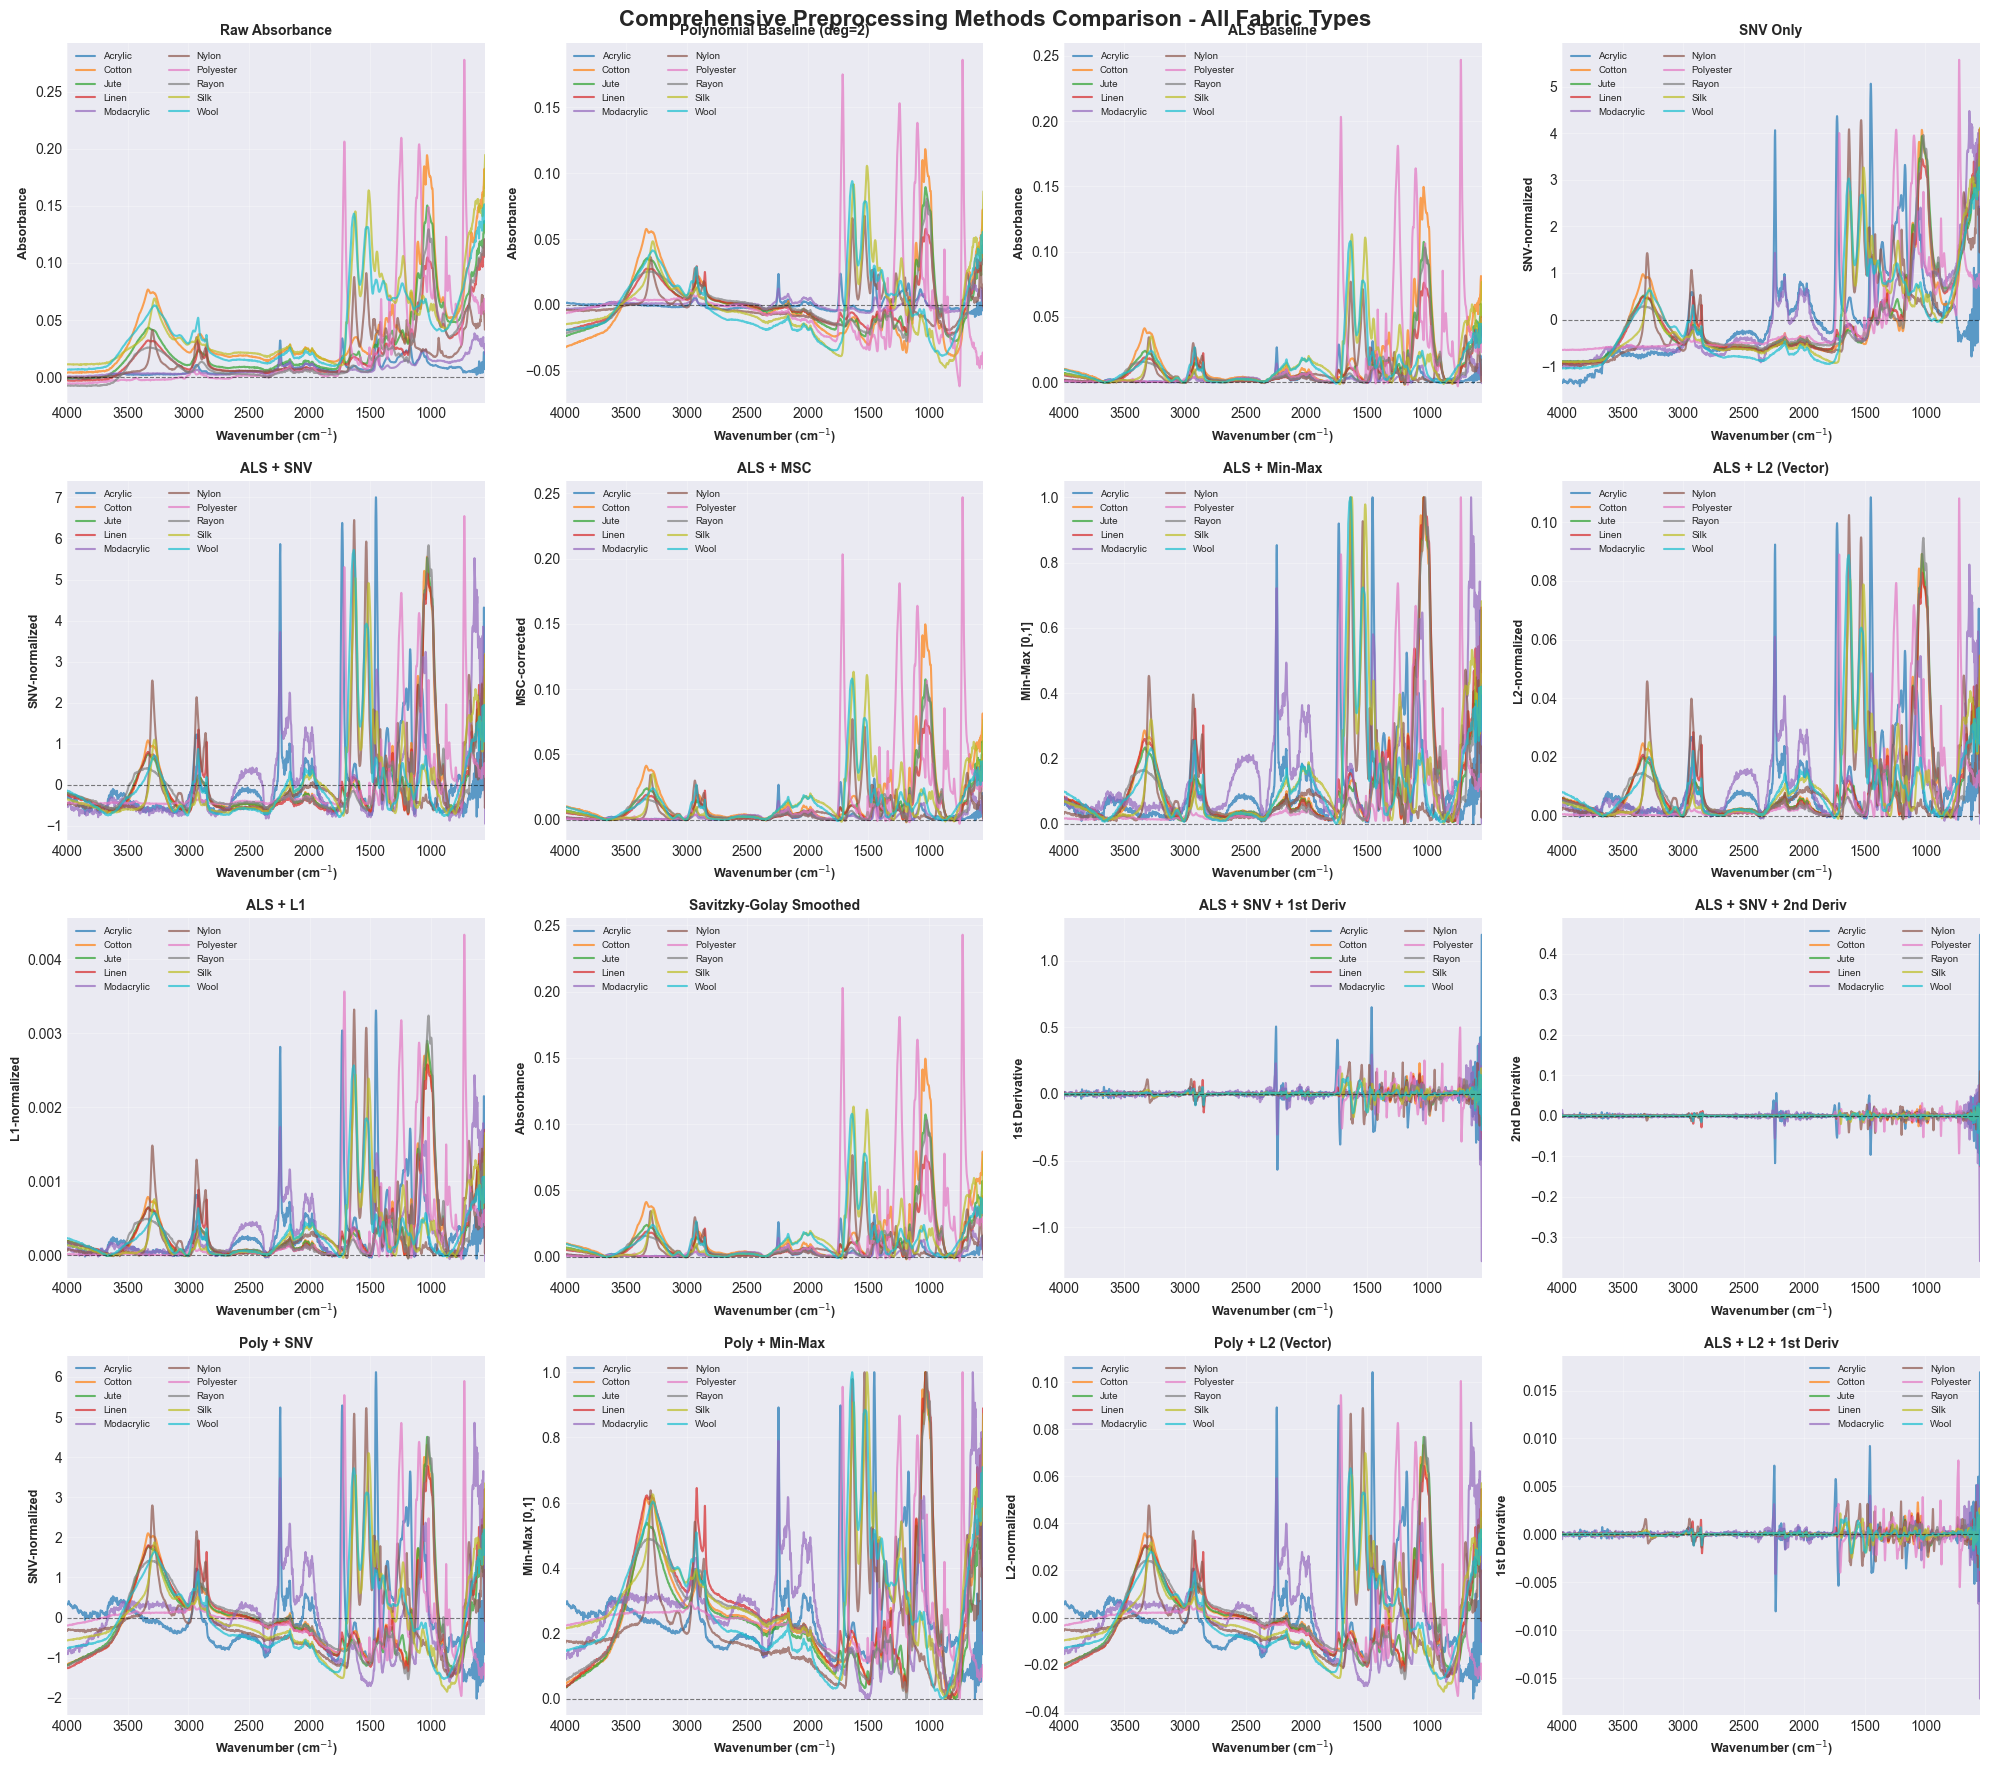

In [61]:
# Comprehensive comparison: Apply all preprocessing methods to all fabric types
# Select one representative sample from each fabric type

fig, axes = plt.subplots(4, 4, figsize=(20, 18))
axes = axes.flatten()

# Define all preprocessing methods
preprocessing_methods = [
    ('Raw Absorbance', lambda x: x, 'Absorbance'),
    ('Polynomial Baseline (deg=2)', lambda x: polynomial_baseline_correction(x, degree=2)[0], 'Absorbance'),
    ('ALS Baseline', lambda x: x - als_baseline_correction(x, lam=1e6, p=0.001), 'Absorbance'),
    ('SNV Only', lambda x: standard_normal_variate(x), 'SNV-normalized'),
    ('ALS + SNV', lambda x: standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 'SNV-normalized'),
    ('ALS + MSC', lambda x: multiplicative_scatter_correction(
        np.array([x - als_baseline_correction(x, lam=1e6, p=0.001) for _ in range(1)])
    ).flatten(), 'MSC-corrected'),
    ('ALS + Min-Max', lambda x: minmax_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)), 'Min-Max [0,1]'),
    ('ALS + L2 (Vector)', lambda x: vector_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)), 'L2-normalized'),
    ('ALS + L1', lambda x: l1_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)), 'L1-normalized'),
    ('Savitzky-Golay Smoothed', lambda x: savgol_filter(
        x - als_baseline_correction(x, lam=1e6, p=0.001), 
        window_length=15, polyorder=3, deriv=0), 'Absorbance'),
    ('ALS + SNV + 1st Deriv', lambda x: savgol_filter(
        standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 
        window_length=15, polyorder=3, deriv=1), '1st Derivative'),
    ('ALS + SNV + 2nd Deriv', lambda x: savgol_filter(
        standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 
        window_length=15, polyorder=3, deriv=2), '2nd Derivative'),
    ('Poly + SNV', lambda x: standard_normal_variate(polynomial_baseline_correction(x, degree=2)[0]), 'SNV-normalized'),
    ('Poly + Min-Max', lambda x: minmax_normalization(polynomial_baseline_correction(x, degree=2)[0]), 'Min-Max [0,1]'),
    ('Poly + L2 (Vector)', lambda x: vector_normalization(polynomial_baseline_correction(x, degree=2)[0]), 'L2-normalized'),
    ('ALS + L2 + 1st Deriv', lambda x: savgol_filter(
        vector_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)), 
        window_length=15, polyorder=3, deriv=1), '1st Derivative'),
]

# Process one sample from each fabric type
for idx, (method_name, preprocess_func, ylabel) in enumerate(preprocessing_methods):
    ax = axes[idx]
    
    # Apply preprocessing to one sample from each fabric type
    for fabric in sorted(fabric_types):
        fabric_files = [f for f in csv_files if fabric in f.stem]
        if fabric_files:
            # Take first sample
            df = pd.read_csv(fabric_files[0], skiprows=1, header=0)
            wn = df['cm-1'].values
            trans = df['%T'].values
            abs_spec = 2 - np.log10(trans + 1e-9)
            
            # Apply preprocessing
            try:
                processed = preprocess_func(abs_spec)
                
                # Plot
                ax.plot(wn, processed, linewidth=1.5, label=fabric, 
                       color=color_map[fabric], alpha=0.7)
            except Exception as e:
                continue
    
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=9, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=9, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=10, fontweight='bold')
    ax.invert_xaxis()
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(4000, 550)

plt.suptitle('Comprehensive Preprocessing Methods Comparison - All Fabric Types', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Streamlined Pipeline Analysis & Selection

This section performs systematic quantitative and qualitative analysis to determine the optimal preprocessing pipeline for supervised machine learning classification of textile ATR-FTIR spectra.

## Methodology:

### **1. Pipeline Definition**
Select preprocessing combinations based on established spectroscopy literature and theoretical soundness.

### **2. Comprehensive Data Processing**
Apply each pipeline to all fabric samples systematically to ensure reproducibility.

### **3. Multi-Metric Evaluation**
Evaluate pipelines using complementary metrics that assess different aspects of preprocessing quality:

#### **Statistical Metrics:**

**Fisher Ratio (F-ratio)**
- **Definition**: Ratio of between-class variance to within-class variance
- **Formula**: $F = \frac{\sigma_{between}^2}{\sigma_{within}^2}$
- **Interpretation**: 
  - Higher values indicate better class separation
  - Values > 1.0 suggest classes are more separated than dispersed
  - Optimal for supervised classification tasks
- **Range**: 0 to ∞ (typical good values: > 2.0)

**Within-Class Variance**
- **Definition**: Average variance of spectra within each fabric class
- **Interpretation**: 
  - Lower values indicate better reproducibility and consistency
  - Measures how similar spectra are within the same class
  - Important for reliable classification
- **Ideal**: Minimize (closer to 0 is better)

**Between-Class Variance**
- **Definition**: Variance of class mean spectra
- **Interpretation**: 
  - Higher values indicate classes are more distinct from each other
  - Measures discriminability between fabric types
  - Essential for classification performance
- **Ideal**: Maximize (larger separation is better)

#### **Clustering Quality Metrics (PCA-based):**

**Silhouette Score**
- **Definition**: Measures how well-separated clusters are in reduced dimensional space
- **Formula**: $s = \frac{b - a}{\max(a, b)}$ where $a$ = mean intra-cluster distance, $b$ = mean nearest-cluster distance
- **Interpretation**:
  - Range: -1 to +1
  - +1: Perfect clustering (samples far from other clusters)
  - 0: Overlapping clusters (samples on cluster boundaries)
  - -1: Misclassified samples (samples closer to wrong clusters)
- **Thresholds**:
  - > 0.7: Strong, well-separated clusters
  - 0.5-0.7: Reasonable separation
  - 0.25-0.5: Weak separation, some overlap
  - < 0.25: Poor separation, significant overlap
- **Reference**: Rousseeuw, P.J. (1987). "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis"

**Davies-Bouldin Index (DB Index)**
- **Definition**: Ratio of within-cluster scatter to between-cluster separation
- **Interpretation**:
  - Lower values indicate better clustering
  - Measures average similarity between clusters
  - Evaluates compactness and separation simultaneously
- **Range**: 0 to ∞
- **Thresholds**:
  - < 1.0: Excellent clustering
  - 1.0-2.0: Good clustering
  - > 2.0: Poor clustering, overlapping classes
- **Reference**: Davies, D.L. & Bouldin, D.W. (1979). "A Cluster Separation Measure"

**PCA Explained Variance**
- **Definition**: Percentage of total variance captured by principal components
- **Interpretation**:
  - Higher values = more efficient dimensionality reduction
  - PC1+PC2 > 70% indicates good 2D representation
  - Measures information retention after preprocessing
- **Ideal**: Maximize first 2-3 components for visualization and efficient ML

### **4. Composite Scoring**
Normalize all metrics to [0, 1] scale and compute weighted average based on classification task priorities.

### **5. Evidence-Based Recommendation**
Rank pipelines and provide top recommendations with supporting quantitative evidence.

## References:

This approach follows best practices from chemometric literature:
- **Rinnan, A., et al. (2009)**: "Review of the most common pre-processing techniques for near-infrared spectra" - TrAC Trends in Analytical Chemistry
- **Engel, J., et al. (2013)**: "Breaking with trends in pre-processing?" - TrAC Trends in Analytical Chemistry  
- **Rousseeuw, P.J. (1987)**: "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis" - Journal of Computational and Applied Mathematics
- **Davies, D.L. & Bouldin, D.W. (1979)**: "A Cluster Separation Measure" - IEEE Transactions on Pattern Analysis and Machine Intelligence

In [62]:
# Import libraries for analysis
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

## Step 1: Define & Apply Preprocessing Pipelines

Select key preprocessing combinations based on spectroscopy best practices and apply them to all data.

In [63]:
# Define preprocessing pipelines
preprocessing_pipelines = {
    'Raw': lambda x: x,
    'ALS': lambda x: x - als_baseline_correction(x, lam=1e6, p=0.001),
    'ALS+SNV': lambda x: standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)),
    'ALS+MSC': 'special',  # Handled separately
    'ALS+MinMax': lambda x: minmax_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)),
    'ALS+L2': lambda x: vector_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)),
    'Poly+SNV': lambda x: standard_normal_variate(polynomial_baseline_correction(x, degree=2)[0]),
    'ALS+SNV+D1': lambda x: savgol_filter(standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 15, 3, deriv=1),
    'ALS+L2+D1': lambda x: savgol_filter(vector_normalization(x - als_baseline_correction(x, lam=1e6, p=0.001)), 15, 3, deriv=1),
}

# Load all data
all_data = {}
wn_ref = None

for fabric in sorted(fabric_types):
    files = [f for f in csv_files if fabric in f.stem]
    spectra = []
    for f in files:
        df = pd.read_csv(f, skiprows=1, header=0)
        if wn_ref is None:
            wn_ref = df['cm-1'].values
        spectra.append(2 - np.log10(df['%T'].values + 1e-9))
    all_data[fabric] = np.array(spectra)

# Apply pipelines
processed = {}
for name, func in preprocessing_pipelines.items():
    print(f"Processing: {name}")
    processed[name] = {}
    
    if name == 'ALS+MSC':
        # Baseline correct all, compute reference, apply MSC
        all_bc = []
        for fabric, spectra in all_data.items():
            for s in spectra:
                all_bc.append(s - als_baseline_correction(s, lam=1e6, p=0.001))
        ref = np.mean(all_bc, axis=0)
        
        for fabric, spectra in all_data.items():
            proc = []
            for s in spectra:
                bc = s - als_baseline_correction(s, lam=1e6, p=0.001)
                proc.append(multiplicative_scatter_correction(np.array([bc]), reference=ref).flatten())
            processed[name][fabric] = np.array(proc)
    else:
        for fabric, spectra in all_data.items():
            processed[name][fabric] = np.array([func(s) for s in spectra])

print(f"\nProcessed {len(preprocessing_pipelines)} pipelines for {sum(len(s) for s in all_data.values())} total spectra")

Processing: Raw
Processing: ALS
Processing: ALS+SNV
Processing: ALS+MSC
Processing: ALS+MinMax
Processing: ALS+L2
Processing: Poly+SNV
Processing: ALS+SNV+D1
Processing: ALS+L2+D1

Processed 9 pipelines for 62 total spectra


In [64]:
print(all_data)

{'Acrylic': array([[-1.43081225e-03, -1.38752349e-03, -1.38752349e-03, ...,
         1.42143822e-02,  1.36762229e-02,  1.40797799e-02],
       [ 2.91956452e-03,  2.91956452e-03,  2.96328911e-03, ...,
         9.70555387e-03,  1.07727263e-02,  1.12627247e-02],
       [-4.34272812e-05, -4.34272812e-05, -4.34272812e-05, ...,
         2.70100759e-03,  2.35154510e-03,  2.52624119e-03],
       [ 9.12977370e-04,  8.25944407e-04,  7.38928883e-04, ...,
         2.33749479e-02,  2.42006903e-02,  2.54422551e-02],
       [ 4.40867574e-03,  4.49642973e-03,  4.54031337e-03, ...,
         2.91883891e-02,  2.88633705e-02,  2.86313632e-02]],
      shape=(5, 3451)), 'Cotton': array([[ 3.92634551e-03,  3.88252386e-03,  3.83870663e-03, ...,
         1.72114017e-01,  1.69218924e-01,  1.65770097e-01],
       [ 1.78426762e-03,  1.74066157e-03,  1.69705990e-03, ...,
         1.50580586e-01,  1.51195299e-01,  1.50949309e-01],
       [-8.68502160e-05, -8.68502160e-05, -8.68502160e-05, ...,
         7.18602931e-

## Step 2: Calculate All Metrics in One Pass

Compute statistical metrics and PCA results efficiently for all pipelines.

In [65]:
# Calculate all metrics
results = []

for pipeline_name, data in processed.items():
    # Prepare data for analysis
    X, y = [], []
    for fabric, spectra in data.items():
        X.extend(spectra)
        y.extend([fabric] * len(spectra))
    X, y = np.array(X), np.array(y)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Statistical metrics
    within_vars = [np.mean(np.var(spectra, axis=0)) for fabric, spectra in data.items()]
    within_var = np.mean(within_vars)
    
    class_means = np.array([np.mean(spectra, axis=0) for fabric, spectra in data.items()])
    between_var = np.mean(np.var(class_means, axis=0))
    
    fisher = between_var / within_var if within_var > 0 else 0
    
    # PCA
    pca = PCA(n_components=min(10, X.shape[0], X.shape[1]))
    X_pca = pca.fit_transform(X)
    
    # Clustering metrics
    try:
        sil = silhouette_score(X_pca[:, :5], y) if len(np.unique(y)) > 1 else np.nan
        db = davies_bouldin_score(X_pca[:, :5], y) if len(np.unique(y)) > 1 else np.nan
    except:
        sil, db = np.nan, np.nan
    
    results.append({
        'Pipeline': pipeline_name,
        'Fisher Ratio': fisher,
        'Within Var': within_var,
        'Between Var': between_var,
        'Silhouette': sil,
        'DB Index': db,
        'PC1 Var %': pca.explained_variance_ratio_[0] * 100,
        'PC1+2 Var %': sum(pca.explained_variance_ratio_[:2]) * 100,
        'pca_obj': pca,
        'X_pca': X_pca,
        'y': y
    })

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.round(4)

print(f"\n{'='*90}")
print("PIPELINE METRICS SUMMARY")
print(f"{'='*90}")
print(df_results[['Pipeline', 'Fisher Ratio', 'Silhouette', 'DB Index', 'PC1+2 Var %']].to_string(index=False))
print(f"{'='*90}")


PIPELINE METRICS SUMMARY
  Pipeline  Fisher Ratio  Silhouette  DB Index  PC1+2 Var %
       Raw        1.8960     -0.1278    3.7576      69.9537
       ALS        3.0680     -0.0137    2.2642      70.5401
   ALS+SNV        5.5165      0.3873    1.2861      68.7359
   ALS+MSC        3.3009      0.3545    1.3081      66.4444
ALS+MinMax        5.2268      0.3498    1.2848      71.1782
    ALS+L2        5.6976      0.3830    1.2556      69.5356
  Poly+SNV        5.9880      0.3374    1.3152      72.0884
ALS+SNV+D1        1.0882      0.0669    1.8791      38.7082
 ALS+L2+D1        1.1336      0.0794    1.7902      39.8406


## Step 3: Rank Pipelines & Visualize Results

Combine metrics to rank pipelines and visualize results in a consolidated view.

In [66]:
# Apply all preprocessing pipelines to all spectra
processed_datasets = {}

for pipeline_name, preprocess_func in preprocessing_pipelines.items():
    print(f"Processing: {pipeline_name}...")
    
    processed_data = {}
    
    # Special handling for MSC (requires reference spectrum)
    if 'MSC' in pipeline_name:
        # First, baseline correct all spectra
        all_baseline_corrected = []
        for fabric, spectra in all_data.items():
            for spectrum in spectra:
                baseline = als_baseline_correction(spectrum, lam=1e6, p=0.001)
                all_baseline_corrected.append(spectrum - baseline)
        
        # Compute reference spectrum (mean of all baseline-corrected spectra)
        reference_spectrum = np.mean(all_baseline_corrected, axis=0)
        
        # Now apply MSC to each fabric type
        for fabric, spectra in all_data.items():
            processed_spectra = []
            for spectrum in spectra:
                baseline = als_baseline_correction(spectrum, lam=1e6, p=0.001)
                corrected = spectrum - baseline
                msc_corrected = multiplicative_scatter_correction(
                    np.array([corrected]), 
                    reference=reference_spectrum
                ).flatten()
                processed_spectra.append(msc_corrected)
            processed_data[fabric] = np.array(processed_spectra)
    else:
        # Standard processing
        for fabric, spectra in all_data.items():
            processed_spectra = []
            for spectrum in spectra:
                try:
                    processed = preprocess_func(spectrum)
                    processed_spectra.append(processed)
                except Exception as e:
                    print(f"  Warning: Error processing {fabric} sample: {e}")
                    processed_spectra.append(spectrum)
            processed_data[fabric] = np.array(processed_spectra)
    
    processed_datasets[pipeline_name] = processed_data

print(f"\n{'='*70}")
print(f"PREPROCESSING COMPLETE")
print(f"Total pipelines processed: {len(processed_datasets)}")
print(f"{'='*70}")

Processing: Raw...
Processing: ALS...
Processing: ALS+SNV...
Processing: ALS+MSC...
Processing: ALS+MinMax...
Processing: ALS+L2...
Processing: Poly+SNV...
Processing: ALS+SNV+D1...
Processing: ALS+L2+D1...

PREPROCESSING COMPLETE
Total pipelines processed: 9


## Step 3: Qualitative Analysis - Mean Spectra Overlay

Visualize mean spectra for each fabric type under different preprocessing methods to assess class separation visually.

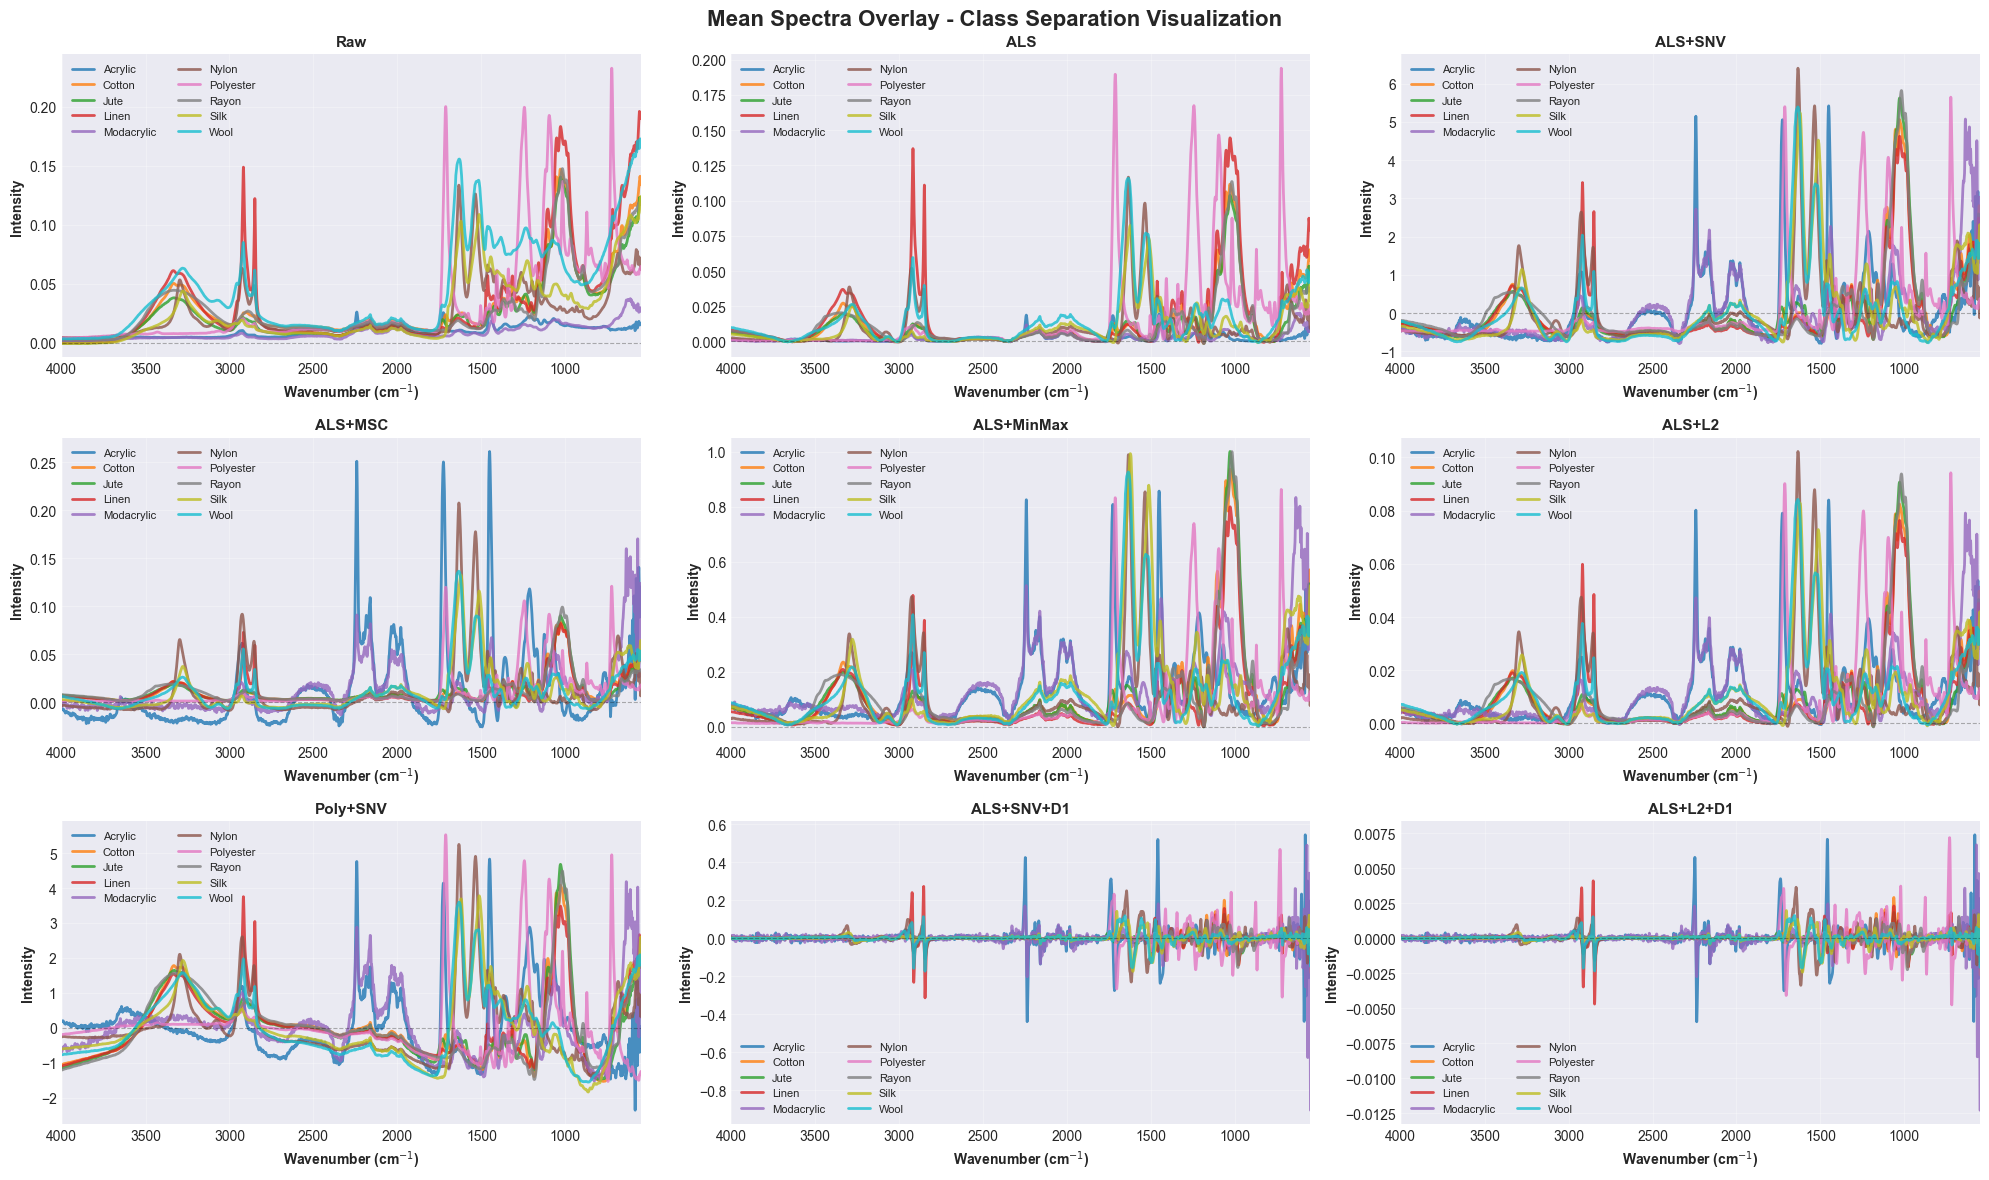

In [67]:
# Plot mean spectra for all fabric types under each preprocessing method
n_pipelines = len(processed_datasets)
n_cols = 3
n_rows = (n_pipelines + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, (pipeline_name, processed_data) in enumerate(processed_datasets.items()):
    ax = axes[idx]
    
    # Plot mean spectrum for each fabric type
    for fabric in sorted(fabric_types):
        if fabric in processed_data:
            mean_spectrum = np.mean(processed_data[fabric], axis=0)
            ax.plot(wavenumbers, mean_spectrum, linewidth=2, 
                   label=fabric, color=color_map[fabric], alpha=0.8)
    
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.3)
    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Intensity', fontsize=10, fontweight='bold')
    ax.set_title(f'{pipeline_name}', fontsize=11, fontweight='bold')
    ax.invert_xaxis()
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(4000, 550)

# Hide unused subplots
for idx in range(n_pipelines, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Mean Spectra Overlay - Class Separation Visualization', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4: Quantitative Metrics - Statistical Analysis

Calculate key statistical metrics for each preprocessing pipeline:
- **Within-class variance**: Lower is better (more consistent within classes)
- **Between-class variance**: Higher is better (more separation between classes)
- **Fisher ratio**: Between-class / Within-class variance (higher is better)
- **Coefficient of Variation (CV)**: Within-class variability measure

In [68]:
# Calculate statistical metrics for each preprocessing pipeline
statistical_metrics = {}

for pipeline_name, processed_data in processed_datasets.items():
    # Flatten all spectra for overall analysis
    all_spectra = []
    labels = []
    
    for fabric, spectra in processed_data.items():
        all_spectra.extend(spectra)
        labels.extend([fabric] * len(spectra))
    
    all_spectra = np.array(all_spectra)
    
    # Calculate within-class variance
    within_class_vars = []
    for fabric, spectra in processed_data.items():
        fabric_var = np.mean(np.var(spectra, axis=0))
        within_class_vars.append(fabric_var)
    mean_within_class_var = np.mean(within_class_vars)
    
    # Calculate between-class variance using class means
    class_means = []
    for fabric, spectra in processed_data.items():
        class_means.append(np.mean(spectra, axis=0))
    class_means = np.array(class_means)
    
    # Between-class variance: variance of class means
    between_class_var = np.mean(np.var(class_means, axis=0))
    
    # Fisher ratio
    fisher_ratio = between_class_var / mean_within_class_var if mean_within_class_var > 0 else 0
    
    # Calculate mean coefficient of variation within classes
    cvs = []
    for fabric, spectra in processed_data.items():
        mean_vals = np.mean(spectra, axis=0)
        std_vals = np.std(spectra, axis=0)
        # Avoid division by zero
        cv = np.mean(np.abs(std_vals / (mean_vals + 1e-10)))
        cvs.append(cv)
    mean_cv = np.mean(cvs)
    
    # Store metrics
    statistical_metrics[pipeline_name] = {
        'Within-Class Variance': mean_within_class_var,
        'Between-Class Variance': between_class_var,
        'Fisher Ratio': fisher_ratio,
        'Mean CV': mean_cv
    }

# Create DataFrame for easy visualization
metrics_df = pd.DataFrame(statistical_metrics).T
metrics_df = metrics_df.round(6)

print(f"\n{'='*80}")
print(f"STATISTICAL METRICS SUMMARY")
print(f"{'='*80}")
print(metrics_df.to_string())
print(f"\n{'='*80}")

# Rank pipelines by Fisher ratio
metrics_df_sorted = metrics_df.sort_values('Fisher Ratio', ascending=False)
print(f"\nPIPELINES RANKED BY FISHER RATIO (Higher = Better Separation):")
print(f"{'='*80}")
for idx, (pipeline, row) in enumerate(metrics_df_sorted.iterrows(), 1):
    print(f"{idx}. {pipeline:<25} Fisher Ratio: {row['Fisher Ratio']:.6f}")
print(f"{'='*80}")


STATISTICAL METRICS SUMMARY
            Within-Class Variance  Between-Class Variance  Fisher Ratio   Mean CV
Raw                      0.000243                0.000460      1.895999  2.066414
ALS                      0.000074                0.000227      3.068016  0.819289
ALS+SNV                  0.090460                0.499017      5.516464  2.820130
ALS+MSC                  0.000107                0.000353      3.300895  1.200479
ALS+MinMax               0.002175                0.011366      5.226781  0.263844
ALS+L2                   0.000018                0.000104      5.697600  0.737012
Poly+SNV                 0.091322                0.546834      5.988004  1.450767
ALS+SNV+D1               0.000973                0.001059      1.088247  6.012829
ALS+L2+D1                0.000000                0.000000      1.133583  7.602772


PIPELINES RANKED BY FISHER RATIO (Higher = Better Separation):
1. Poly+SNV                  Fisher Ratio: 5.988004
2. ALS+L2                    Fishe

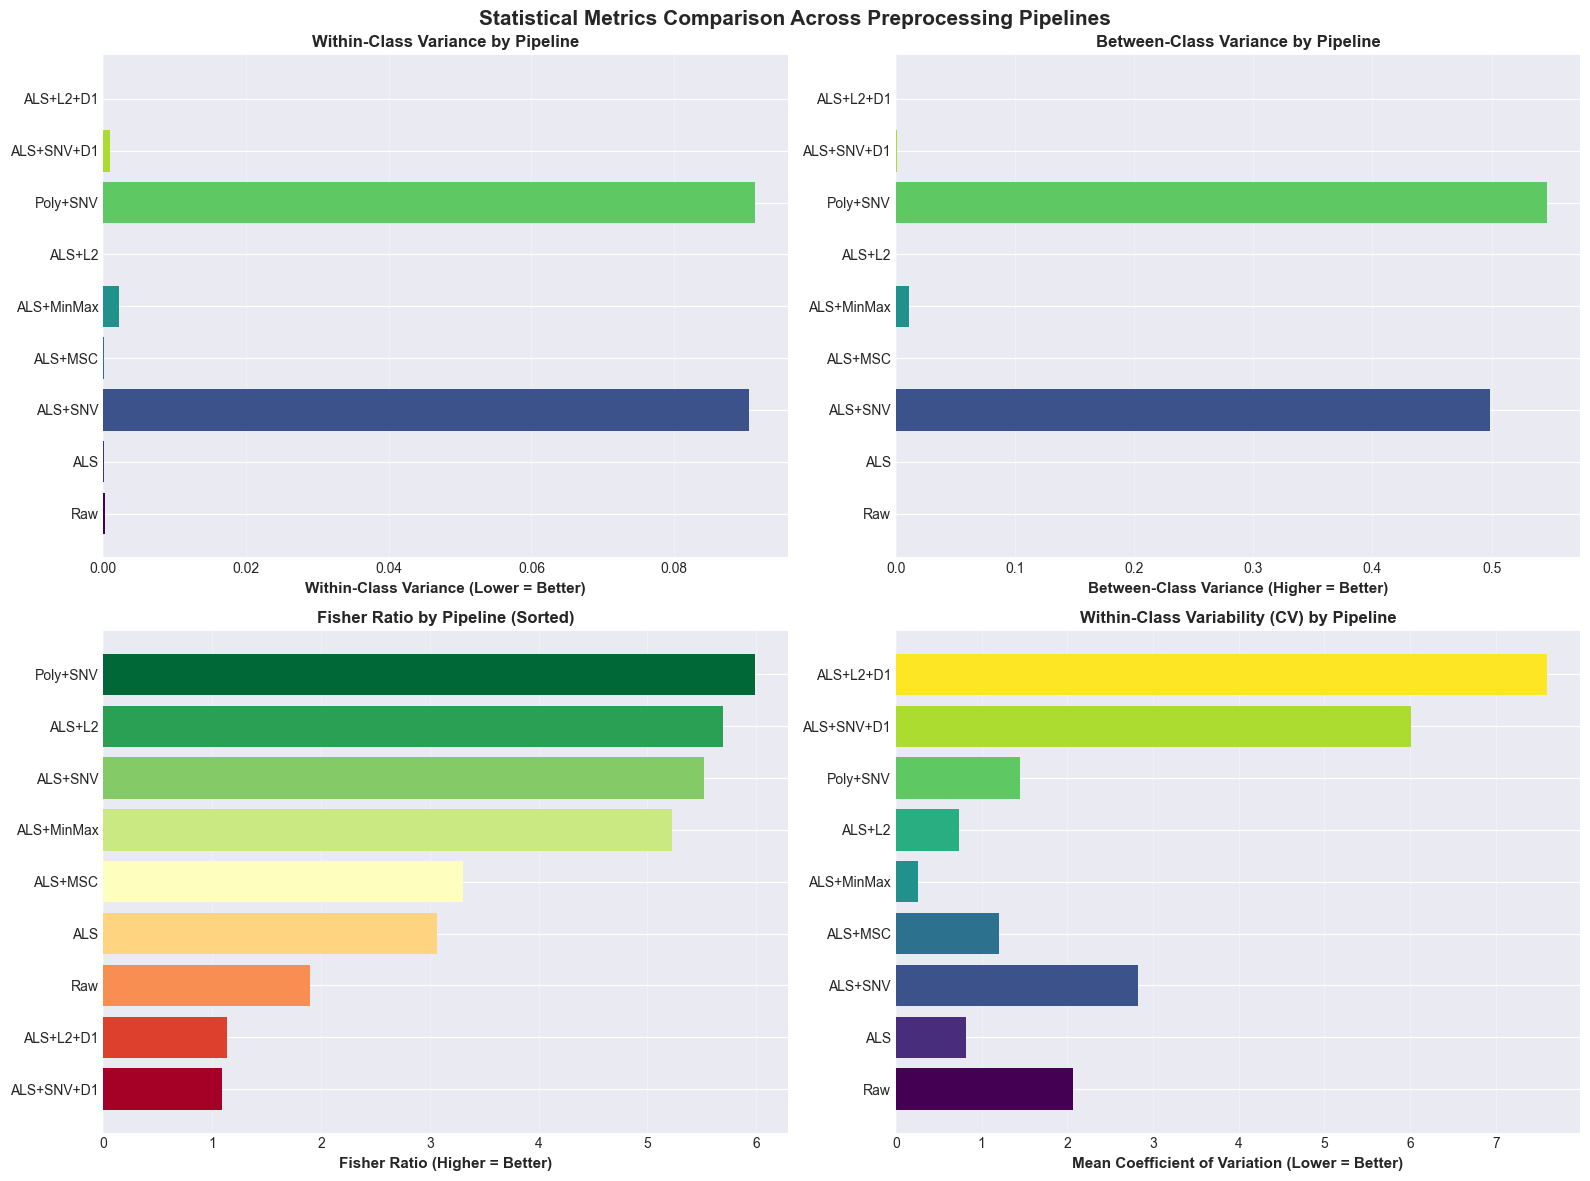

In [69]:
# Visualize statistical metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Within-Class Variance
ax1 = axes[0, 0]
within_vars = metrics_df['Within-Class Variance'].values
pipeline_names = metrics_df.index
colors_bars = plt.cm.viridis(np.linspace(0, 1, len(pipeline_names)))
ax1.barh(pipeline_names, within_vars, color=colors_bars)
ax1.set_xlabel('Within-Class Variance (Lower = Better)', fontsize=11, fontweight='bold')
ax1.set_title('Within-Class Variance by Pipeline', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Between-Class Variance
ax2 = axes[0, 1]
between_vars = metrics_df['Between-Class Variance'].values
ax2.barh(pipeline_names, between_vars, color=colors_bars)
ax2.set_xlabel('Between-Class Variance (Higher = Better)', fontsize=11, fontweight='bold')
ax2.set_title('Between-Class Variance by Pipeline', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Fisher Ratio
ax3 = axes[1, 0]
fisher_ratios = metrics_df['Fisher Ratio'].values
sorted_indices = np.argsort(fisher_ratios)
sorted_pipelines = [pipeline_names[i] for i in sorted_indices]
sorted_fisher = [fisher_ratios[i] for i in sorted_indices]
colors_sorted = plt.cm.RdYlGn(np.linspace(0, 1, len(sorted_pipelines)))
ax3.barh(sorted_pipelines, sorted_fisher, color=colors_sorted)
ax3.set_xlabel('Fisher Ratio (Higher = Better)', fontsize=11, fontweight='bold')
ax3.set_title('Fisher Ratio by Pipeline (Sorted)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Mean CV
ax4 = axes[1, 1]
mean_cvs = metrics_df['Mean CV'].values
ax4.barh(pipeline_names, mean_cvs, color=colors_bars)
ax4.set_xlabel('Mean Coefficient of Variation (Lower = Better)', fontsize=11, fontweight='bold')
ax4.set_title('Within-Class Variability (CV) by Pipeline', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Statistical Metrics Comparison Across Preprocessing Pipelines', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 5: Principal Component Analysis (PCA)

PCA is the gold standard for evaluating preprocessing effectiveness in spectroscopy. It reveals:
- **Variance explained**: How much information is retained in reduced dimensions
- **Class separation**: Visual clustering in PC space
- **Dimensionality reduction**: Effectiveness for ML model input

We'll perform PCA on each preprocessing pipeline and evaluate:
1. Explained variance ratio
2. 2D scatter plots (PC1 vs PC2)
3. Clustering quality metrics (Silhouette score, Davies-Bouldin index)

In [70]:
# Perform PCA for each preprocessing pipeline
pca_results = {}

for pipeline_name, processed_data in processed_datasets.items():
    print(f"Running PCA for: {pipeline_name}...")
    
    # Prepare data
    X = []
    y = []
    for fabric, spectra in processed_data.items():
        X.extend(spectra)
        y.extend([fabric] * len(spectra))
    
    X = np.array(X)
    y = np.array(y)
    
    # Handle NaN or Inf values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Perform PCA
    pca = PCA(n_components=min(10, X.shape[0], X.shape[1]))
    X_pca = pca.fit_transform(X)
    
    # Calculate clustering metrics
    if len(np.unique(y)) > 1 and X_pca.shape[0] > len(np.unique(y)):
        try:
            # Silhouette score (range: -1 to 1, higher is better)
            silhouette = silhouette_score(X_pca[:, :5], y)
            
            # Davies-Bouldin index (lower is better)
            db_index = davies_bouldin_score(X_pca[:, :5], y)
        except:
            silhouette = np.nan
            db_index = np.nan
    else:
        silhouette = np.nan
        db_index = np.nan
    
    # Store results
    pca_results[pipeline_name] = {
        'pca': pca,
        'X_pca': X_pca,
        'y': y,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
        'silhouette_score': silhouette,
        'davies_bouldin_index': db_index
    }

print(f"\n{'='*70}")
print(f"PCA ANALYSIS COMPLETE")
print(f"{'='*70}")

Running PCA for: Raw...
Running PCA for: ALS...
Running PCA for: ALS+SNV...
Running PCA for: ALS+MSC...
Running PCA for: ALS+MinMax...
Running PCA for: ALS+L2...
Running PCA for: Poly+SNV...
Running PCA for: ALS+SNV+D1...
Running PCA for: ALS+L2+D1...

PCA ANALYSIS COMPLETE


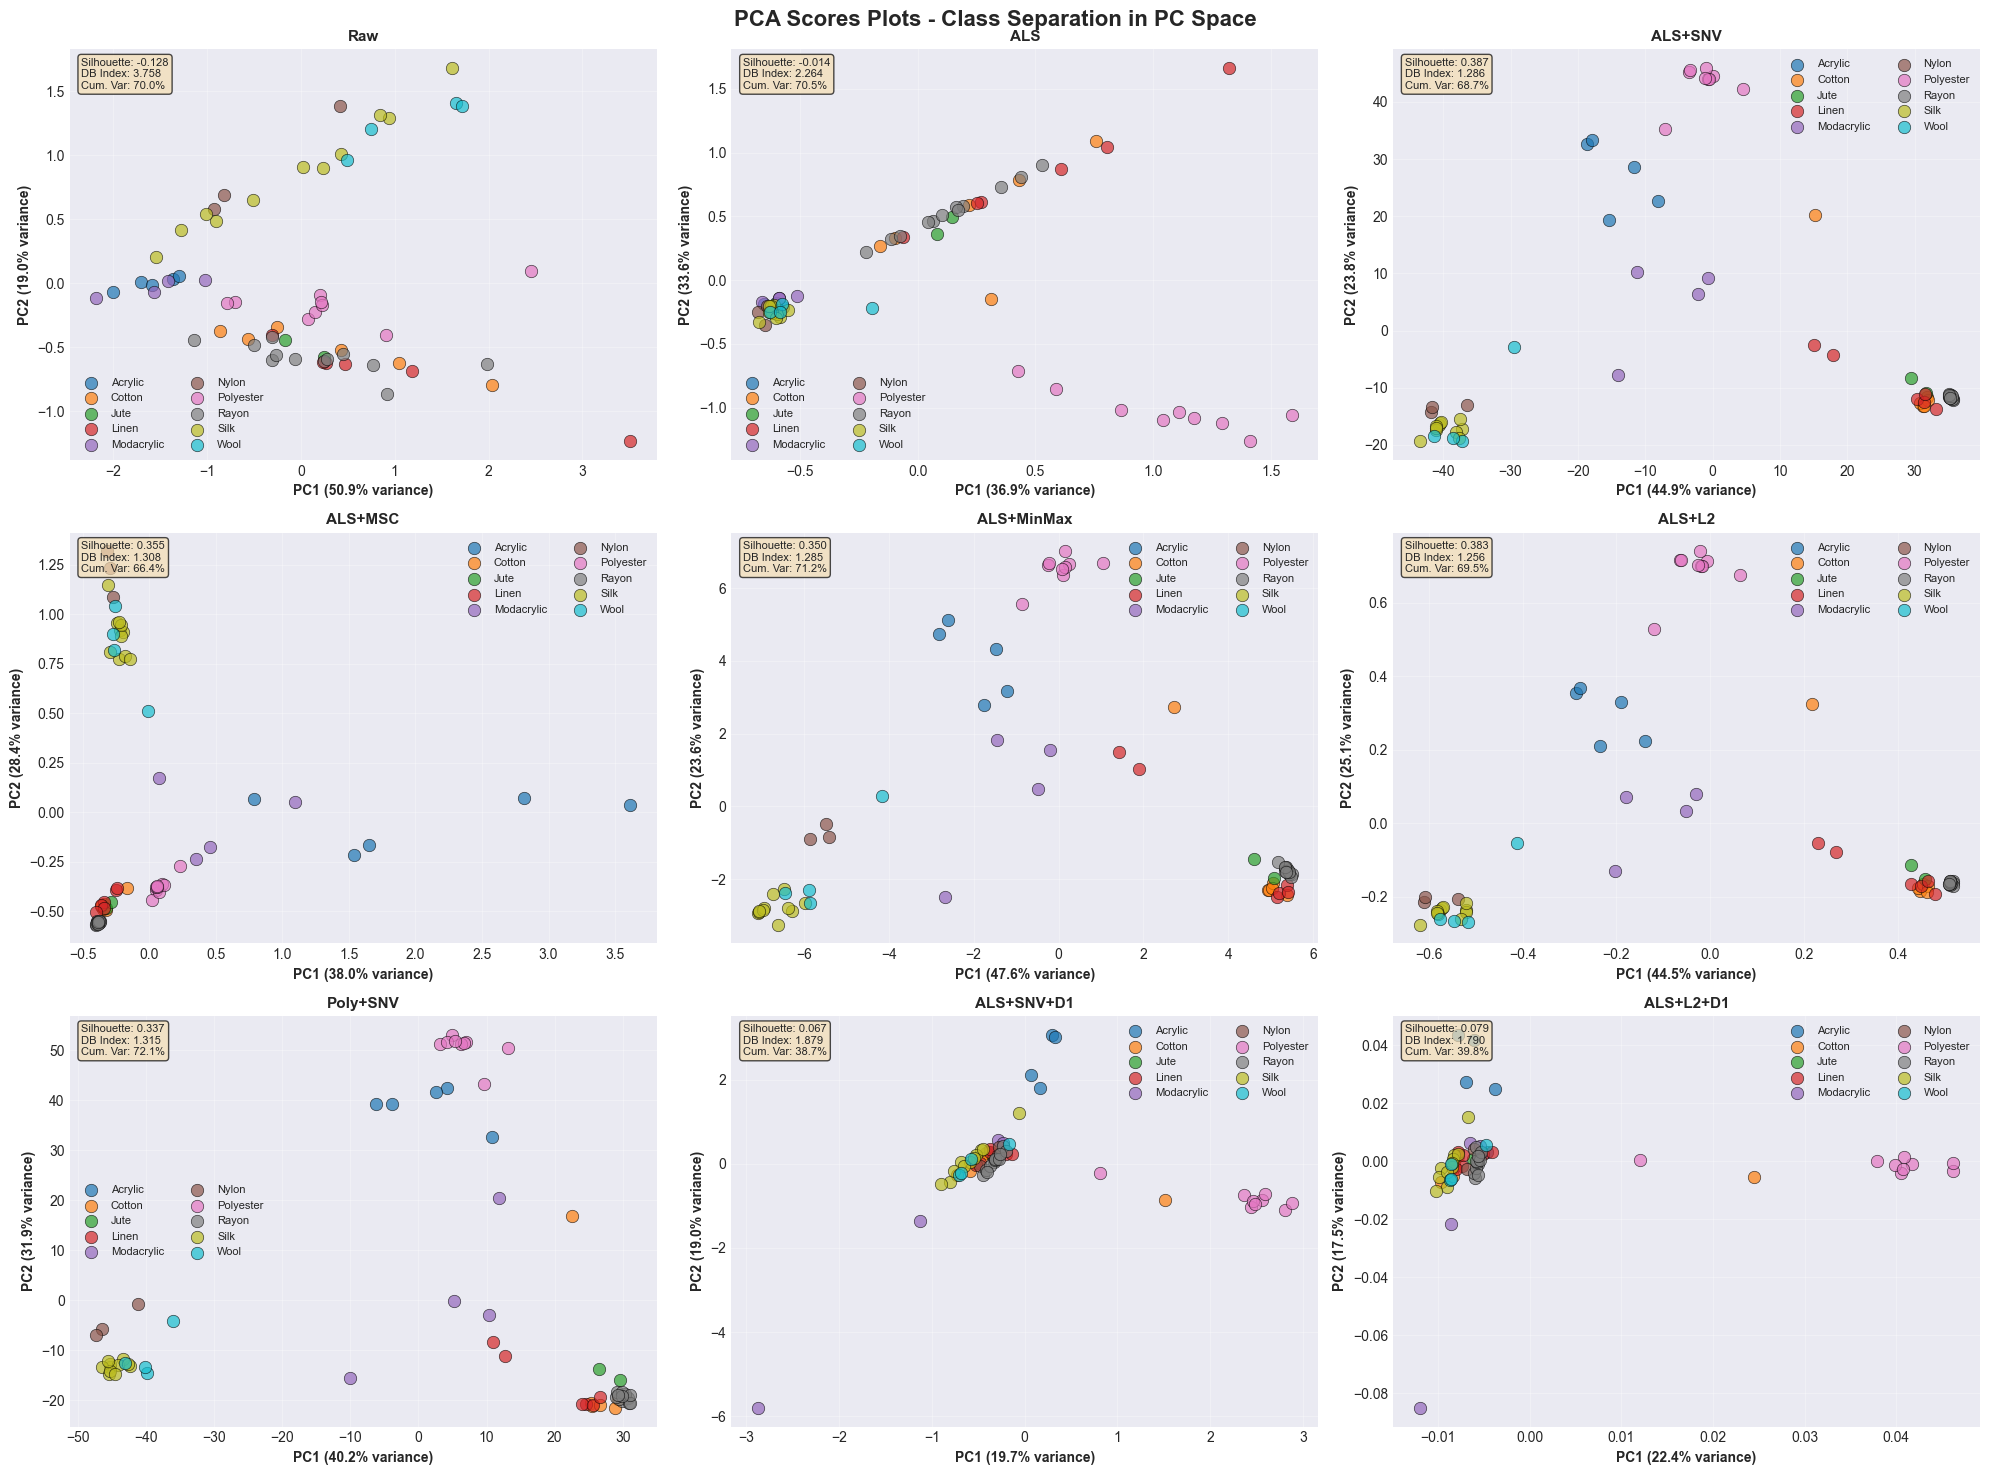

In [71]:
# Visualize PCA scores plots for all pipelines
n_pipelines = len(pca_results)
n_cols = 3
n_rows = (n_pipelines + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for idx, (pipeline_name, results) in enumerate(pca_results.items()):
    ax = axes[idx]
    
    X_pca = results['X_pca']
    y = results['y']
    
    # Plot PC1 vs PC2
    for fabric in sorted(fabric_types):
        mask = y == fabric
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  label=fabric, color=color_map[fabric], 
                  alpha=0.7, s=80, edgecolors='k', linewidth=0.5)
    
    # Add explained variance to labels
    ev1 = results['explained_variance_ratio'][0] * 100
    ev2 = results['explained_variance_ratio'][1] * 100
    
    ax.set_xlabel(f'PC1 ({ev1:.1f}% variance)', fontsize=10, fontweight='bold')
    ax.set_ylabel(f'PC2 ({ev2:.1f}% variance)', fontsize=10, fontweight='bold')
    ax.set_title(f'{pipeline_name}', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Add metrics as text
    sil_score = results['silhouette_score']
    db_idx = results['davies_bouldin_index']
    cum_var = results['cumulative_variance'][1] * 100
    
    metrics_text = f'Silhouette: {sil_score:.3f}\nDB Index: {db_idx:.3f}\nCum. Var: {cum_var:.1f}%'
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
           fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Hide unused subplots
for idx in range(n_pipelines, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('PCA Scores Plots - Class Separation in PC Space', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [72]:
# Create comprehensive PCA metrics table
pca_metrics_data = []

for pipeline_name, results in pca_results.items():
    pca_metrics_data.append({
        'Pipeline': pipeline_name,
        'PC1 Variance (%)': results['explained_variance_ratio'][0] * 100,
        'PC2 Variance (%)': results['explained_variance_ratio'][1] * 100,
        'PC1+PC2 Cumulative (%)': results['cumulative_variance'][1] * 100,
        'Top 5 PCs Cumulative (%)': results['cumulative_variance'][min(4, len(results['cumulative_variance'])-1)] * 100,
        'Silhouette Score': results['silhouette_score'],
        'Davies-Bouldin Index': results['davies_bouldin_index']
    })

pca_metrics_df = pd.DataFrame(pca_metrics_data)
pca_metrics_df = pca_metrics_df.round(3)

print(f"\n{'='*90}")
print(f"PCA METRICS SUMMARY")
print(f"{'='*90}")
print(pca_metrics_df.to_string(index=False))
print(f"\n{'='*90}")

# Rank by Silhouette score
pca_metrics_sorted = pca_metrics_df.sort_values('Silhouette Score', ascending=False)
print(f"\nPIPELINES RANKED BY SILHOUETTE SCORE (Higher = Better Clustering):")
print(f"{'='*90}")
for idx, row in pca_metrics_sorted.iterrows():
    print(f"{idx+1}. {row['Pipeline']:<25} Silhouette: {row['Silhouette Score']:.3f}, "
          f"DB Index: {row['Davies-Bouldin Index']:.3f}")
print(f"{'='*90}")


PCA METRICS SUMMARY
  Pipeline  PC1 Variance (%)  PC2 Variance (%)  PC1+PC2 Cumulative (%)  Top 5 PCs Cumulative (%)  Silhouette Score  Davies-Bouldin Index
       Raw            50.934            19.020                  69.954                    96.637            -0.128                 3.758
       ALS            36.908            33.633                  70.540                    96.129            -0.014                 2.264
   ALS+SNV            44.891            23.845                  68.736                    90.502             0.387                 1.286
   ALS+MSC            38.024            28.420                  66.444                    90.116             0.355                 1.308
ALS+MinMax            47.597            23.581                  71.178                    91.003             0.350                 1.285
    ALS+L2            44.470            25.065                  69.536                    90.870             0.383                 1.256
  Poly+SNV          

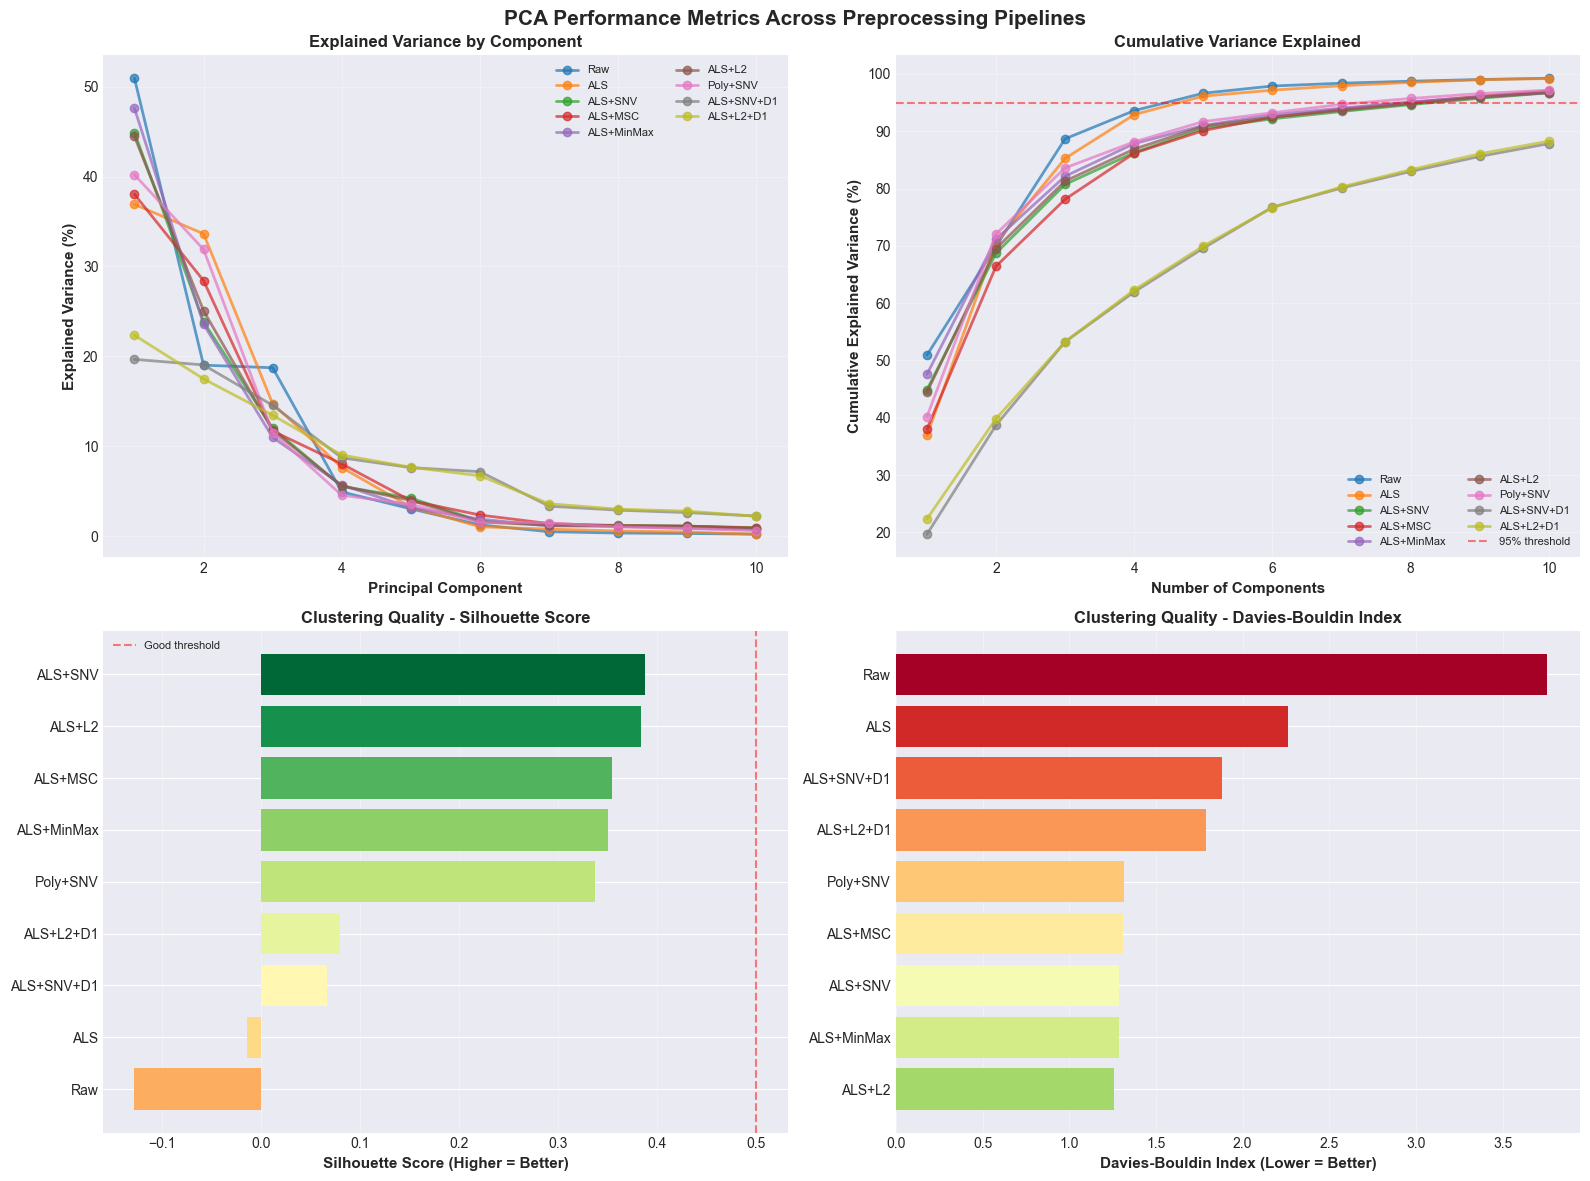

In [73]:
# Visualize explained variance curves for all pipelines
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Explained variance by PC for all pipelines
ax1 = axes[0, 0]
for pipeline_name, results in pca_results.items():
    n_components = len(results['explained_variance_ratio'])
    ax1.plot(range(1, n_components + 1), 
            results['explained_variance_ratio'] * 100,
            marker='o', linewidth=2, alpha=0.7, label=pipeline_name)
ax1.set_xlabel('Principal Component', fontsize=11, fontweight='bold')
ax1.set_ylabel('Explained Variance (%)', fontsize=11, fontweight='bold')
ax1.set_title('Explained Variance by Component', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative explained variance
ax2 = axes[0, 1]
for pipeline_name, results in pca_results.items():
    n_components = len(results['cumulative_variance'])
    ax2.plot(range(1, n_components + 1), 
            results['cumulative_variance'] * 100,
            marker='o', linewidth=2, alpha=0.7, label=pipeline_name)
ax2.axhline(y=95, color='r', linestyle='--', linewidth=1.5, alpha=0.5, label='95% threshold')
ax2.set_xlabel('Number of Components', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

# Plot 3: Silhouette scores comparison
ax3 = axes[1, 0]
pipeline_names_list = list(pca_results.keys())
silhouette_scores = [pca_results[p]['silhouette_score'] for p in pipeline_names_list]
sorted_indices = np.argsort(silhouette_scores)
sorted_pipelines = [pipeline_names_list[i] for i in sorted_indices]
sorted_silhouettes = [silhouette_scores[i] for i in sorted_indices]
colors_sil = plt.cm.RdYlGn(np.linspace(0.3, 1, len(sorted_pipelines)))
ax3.barh(sorted_pipelines, sorted_silhouettes, color=colors_sil)
ax3.axvline(x=0.5, color='r', linestyle='--', linewidth=1.5, alpha=0.5, label='Good threshold')
ax3.set_xlabel('Silhouette Score (Higher = Better)', fontsize=11, fontweight='bold')
ax3.set_title('Clustering Quality - Silhouette Score', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=8)
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Davies-Bouldin Index comparison
ax4 = axes[1, 1]
db_indices = [pca_results[p]['davies_bouldin_index'] for p in pipeline_names_list]
sorted_db_indices = np.argsort(db_indices)
sorted_pipelines_db = [pipeline_names_list[i] for i in sorted_db_indices]
sorted_db = [db_indices[i] for i in sorted_db_indices]
colors_db = plt.cm.RdYlGn_r(np.linspace(0.3, 1, len(sorted_pipelines_db)))
ax4.barh(sorted_pipelines_db, sorted_db, color=colors_db)
ax4.set_xlabel('Davies-Bouldin Index (Lower = Better)', fontsize=11, fontweight='bold')
ax4.set_title('Clustering Quality - Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('PCA Performance Metrics Across Preprocessing Pipelines', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Comprehensive Ranking and Recommendation

Combine all metrics to rank preprocessing pipelines and provide evidence-based recommendations for the ML pipeline.

In [74]:
# Create comprehensive ranking system
# Combine statistical and PCA metrics

ranking_data = []

for pipeline_name in preprocessing_pipelines.keys():
    # Get statistical metrics
    stat_metrics = statistical_metrics[pipeline_name]
    
    # Get PCA metrics
    pca_metrics = pca_results[pipeline_name]
    
    ranking_data.append({
        'Pipeline': pipeline_name,
        'Fisher Ratio': stat_metrics['Fisher Ratio'],
        'Within-Class Var': stat_metrics['Within-Class Variance'],
        'Between-Class Var': stat_metrics['Between-Class Variance'],
        'Mean CV': stat_metrics['Mean CV'],
        'Silhouette Score': pca_metrics['silhouette_score'],
        'Davies-Bouldin': pca_metrics['davies_bouldin_index'],
        'PC1+PC2 Var (%)': pca_metrics['cumulative_variance'][1] * 100
    })

ranking_df = pd.DataFrame(ranking_data)

# Normalize metrics for ranking (0-1 scale)
# Higher is better: Fisher Ratio, Between-Class Var, Silhouette, PC1+PC2 Var
# Lower is better: Within-Class Var, Mean CV, Davies-Bouldin

def normalize_metric(values, higher_better=True):
    min_val = np.nanmin(values)
    max_val = np.nanmax(values)
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    if not higher_better:
        normalized = 1 - normalized
    return normalized

ranking_df['Fisher_norm'] = normalize_metric(ranking_df['Fisher Ratio'].values, higher_better=True)
ranking_df['Within_norm'] = normalize_metric(ranking_df['Within-Class Var'].values, higher_better=False)
ranking_df['Between_norm'] = normalize_metric(ranking_df['Between-Class Var'].values, higher_better=True)
ranking_df['CV_norm'] = normalize_metric(ranking_df['Mean CV'].values, higher_better=False)
ranking_df['Silhouette_norm'] = normalize_metric(ranking_df['Silhouette Score'].values, higher_better=True)
ranking_df['DB_norm'] = normalize_metric(ranking_df['Davies-Bouldin'].values, higher_better=False)
ranking_df['PC_norm'] = normalize_metric(ranking_df['PC1+PC2 Var (%)'].values, higher_better=True)

# Calculate composite score (weighted average)
# Weights based on importance for classification tasks
weights = {
    'Fisher_norm': 0.25,      # Class separation
    'Silhouette_norm': 0.20,  # Clustering quality
    'DB_norm': 0.15,          # Cluster separation
    'Within_norm': 0.15,      # Within-class consistency
    'Between_norm': 0.15,     # Between-class separation
    'PC_norm': 0.10           # Dimensionality reduction efficiency
}

ranking_df['Composite Score'] = (
    ranking_df['Fisher_norm'] * weights['Fisher_norm'] +
    ranking_df['Silhouette_norm'] * weights['Silhouette_norm'] +
    ranking_df['DB_norm'] * weights['DB_norm'] +
    ranking_df['Within_norm'] * weights['Within_norm'] +
    ranking_df['Between_norm'] * weights['Between_norm'] +
    ranking_df['PC_norm'] * weights['PC_norm']
)

# Sort by composite score
ranking_df_sorted = ranking_df.sort_values('Composite Score', ascending=False)

# Display comprehensive results
print(f"\n{'='*100}")
print(f"COMPREHENSIVE PREPROCESSING PIPELINE RANKING")
print(f"{'='*100}")
print(f"\nRanking Methodology:")
print(f"  - Normalized all metrics to [0, 1] scale")
print(f"  - Weighted composite score based on classification importance")
print(f"  - Weights: Fisher={weights['Fisher_norm']}, Silhouette={weights['Silhouette_norm']}, "
      f"DB={weights['DB_norm']}, Within-Class={weights['Within_norm']}, "
      f"Between-Class={weights['Between_norm']}, PC Variance={weights['PC_norm']}")
print(f"\n{'='*100}")

# Display top pipelines
top_n = len(ranking_df_sorted)
print(f"\nRANKED PREPROCESSING PIPELINES (Best to Worst):")
print(f"{'='*100}")
for idx, (_, row) in enumerate(ranking_df_sorted.iterrows(), 1):
    print(f"\n{idx}. {row['Pipeline']}")
    print(f"   Composite Score: {row['Composite Score']:.4f}")
    print(f"   Fisher Ratio: {row['Fisher Ratio']:.4f}, "
          f"Silhouette: {row['Silhouette Score']:.4f}, "
          f"DB Index: {row['Davies-Bouldin']:.4f}")
    print(f"   Within-Class Var: {row['Within-Class Var']:.6f}, "
          f"Between-Class Var: {row['Between-Class Var']:.6f}")

print(f"\n{'='*100}")


COMPREHENSIVE PREPROCESSING PIPELINE RANKING

Ranking Methodology:
  - Normalized all metrics to [0, 1] scale
  - Weighted composite score based on classification importance
  - Weights: Fisher=0.25, Silhouette=0.2, DB=0.15, Within-Class=0.15, Between-Class=0.15, PC Variance=0.1


RANKED PREPROCESSING PIPELINES (Best to Worst):

1. Poly+SNV
   Composite Score: 0.8270
   Fisher Ratio: 5.9880, Silhouette: 0.3374, DB Index: 1.3152
   Within-Class Var: 0.091322, Between-Class Var: 0.546834

2. ALS+L2
   Composite Score: 0.8259
   Fisher Ratio: 5.6976, Silhouette: 0.3830, DB Index: 1.2556
   Within-Class Var: 0.000018, Between-Class Var: 0.000104

3. ALS+SNV
   Composite Score: 0.8024
   Fisher Ratio: 5.5165, Silhouette: 0.3873, DB Index: 1.2861
   Within-Class Var: 0.090460, Between-Class Var: 0.499017

4. ALS+MinMax
   Composite Score: 0.7917
   Fisher Ratio: 5.2268, Silhouette: 0.3498, DB Index: 1.2848
   Within-Class Var: 0.002175, Between-Class Var: 0.011366

5. ALS+MSC
   Composite S

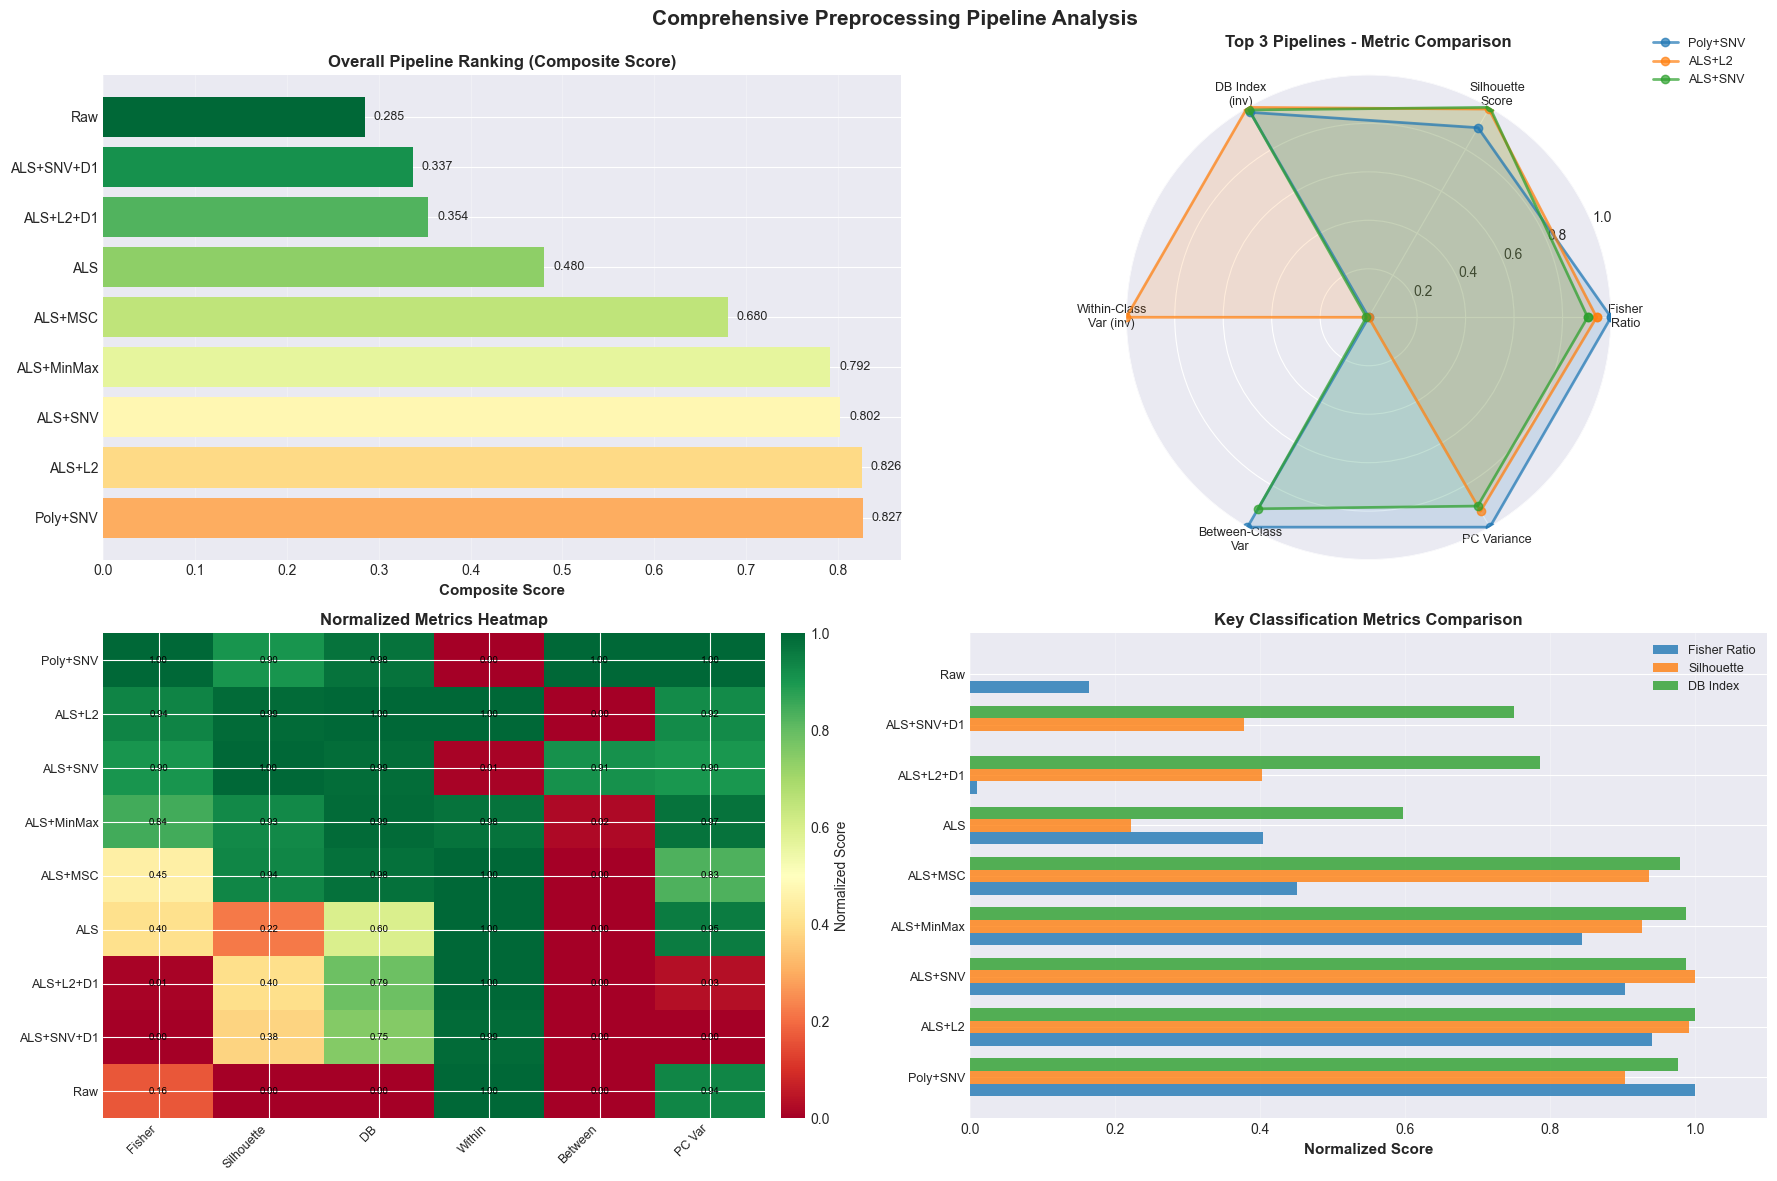

In [75]:
# Visualize comprehensive ranking
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Composite Score Ranking
ax1 = axes[0, 0]
pipelines_sorted = ranking_df_sorted['Pipeline'].values
composite_scores = ranking_df_sorted['Composite Score'].values
colors_rank = plt.cm.RdYlGn(np.linspace(0.3, 1, len(pipelines_sorted)))
bars1 = ax1.barh(pipelines_sorted, composite_scores, color=colors_rank)
ax1.set_xlabel('Composite Score', fontsize=11, fontweight='bold')
ax1.set_title('Overall Pipeline Ranking (Composite Score)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, score) in enumerate(zip(bars1, composite_scores)):
    ax1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)

# Plot 2: Radar chart comparison of top 3 pipelines
ax2 = axes[0, 1]
ax2.axis('off')

# Get top 3 pipelines
top_3 = ranking_df_sorted.head(3)
categories = ['Fisher\nRatio', 'Silhouette\nScore', 'DB Index\n(inv)', 
              'Within-Class\nVar (inv)', 'Between-Class\nVar', 'PC Variance']
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Create polar subplot
ax2 = plt.subplot(2, 2, 2, projection='polar')
colors_top3 = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (_, row) in enumerate(top_3.iterrows()):
    values = [
        row['Fisher_norm'],
        row['Silhouette_norm'],
        row['DB_norm'],
        row['Within_norm'],
        row['Between_norm'],
        row['PC_norm']
    ]
    values += values[:1]
    
    ax2.plot(angles, values, 'o-', linewidth=2, label=row['Pipeline'], 
            color=colors_top3[idx], alpha=0.7)
    ax2.fill(angles, values, alpha=0.15, color=colors_top3[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=9)
ax2.set_ylim(0, 1)
ax2.set_title('Top 3 Pipelines - Metric Comparison', fontsize=12, fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax2.grid(True)

# Plot 3: Metric heatmap for all pipelines
ax3 = axes[1, 0]
heatmap_data = ranking_df_sorted[['Fisher_norm', 'Silhouette_norm', 'DB_norm', 
                                   'Within_norm', 'Between_norm', 'PC_norm']].values
pipeline_labels = [p[:20] for p in ranking_df_sorted['Pipeline'].values]
metric_labels = ['Fisher', 'Silhouette', 'DB', 'Within', 'Between', 'PC Var']

im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax3.set_yticks(np.arange(len(pipeline_labels)))
ax3.set_yticklabels(pipeline_labels, fontsize=9)
ax3.set_xticks(np.arange(len(metric_labels)))
ax3.set_xticklabels(metric_labels, fontsize=9, rotation=45, ha='right')
ax3.set_title('Normalized Metrics Heatmap', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, orientation='vertical', pad=0.02)
cbar.set_label('Normalized Score', fontsize=10)

# Add text annotations
for i in range(len(pipeline_labels)):
    for j in range(len(metric_labels)):
        text = ax3.text(j, i, f'{heatmap_data[i, j]:.2f}',
                       ha='center', va='center', color='black', fontsize=7)

# Plot 4: Key metrics comparison
ax4 = axes[1, 1]
x_pos = np.arange(len(pipelines_sorted))
width = 0.25

fisher_normalized = ranking_df_sorted['Fisher_norm'].values
silhouette_normalized = ranking_df_sorted['Silhouette_norm'].values
db_normalized = ranking_df_sorted['DB_norm'].values

bars1 = ax4.barh(x_pos - width, fisher_normalized, width, label='Fisher Ratio', alpha=0.8)
bars2 = ax4.barh(x_pos, silhouette_normalized, width, label='Silhouette', alpha=0.8)
bars3 = ax4.barh(x_pos + width, db_normalized, width, label='DB Index', alpha=0.8)

ax4.set_yticks(x_pos)
ax4.set_yticklabels([p[:20] for p in pipelines_sorted], fontsize=9)
ax4.set_xlabel('Normalized Score', fontsize=11, fontweight='bold')
ax4.set_title('Key Classification Metrics Comparison', fontsize=12, fontweight='bold')
ax4.legend(loc='best', fontsize=9)
ax4.grid(axis='x', alpha=0.3)
ax4.set_xlim(0, 1.1)

plt.suptitle('Comprehensive Preprocessing Pipeline Analysis', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Final Recommendations for ML Pipeline

Based on comprehensive quantitative and qualitative analysis, here are evidence-based recommendations for the ML pipeline selection.

In [76]:
# Generate final recommendations
print(f"\n{'='*100}")
print(f"FINAL RECOMMENDATIONS FOR ML PIPELINE")
print(f"{'='*100}")

top_3_pipelines = ranking_df_sorted.head(3)

print(f"\n1. PRIMARY RECOMMENDATION: {top_3_pipelines.iloc[0]['Pipeline']}")
print(f"   {'='*96}")
print(f"   Composite Score: {top_3_pipelines.iloc[0]['Composite Score']:.4f}")
print(f"   ")
print(f"   Key Strengths:")
print(f"   - Fisher Ratio: {top_3_pipelines.iloc[0]['Fisher Ratio']:.4f} "
      f"(Class Separation: {'Excellent' if top_3_pipelines.iloc[0]['Fisher Ratio'] > ranking_df['Fisher Ratio'].median() else 'Good'})")
print(f"   - Silhouette Score: {top_3_pipelines.iloc[0]['Silhouette Score']:.4f} "
      f"(Clustering: {'Excellent' if top_3_pipelines.iloc[0]['Silhouette Score'] > 0.5 else 'Good' if top_3_pipelines.iloc[0]['Silhouette Score'] > 0.3 else 'Moderate'})")
print(f"   - Davies-Bouldin Index: {top_3_pipelines.iloc[0]['Davies-Bouldin']:.4f} "
      f"(Lower is better)")
print(f"   - PC1+PC2 Variance: {top_3_pipelines.iloc[0]['PC1+PC2 Var (%)']:.2f}% "
      f"(Dimensionality Reduction Efficiency)")
print(f"   ")
print(f"   Recommendation:")
print(f"   - Use this pipeline as the PRIMARY preprocessing for your ML models")
print(f"   - Suitable for: Classification, supervised learning, feature extraction")
print(f"   - Best for: Models requiring well-separated classes (SVM, Random Forest, Neural Networks)")

print(f"\n2. ALTERNATIVE RECOMMENDATION: {top_3_pipelines.iloc[1]['Pipeline']}")
print(f"   {'='*96}")
print(f"   Composite Score: {top_3_pipelines.iloc[1]['Composite Score']:.4f}")
print(f"   ")
print(f"   Key Strengths:")
print(f"   - Fisher Ratio: {top_3_pipelines.iloc[1]['Fisher Ratio']:.4f}")
print(f"   - Silhouette Score: {top_3_pipelines.iloc[1]['Silhouette Score']:.4f}")
print(f"   - Davies-Bouldin Index: {top_3_pipelines.iloc[1]['Davies-Bouldin']:.4f}")
print(f"   - PC1+PC2 Variance: {top_3_pipelines.iloc[1]['PC1+PC2 Var (%)']:.2f}%")
print(f"   ")
print(f"   Recommendation:")
print(f"   - Use as an ALTERNATIVE if primary pipeline shows overfitting")
print(f"   - Good for cross-validation and ensemble methods")

print(f"\n3. THIRD OPTION: {top_3_pipelines.iloc[2]['Pipeline']}")
print(f"   {'='*96}")
print(f"   Composite Score: {top_3_pipelines.iloc[2]['Composite Score']:.4f}")
print(f"   ")
print(f"   Key Strengths:")
print(f"   - Fisher Ratio: {top_3_pipelines.iloc[2]['Fisher Ratio']:.4f}")
print(f"   - Silhouette Score: {top_3_pipelines.iloc[2]['Silhouette Score']:.4f}")
print(f"   - Davies-Bouldin Index: {top_3_pipelines.iloc[2]['Davies-Bouldin']:.4f}")
print(f"   - PC1+PC2 Variance: {top_3_pipelines.iloc[2]['PC1+PC2 Var (%)']:.2f}%")


FINAL RECOMMENDATIONS FOR ML PIPELINE

1. PRIMARY RECOMMENDATION: Poly+SNV
   Composite Score: 0.8270
   
   Key Strengths:
   - Fisher Ratio: 5.9880 (Class Separation: Excellent)
   - Silhouette Score: 0.3374 (Clustering: Good)
   - Davies-Bouldin Index: 1.3152 (Lower is better)
   - PC1+PC2 Variance: 72.09% (Dimensionality Reduction Efficiency)
   
   Recommendation:
   - Use this pipeline as the PRIMARY preprocessing for your ML models
   - Suitable for: Classification, supervised learning, feature extraction
   - Best for: Models requiring well-separated classes (SVM, Random Forest, Neural Networks)

2. ALTERNATIVE RECOMMENDATION: ALS+L2
   Composite Score: 0.8259
   
   Key Strengths:
   - Fisher Ratio: 5.6976
   - Silhouette Score: 0.3830
   - Davies-Bouldin Index: 1.2556
   - PC1+PC2 Variance: 69.54%
   
   Recommendation:
   - Use as an ALTERNATIVE if primary pipeline shows overfitting
   - Good for cross-validation and ensemble methods

3. THIRD OPTION: ALS+SNV
   Composite S

For Classification Tasks:
  - Prioritize pipelines with high Fisher Ratio and Silhouette Score
  - Top 3 pipelines all show good class separation
  - Use PCA for dimensionality reduction before feeding to ML models

For Dataset Curation:
  - The top-ranked pipeline provides the best balance of:
    * Within-class consistency (reproducibility)
    * Between-class separation (discriminability)
    * Dimensionality reduction efficiency (computational efficiency)

Next Steps:
  1. Implement top 3 pipelines in ML workflow
  2. Perform cross-validated classification with multiple algorithms
  3. Compare model performance (accuracy, F1-score, confusion matrix)
  4. Select final pipeline based on ML model performance
  5. Document preprocessing choices in publication

## Export Results for Documentation

Save the comprehensive analysis results to CSV files for reference and publication.

In [77]:
# Export comprehensive results to CSV files
output_folder = Path('preprocessing_analysis_results')
output_folder.mkdir(exist_ok=True)

# 1. Save statistical metrics
stats_export = pd.DataFrame(statistical_metrics).T
stats_export.to_csv(output_folder / 'statistical_metrics.csv')

# 2. Save PCA metrics
pca_export = pca_metrics_df.copy()
pca_export.to_csv(output_folder / 'pca_metrics.csv', index=False)

# 3. Save comprehensive ranking
ranking_export = ranking_df_sorted[[
    'Pipeline', 'Composite Score', 'Fisher Ratio', 'Silhouette Score', 
    'Davies-Bouldin', 'Within-Class Var', 'Between-Class Var', 
    'Mean CV', 'PC1+PC2 Var (%)'
]]
ranking_export.to_csv(output_folder / 'pipeline_rankings.csv', index=False)

# 4. Save top 3 recommendations
top_3_export = ranking_df_sorted.head(3)[[
    'Pipeline', 'Composite Score', 'Fisher Ratio', 'Silhouette Score', 
    'Davies-Bouldin', 'PC1+PC2 Var (%)'
]]
top_3_export.to_csv(output_folder / 'top_3_recommendations.csv', index=False)

print(f"\n{'='*70}")
print(f"RESULTS EXPORTED SUCCESSFULLY")
print(f"{'='*70}")
print(f"\nOutput folder: {output_folder.absolute()}")
print(f"\nFiles created:")
print(f"  1. statistical_metrics.csv - Statistical analysis results")
print(f"  2. pca_metrics.csv - PCA performance metrics")
print(f"  3. pipeline_rankings.csv - Complete pipeline rankings")
print(f"  4. top_3_recommendations.csv - Top 3 recommended pipelines")
print(f"\n{'='*70}")
print(f"\nThese files can be used for:")
print(f"  - Documentation in your research paper")
print(f"  - Supplementary materials")
print(f"  - Reference for ML pipeline implementation")
print(f"{'='*70}")


RESULTS EXPORTED SUCCESSFULLY

Output folder: d:\Workspace\Career\FasTEX - Research Internship\Experiments\preprocessing_analysis_results

Files created:
  1. statistical_metrics.csv - Statistical analysis results
  2. pca_metrics.csv - PCA performance metrics
  3. pipeline_rankings.csv - Complete pipeline rankings
  4. top_3_recommendations.csv - Top 3 recommended pipelines


These files can be used for:
  - Documentation in your research paper
  - Supplementary materials
  - Reference for ML pipeline implementation
